# Import statements

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import folium

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.tree import  export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
import sklearn.tree as tree
import sklearn.metrics as metrics

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.max_columns = 999

# Import bike trips and stations

In [826]:
# Function to import bike_data_2019.csv with try and except
def import_bike_data():
    """
    Read all CSV files in a directory and return them as a list of Pandas dataframes.
    """
    try:
        bike_data_2019 = pd.read_csv('./Final Data Files/bike_data_2019.csv')
        print("File bike_data_2019.csv successfully read.")
    except Exception as e:
        print(f"Error reading file bike_data_2019.csv: {e}")
    
    return bike_data_2019

# Function to import bike_points.csv with try and except
def import_bike_points():
    """
    Read all CSV files in a directory and return them as a list of Pandas dataframes.
    """
    try:
        bike_points = pd.read_csv('./Final Data Files/bike_points.csv')
        print("File bike_points.csv successfully read.")
    except Exception as e:
        print(f"Error reading file bike_points.csv: {e}")
    
    return bike_points

In [827]:
bike_data = import_bike_data()
bike_data.head()

File bike_data_2019.csv successfully read.


rental_id  duration  bike_id    end_date  endstation_id  \
0   91113807       240    16022  2019-09-11            125   
1   91265425      2400    15227  2019-09-15            532   
2   91210424       480     9654  2019-09-13            715   
3   91190653       540     3586  2019-09-13            715   
4   91274678       360    16132  2019-09-15            648   

                    endstation_name  start_date  startstation_id  \
0  Borough High Street, The Borough  2019-09-11               10   
1       Jubilee Plaza, Canary Wharf  2019-09-15              237   
2           Aylward Street, Stepney  2019-09-13              444   
3           Aylward Street, Stepney  2019-09-13              444   
4      Peterborough Road, Sands End  2019-09-15              671   

                      startstation_name      start_timestamp  \
0                 Park Street, Bankside  2019-09-11 13:21:00   
1                  Dock Street, Wapping  2019-09-15 14:59:00   
2   Bethnal Green Garden, Bethnal Green  2019-09-13 21:56:00   
3   Bethnal Green Garden, Bethnal Green  2019-09-13 13:46:00   
4  Parsons Green Station, Parsons Green  2019-09-15 17:50:00   

         end_timestamp  start_day  start_month  start_year  start_hour  \
0  2019-09-11 13:25:00         11            9        2019          13   
1  2019-09-15 15:39:00         15            9        2019          14   
2  2019-09-13 22:04:00         13            9        2019          21   
3  2019-09-13 13:55:00         13            9        2019          13   
4  2019-09-15 17:56:00         15            9        2019          17   

  start_day_of_week  end_day  end_month  end_year  end_hour end_day_of_week  \
0         Wednesday       11          9      2019        13       Wednesday   
1            Sunday       15          9      2019        15          Sunday   
2            Friday       13          9      2019        22          Friday   
3            Friday       13          9      2019        13          Friday   
4            Sunday       15          9      2019        17          Sunday   

   bank_holiday  peak_hour  duration_minutes  
0             0          0               4.0  
1             0          0              40.0  
2             0          0               8.0  
3             0          0               9.0  
4             0          0               6.0

In [5]:
bike_points = import_bike_points()
bike_points.shape

File bike_points.csv successfully read.


(796, 9)

In [6]:
bike_points.head()

bike_station_name  station_longitude  station_latitude  \
0            River Street , Clerkenwell          -0.109970         51.529163   
1        Phillimore Gardens, Kensington          -0.197574         51.499606   
2  Christopher Street, Liverpool Street          -0.084605         51.521283   
3       St. Chad's Street, King's Cross          -0.120973         51.530059   
4         Sedding Street, Sloane Square          -0.156876         51.493130   

   number_of_bikes  number_empty_docks  number_of_docks  \
0               13                   6               19   
1               33                   4               37   
2                0                  32               32   
3                8                  15               23   
4                3                  24               27   

   number_standard_bikes  number_ebikes  bike_station_id  
0                      9              4                1  
1                     33              0                2  
2                      0              0                3  
3                      8              0                4  
4                      3              0                5

There are 10,310,063 records in bike trips with 24 columns representing the start and end of the trip information such as time, date, station names and peak hour and bank_holiday

There are 796 live stations around London and it inludes information about the bike stations such as number of bike, number of empty docks and station longitude and latitude (historical data is not available)

### Cleaning trip and stations data

In [828]:
# Function to remove start/end station ids that are not in the bike_data dataframe
def remove_invalid_station_ids(df, bike_points):
    """
    Returns a dataframe with the rows that have valid start_station_id and end_station_id.
    """
    # get the list of valid station ids
    valid_station_ids = bike_points['bike_station_id'].unique()
    
    # filter the dataframe by the valid station ids
    df = df[df['startstation_id'].isin(valid_station_ids)]
    df = df[df['endstation_id'].isin(valid_station_ids)]
    
    return df


In [829]:
bike_data = remove_invalid_station_ids(bike_data, bike_points)


In [830]:
# Function to change start/end station names to bike_points station names
def change_station_names(df, bike_points):
    """
    Returns a dataframe with the start_station_name and end_station_name columns changed to the bike_points station names.
    """
    # change the start_station_name and end_station_name columns to the bike_points station names
    df['startstation_name'] = df['startstation_id'].map(bike_points.set_index('bike_station_id')['bike_station_name'])
    df['endstation_name'] = df['endstation_id'].map(bike_points.set_index('bike_station_id')['bike_station_name'])
    
    return df

In [831]:
bike_data = change_station_names(bike_data, bike_points)

In [11]:
bike_data.shape

(9954256, 24)

Some station details were found removed from the live bike stations and had to remove trips that were using these ids to make sure the data is consistent and we have all the details. Also, some stations with same ids had different names in the trips and had to change the ids in the trips data to match with the stations details data.

# Import Demographical and socio-economical data

In [832]:
# read demographic data
demographics = pd.read_csv('./Final Data Files/demographics.csv')

In [833]:
demographics.head()

borough_name borough_code  \
0                  Camden    E09000007   
1          City of London    E09000001   
2                 Hackney    E09000012   
3  Hammersmith and Fulham    E09000013   
4               Islington    E09000019   

   % of all people aged 16+ who are female  \
0                                     48.7   
1                                     46.4   
2                                     50.5   
3                                     49.2   
4                                     50.0   

   % of all people aged 16+ who are male  % of all 16+ who are aged 16-19  \
0                                   51.3                              4.8   
1                                   53.6                              NaN   
2                                   49.5                              6.5   
3                                   50.8                              3.2   
4                                   50.0                              4.7   

   % of all 16+ who are aged 20-24  % of all 16+ who are aged 25-34  \
0                             10.2                             20.2   
1                              NaN                             45.4   
2                              8.4                             33.7   
3                              8.6                             29.5   
4                              9.3                             28.6   

   % of all 16+ who are aged 35-49  % of all 16+ who are aged 50-64  \
0                             24.4                             24.5   
1                              NaN                             23.4   
2                             26.6                             17.6   
3                             28.3                             17.7   
4                             27.6                             16.9   

   % of all 16+ who are aged 65+  \
0                           15.9   
1                           31.1   
2                            7.1   
3                           12.8   
4                           12.9   

   % in employment who are employees - aged 16+  \
0                                          78.3   
1                                          73.0   
2                                          82.6   
3                                          83.3   
4                                          83.2   

   % in employment who are self employed - aged 16+  \
0                                              21.5   
1                                              27.0   
2                                              16.8   
3                                              16.0   
4                                              16.7   

   Employment rate - aged 16+  Unemployment rate - aged 16+  \
0                        61.6                           5.6   
1                        82.3                           NaN   
2                        67.8                           4.4   
3                        67.8                           3.7   
4                        70.0                           4.2   

   % in employment working full-time - aged 16-19  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   

   % in employment working full-time - aged 20-24  \
0                                            50.9   
1                                             NaN   
2                                            53.8   
3                                            95.0   
4                                            72.6   

   % in employment working full-time - aged 25-49  \
0                                            80.9   
1                                           100.0   
2                                            82.5   
3                                            89.9   
4                            

138 features that represent different demographic and socio-economic data on boroughs level

# import weather dataset

In [836]:
weather = pd.read_csv('./Final Data Files/weather_london_hourly_2016-2022.csv')

In [837]:
weather.head()

datetime  temp  feelslike  dew  humidity  precip  windgust  \
0  2016-01-01T00:00:00   5.1        2.6  2.5     83.33   0.398       NaN   
1  2016-01-01T01:00:00   4.1        2.3  2.3     88.09   0.000       NaN   
2  2016-01-01T02:00:00   3.5        2.1  2.1     90.57   0.000       NaN   
3  2016-01-01T03:00:00   3.1        3.1  2.1     93.16   0.000       NaN   
4  2016-01-01T04:00:00   3.1        1.7  2.3     94.49   0.000       NaN   

   windspeed  cloudcover  visibility  uvindex  
0       11.0        78.5        30.1      0.0  
1        7.5         0.0        15.3      0.0  
2        5.8         0.0        13.3      0.0  
3        3.9         0.0         5.2      0.0  
4        5.9        99.1        12.5      0.0

In [16]:
# check for null values
weather.isnull().sum()

datetime          0
temp              0
feelslike         0
dew               0
humidity          0
precip            0
windgust      46814
windspeed         0
cloudcover        0
visibility        0
uvindex          15
dtype: int64

There is null values for windgust and uv index in the weather dataset

In [17]:
# create a new columns for the hour, day, month, and year
weather['hour'] = pd.DatetimeIndex(weather['datetime']).hour
weather['day'] = pd.DatetimeIndex(weather['datetime']).day
weather['month'] = pd.DatetimeIndex(weather['datetime']).month
weather['year'] = pd.DatetimeIndex(weather['datetime']).year

In [18]:
# drop the datetime column
weather.drop('datetime', axis=1, inplace=True)

# remove windgust column
weather.drop('windgust', axis=1, inplace=True)

# keep 2019 data only
weather = weather[weather['year'] == 2019]

In [19]:
weather.describe()

temp    feelslike          dew     humidity       precip  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     12.198836    11.406918     7.328858    74.144080     0.069627   
std       5.825481     6.651286     4.571098    15.643547     0.638576   
min      -2.500000    -5.300000    -6.200000    25.870000     0.000000   
25%       8.000000     5.900000     3.900000    64.120000     0.000000   
50%      11.500000    11.500000     7.200000    77.150000     0.000000   
75%      16.500000    16.500000    10.700000    86.582500     0.000000   
max      36.100000    38.200000    22.100000   100.000000    23.829000   

         windspeed   cloudcover   visibility      uvindex         hour  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     13.461404    66.358744    26.010628     0.730936    11.500000   
std       7.447395    30.276652    13.235350     1.458519     6.922582   
min       0.600000     0.000000     0.000000     0.000000     0.000000   
25%       7.900000    45.400000    15.200000     0.000000     5.750000   
50%      12.200000    78.000000    26.300000     0.000000    11.500000   
75%      17.600000    90.700000    36.800000     1.000000    17.250000   
max      50.200000   100.000000    60.800000    10.000000    23.000000   

               day        month    year  
count  8760.000000  8760.000000  8760.0  
mean     15.720091     6.526826  2019.0  
std       8.796060     3.448042     0.0  
min       1.000000     1.000000  2019.0  
25%       8.000000     4.000000  2019.0  
50%      16.000000     7.000000  2019.0  
75%      23.000000    10.000000  2019.0  
max      31.000000    12.000000  2019.0

# Import house prices

In [20]:
houses_by_borough = pd.read_csv("./Final Data Files/houses_average_price_2019.csv")
# Define the borough columns to melt
borough_columns = houses_by_borough.columns[1:]

houses_by_borough = pd.melt(houses_by_borough, id_vars='date', value_vars=borough_columns, var_name='borough', value_name='value')

# extract year and month from date column
houses_by_borough['year'] = pd.DatetimeIndex(houses_by_borough['date']).year
houses_by_borough['month'] = pd.DatetimeIndex(houses_by_borough['date']).month

houses_by_borough.head()

date    borough        value  year  month
0  2019-01-01  E09000001  865636.1043  2019      1
1  2019-02-01  E09000001  894519.9090  2019      2
2  2019-03-01  E09000001  853451.0753  2019      3
3  2019-04-01  E09000001  738796.7242  2019      4
4  2019-05-01  E09000001  719217.5584  2019      5

In [21]:
houses_by_borough.shape

(396, 5)

# import GIS London Boroughs boundaries

In [22]:
geometry = [Point(xy) for xy in zip(bike_points['station_longitude'], bike_points['station_latitude'])]
gdf_station = gpd.GeoDataFrame(bike_points, geometry=geometry)

### extract boroughs that cover bike stations

In [23]:
borough_path = "/Users/mohammadmaraqa/Desktop/Masters/Modules/7CCSMPRJ & 7CUSMUIP MSc Individual Project/Data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

london_boroughs = gpd.read_file(borough_path)

# Assign the CRS to the London boroughs GeoDataFrame
london_boroughs = london_boroughs.to_crs('epsg:27700')

# Assuming gdf_station is your GeoDataFrame containing the cycling stations
gdf_station.crs = 'epsg:4326'  # Assuming the original CRS is WGS84
gdf_stations = gdf_station.to_crs('epsg:27700')

# Reproject the bike stations dataset to EPSG:4326
gdf_station = gdf_station.to_crs(from_epsg(4326))

# Load the London boroughs shapefile and reproject it to EPSG:4326 if needed
# london_boroughs = gpd.read_file(borough_path)
if london_boroughs.crs != from_epsg(4326):
    london_boroughs = london_boroughs.to_crs(from_epsg(4326))

covered_boroughs = []  # Create an empty list to store the covered boroughs

for _, station in gdf_station.iterrows():
    borough = london_boroughs[london_boroughs.geometry.contains(station.geometry)]
    if not borough.empty:
        borough_code = borough.iloc[0]['GSS_CODE']
        borough_name = borough.iloc[0]['NAME']
        covered_boroughs.append(borough_code)  # Add the borough code to the list
        gdf_station.loc[_, 'borough_code'] = borough_code  # Add the borough code to the station GeoDataFrame
        gdf_station.loc[_, 'borough_name'] = borough_name  # Add the borough name to the station GeoDataFrame

Import GIS Data to extract boroughs of the stations and merge them into the trip and station data

In [24]:
#unique boroughs in the list
covered_boroughs = list(set(covered_boroughs))
print(covered_boroughs)

['E09000019', 'E09000020', 'E09000013', 'E09000001', 'E09000007', 'E09000022', 'E09000012', 'E09000033', 'E09000032', 'E09000030', 'E09000025', 'E09000028']


Boroughs covered for the bike stations are 12:
['E09000022', 'E09000032', 'E09000025', 'E09000019', 'E09000013', 'E09000028', 'E09000007', 'E09000020', 'E09000033', 'E09000001', 'E09000030', 'E09000012']

In [25]:
london_boroughs_covered = london_boroughs[london_boroughs['GSS_CODE'].isin(covered_boroughs)]

In [26]:
bike_points_with_borough = gpd.sjoin(gdf_station, london_boroughs_covered, how='left', op='within')
bike_points_with_borough.head()

/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


bike_station_name  station_longitude  station_latitude  \
0            River Street , Clerkenwell          -0.109970         51.529163   
1        Phillimore Gardens, Kensington          -0.197574         51.499606   
2  Christopher Street, Liverpool Street          -0.084605         51.521283   
3       St. Chad's Street, King's Cross          -0.120973         51.530059   
4         Sedding Street, Sloane Square          -0.156876         51.493130   

   number_of_bikes  number_empty_docks  number_of_docks  \
0               13                   6               19   
1               33                   4               37   
2                0                  32               32   
3                8                  15               23   
4                3                  24               27   

   number_standard_bikes  number_ebikes  bike_station_id  \
0                      9              4                1   
1                     33              0                2   
2                      0              0                3   
3                      8              0                4   
4                      3              0                5   

                    geometry borough_code            borough_name  \
0  POINT (-0.10997 51.52916)    E09000019               Islington   
1  POINT (-0.19757 51.49961)    E09000020  Kensington and Chelsea   
2  POINT (-0.08460 51.52128)    E09000012                 Hackney   
3  POINT (-0.12097 51.53006)    E09000007                  Camden   
4  POINT (-0.15688 51.49313)    E09000020  Kensington and Chelsea   

   index_right                    NAME   GSS_CODE  HECTARES  NONLD_AREA  \
0         27.0               Islington  E09000019  1485.664       0.000   
1         23.0  Kensington and Chelsea  E09000020  1238.379      25.994   
2         28.0                 Hackney  E09000012  1904.902       0.000   
3         25.0                  Camden  E09000007  2178.932       0.000   
4         23.0  Kensington and Chelsea  E09000020  1238.379      25.994   

  ONS_INNER  SUB_2009  SUB_2006  
0         T       NaN       NaN  
1         T       NaN       NaN  
2         T       NaN       NaN  
3         T       NaN       NaN  
4         T       NaN       NaN

In [27]:
# drop index_right	NAME	GSS_CODE	HECTARES	NONLD_AREA	ONS_INNER	SUB_2009	SUB_2006 from bike_points_with_borough
bike_points_with_borough = bike_points_with_borough.drop(['index_right', 'NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006'], axis=1)


### cleaning data and checking for missing values

In [28]:
# check for missing values
bike_points_with_borough.isnull().sum()

# remove rows with missing values
bike_points_with_borough = bike_points_with_borough.dropna()

# print rows with missing values
bike_points_with_borough[bike_points_with_borough.isnull().any(axis=1)]

Empty GeoDataFrame
Columns: [bike_station_name, station_longitude, station_latitude, number_of_bikes, number_empty_docks, number_of_docks, number_standard_bikes, number_ebikes, bike_station_id, geometry, borough_code, borough_name]
Index: []

Added the borough information to the station details and checked for missing values and found that there is one station details that wasn't covered in any of the boroughs as it is placed outside of the borough gemoetry

# Merge Datasets

In [29]:
# Merge bike_data and bike_points on startstation_id using inner join and rename columns
bike_data_merged = bike_data.merge(bike_points_with_borough, how='inner', left_on='startstation_id', right_on='bike_station_id')
bike_data_merged = bike_data_merged.rename(columns={'bike_station_name': 'start_station_name', 'bike_station_id': 'start_station_id', 'station_latitude': 'start_station_latitude', 'station_longitude': 'start_station_longitude', 'number_of_bikes' : 'start_number_of_bikes', 'number_empty_docks' : 'start_number_of_empty_docks', 'number_of_docks' : 'start_number_of_docks', 'number_standard_bikes' : 'start_number_standard_bikes', 'number_ebikes':'start_number_ebikes', 'geometry' : 'start_geometry', 'borough_code' : 'start_borough_code', 'borough_name' : 'start_borough_name'})


#drop column start_station_id, start_station_name from bike_data
bike_data_merged = bike_data_merged.drop(['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude' ], axis=1)



In [30]:
# merge bike_data and bike_points on endstation_id using inner join and rename columns
bike_data_merged = bike_data_merged.merge(bike_points_with_borough, how='inner', left_on='endstation_id', right_on='bike_station_id')
bike_data_merged = bike_data_merged.rename(columns={'bike_station_name': 'end_station_name', 'bike_station_id': 'end_station_id', 'station_latitude': 'end_station_latitude', 'station_longitude': 'end_station_longitude', 'number_of_bikes' : 'end_number_of_bikes', 'number_empty_docks' : 'end_number_of_empty_docks', 'number_of_docks' : 'end_number_of_docks', 'number_standard_bikes' : 'end_number_standard_bikes', 'number_ebikes':'end_number_ebikes', 'geometry' : 'end_geometry', 'borough_code' : 'end_borough_code', 'borough_name' : 'end_borough_name'})

#drop column end_station_id, end_station_name from bike_data
bike_data_merged = bike_data_merged.drop(['end_station_id', 'end_station_name','end_station_latitude', 'end_station_longitude'], axis=1)

bike_data_merged.head()

rental_id  duration  bike_id    end_date  endstation_id  \
0   91113807       240    16022  2019-09-11            125   
1   91169059      2460     4356  2019-09-12            125   
2   93383050       360    10093  2019-11-30            125   
3   93383039       420    16123  2019-11-30            125   
4   87545215       240     2066  2019-06-03            125   

                    endstation_name  start_date  startstation_id  \
0  Borough High Street, The Borough  2019-09-11               10   
1  Borough High Street, The Borough  2019-09-12               10   
2  Borough High Street, The Borough  2019-11-30               10   
3  Borough High Street, The Borough  2019-11-30               10   
4  Borough High Street, The Borough  2019-06-03               10   

       startstation_name      start_timestamp        end_timestamp  start_day  \
0  Park Street, Bankside  2019-09-11 13:21:00  2019-09-11 13:25:00         11   
1  Park Street, Bankside  2019-09-12 19:41:00  2019-09-12 20:22:00         12   
2  Park Street, Bankside  2019-11-30 19:20:00  2019-11-30 19:26:00         30   
3  Park Street, Bankside  2019-11-30 19:19:00  2019-11-30 19:26:00         30   
4  Park Street, Bankside  2019-06-03 14:51:00  2019-06-03 14:55:00          3   

   start_month  start_year  start_hour start_day_of_week  end_day  end_month  \
0            9        2019          13         Wednesday       11          9   
1            9        2019          19          Thursday       12          9   
2           11        2019          19          Saturday       30         11   
3           11        2019          19          Saturday       30         11   
4            6        2019          14            Monday        3          6   

   end_year  end_hour end_day_of_week  bank_holiday  peak_hour  \
0      2019        13       Wednesday             0          0   
1      2019        20        Thursday             0          1   
2      2019        19        Saturday             0          0   
3      2019        19        Saturday             0          0   
4      2019        14          Monday             0          0   

   duration_minutes  start_number_of_bikes  start_number_of_empty_docks  \
0               4.0                      5                           13   
1              41.0                      5                           13   
2               6.0                      5                           13   
3               7.0                      5                           13   
4               4.0                      5                           13   

   start_number_of_docks  start_number_standard_bikes  start_number_ebikes  \
0                     18                            5                    0   
1                     18                            5                    0   
2                     18                            5                    0   
3                     18                            5                    0   
4                     18                            5                    0   

              start_geometry start_borough_code start_borough_name  \
0  POINT (-0.09275 51.50597)          E09000028          Southwark   
1  POINT (-0.09275 51.50597)          E09000028          Southwark   
2  POINT (-0.09275 51.50597)          E09000028          Southwark   
3  POINT (-0.09275 51.50597)          E09000028          Southwark   
4  POINT (-0.09275 51.50597)          E09000028          Southwark   

   end_number_of_bikes  end_number_of_empty_docks  end_number_of_docks  \
0                   15                          6                   21   
1                   15                          6                   21   
2                   15                          6                   21   
3                   15                          6                   21   
4                   15                          6                   21   

   end_number_standard_bikes  end_number_ebikes               end_geom

In [31]:
bike_data_merged = bike_data_merged.rename(columns={'geometry' : 'end_geometry', 'borough_code' : 'end_borough_code', 'borough_name' : 'end_borough_name'})
bike_data_merged.head()

rental_id  duration  bike_id    end_date  endstation_id  \
0   91113807       240    16022  2019-09-11            125   
1   91169059      2460     4356  2019-09-12            125   
2   93383050       360    10093  2019-11-30            125   
3   93383039       420    16123  2019-11-30            125   
4   87545215       240     2066  2019-06-03            125   

                    endstation_name  start_date  startstation_id  \
0  Borough High Street, The Borough  2019-09-11               10   
1  Borough High Street, The Borough  2019-09-12               10   
2  Borough High Street, The Borough  2019-11-30               10   
3  Borough High Street, The Borough  2019-11-30               10   
4  Borough High Street, The Borough  2019-06-03               10   

       startstation_name      start_timestamp        end_timestamp  start_day  \
0  Park Street, Bankside  2019-09-11 13:21:00  2019-09-11 13:25:00         11   
1  Park Street, Bankside  2019-09-12 19:41:00  2019-09-12 20:22:00         12   
2  Park Street, Bankside  2019-11-30 19:20:00  2019-11-30 19:26:00         30   
3  Park Street, Bankside  2019-11-30 19:19:00  2019-11-30 19:26:00         30   
4  Park Street, Bankside  2019-06-03 14:51:00  2019-06-03 14:55:00          3   

   start_month  start_year  start_hour start_day_of_week  end_day  end_month  \
0            9        2019          13         Wednesday       11          9   
1            9        2019          19          Thursday       12          9   
2           11        2019          19          Saturday       30         11   
3           11        2019          19          Saturday       30         11   
4            6        2019          14            Monday        3          6   

   end_year  end_hour end_day_of_week  bank_holiday  peak_hour  \
0      2019        13       Wednesday             0          0   
1      2019        20        Thursday             0          1   
2      2019        19        Saturday             0          0   
3      2019        19        Saturday             0          0   
4      2019        14          Monday             0          0   

   duration_minutes  start_number_of_bikes  start_number_of_empty_docks  \
0               4.0                      5                           13   
1              41.0                      5                           13   
2               6.0                      5                           13   
3               7.0                      5                           13   
4               4.0                      5                           13   

   start_number_of_docks  start_number_standard_bikes  start_number_ebikes  \
0                     18                            5                    0   
1                     18                            5                    0   
2                     18                            5                    0   
3                     18                            5                    0   
4                     18                            5                    0   

              start_geometry start_borough_code start_borough_name  \
0  POINT (-0.09275 51.50597)          E09000028          Southwark   
1  POINT (-0.09275 51.50597)          E09000028          Southwark   
2  POINT (-0.09275 51.50597)          E09000028          Southwark   
3  POINT (-0.09275 51.50597)          E09000028          Southwark   
4  POINT (-0.09275 51.50597)          E09000028          Southwark   

   end_number_of_bikes  end_number_of_empty_docks  end_number_of_docks  \
0                   15                          6                   21   
1                   15                          6                   21   
2                   15                          6                   21   
3                   15                          6                   21   
4                   15                          6                   21   

   end_number_standard_bikes  end_number_ebikes               end_geom

End station and Start station with ID 134 has a missing borough as it is not in any of the borough geometry. Which resulted in removing 6,642 rows from bike transactions.

In [32]:
# merge houses_by_borough and pickups on start_borough_name and start_month using inner join
bike_data_merged = bike_data_merged.merge(houses_by_borough, how='inner', left_on=["start_borough_code", "start_month"],right_on=['borough', 'month'])

# drop date, borough, year, month
bike_data_merged = bike_data_merged.drop(['date', 'borough', 'year', 'month'], axis=1)

# rename value to average_house_price
bike_data_merged = bike_data_merged.rename(columns={'value' : 'average_house_price'})

In [33]:
# merge weather and pickups on hour, day, month, year using inner join
bike_data_merged = bike_data_merged.merge(weather, how='inner', left_on=["start_hour", "start_day", "start_month", "start_year"],right_on=['hour', 'day', 'month', 'year'])

In [34]:
bike_data_merged.head()

rental_id  duration  bike_id    end_date  endstation_id  \
0   91113807       240    16022  2019-09-11            125   
1   91114507       240     1358  2019-09-11            125   
2   91113525      1140    15467  2019-09-11            125   
3   91114103       360      150  2019-09-11            125   
4   91114706       240     5279  2019-09-11            278   

                    endstation_name  start_date  startstation_id  \
0  Borough High Street, The Borough  2019-09-11               10   
1  Borough High Street, The Borough  2019-09-11              409   
2  Borough High Street, The Borough  2019-09-11              298   
3  Borough High Street, The Borough  2019-09-11              321   
4         Tooley Street, Bermondsey  2019-09-11              194   

               startstation_name      start_timestamp        end_timestamp  \
0          Park Street, Bankside  2019-09-11 13:21:00  2019-09-11 13:25:00   
1      Strata, Elephant & Castle  2019-09-11 13:50:00  2019-09-11 13:54:00   
2     Curlew Street, Shad Thames  2019-09-11 13:10:00  2019-09-11 13:29:00   
3  Bermondsey Street, Bermondsey  2019-09-11 13:33:00  2019-09-11 13:39:00   
4      Hop Exchange, The Borough  2019-09-11 13:58:00  2019-09-11 14:02:00   

   start_day  start_month  start_year  start_hour start_day_of_week  end_day  \
0         11            9        2019          13         Wednesday       11   
1         11            9        2019          13         Wednesday       11   
2         11            9        2019          13         Wednesday       11   
3         11            9        2019          13         Wednesday       11   
4         11            9        2019          13         Wednesday       11   

   end_month  end_year  end_hour end_day_of_week  bank_holiday  peak_hour  \
0          9      2019        13       Wednesday             0          0   
1          9      2019        13       Wednesday             0          0   
2          9      2019        13       Wednesday             0          0   
3          9      2019        13       Wednesday             0          0   
4          9      2019        14       Wednesday             0          0   

   duration_minutes  start_number_of_bikes  start_number_of_empty_docks  \
0               4.0                      5                           13   
1               4.0                     32                            9   
2              19.0                     13                            8   
3               6.0                     24                            0   
4               4.0                     23                            9   

   start_number_of_docks  start_number_standard_bikes  start_number_ebikes  \
0                     18                            5                    0   
1                     41                           30                    2   
2                     21                           13                    0   
3                     24                           23                    1   
4                     32                           23                    0   

              start_geometry start_borough_code start_borough_name  \
0  POINT (-0.09275 51.50597)          E09000028          Southwark   
1  POINT (-0.09983 51.49315)          E09000028          Southwark   
2  POINT (-0.07419 51.50228)          E09000028          Southwark   
3  POINT (-0.08161 51.49786)          E09000028          Southwark   
4  POINT (-0.09177 51.50463)          E09000028          Southwark   

   end_number_of_bikes  end_number_of_empty_docks  end_number_of_docks  \
0                   15                          6                   21   
1                   15                          6                   21   
2                   15                          6                   21   
3                   15                          6                   21   
4                   15                         12                   27   

   end_number_standard

In [36]:
# drop hour, day, month, year, borough_name, borough_code
bike_data_merged = bike_data_merged.drop(['hour','day','month','year','duration', 'bike_id'], axis=1)

In [40]:
bike_data_merged.head()

rental_id    end_date  endstation_id                   endstation_name  \
0   91113807  2019-09-11            125  Borough High Street, The Borough   
1   91114507  2019-09-11            125  Borough High Street, The Borough   
2   91113525  2019-09-11            125  Borough High Street, The Borough   
3   91114103  2019-09-11            125  Borough High Street, The Borough   
4   91114706  2019-09-11            278         Tooley Street, Bermondsey   

   start_date  startstation_id              startstation_name  \
0  2019-09-11               10          Park Street, Bankside   
1  2019-09-11              409      Strata, Elephant & Castle   
2  2019-09-11              298     Curlew Street, Shad Thames   
3  2019-09-11              321  Bermondsey Street, Bermondsey   
4  2019-09-11              194      Hop Exchange, The Borough   

       start_timestamp        end_timestamp  start_day  start_month  \
0  2019-09-11 13:21:00  2019-09-11 13:25:00         11            9   
1  2019-09-11 13:50:00  2019-09-11 13:54:00         11            9   
2  2019-09-11 13:10:00  2019-09-11 13:29:00         11            9   
3  2019-09-11 13:33:00  2019-09-11 13:39:00         11            9   
4  2019-09-11 13:58:00  2019-09-11 14:02:00         11            9   

   start_year  start_hour start_day_of_week  end_day  end_month  end_year  \
0        2019          13         Wednesday       11          9      2019   
1        2019          13         Wednesday       11          9      2019   
2        2019          13         Wednesday       11          9      2019   
3        2019          13         Wednesday       11          9      2019   
4        2019          13         Wednesday       11          9      2019   

   end_hour end_day_of_week  bank_holiday  peak_hour  duration_minutes  \
0        13       Wednesday             0          0               4.0   
1        13       Wednesday             0          0               4.0   
2        13       Wednesday             0          0              19.0   
3        13       Wednesday             0          0               6.0   
4        14       Wednesday             0          0               4.0   

   start_number_of_bikes  start_number_of_empty_docks  start_number_of_docks  \
0                      5                           13                     18   
1                     32                            9                     41   
2                     13                            8                     21   
3                     24                            0                     24   
4                     23                            9                     32   

   start_number_standard_bikes  start_number_ebikes  \
0                            5                    0   
1                           30                    2   
2                           13                    0   
3                           23                    1   
4                           23                    0   

              start_geometry start_borough_code start_borough_name  \
0  POINT (-0.09275 51.50597)          E09000028          Southwark   
1  POINT (-0.09983 51.49315)          E09000028          Southwark   
2  POINT (-0.07419 51.50228)          E09000028          Southwark   
3  POINT (-0.08161 51.49786)          E09000028          Southwark   
4  POINT (-0.09177 51.50463)          E09000028          Southwark   

   end_number_of_bikes  end_number_of_empty_docks  end_number_of_docks  \
0                   15                          6                   21   
1                   15                          6                   21   
2                   15                          6                   21   
3                   15                          6                   21   
4                   15                         12                   27   

   end_number_standard_bikes  end_number_ebikes               end_geometry  \
0                         15                  0  POINT (-0

# Group by month and borough

In [43]:
pickups_monthly = bike_data_merged.groupby(['start_month', 'start_borough_code'], as_index=False).agg({
    'start_borough_name' : 'first',
    'rental_id': 'count', 
    'duration_minutes': 'mean',
    'bank_holiday': lambda x: (x == 1).sum() / len(x),
    'start_number_of_bikes': 'mean', 
    'start_number_of_docks': 'mean',
    'start_number_of_empty_docks':'mean',
    'average_house_price':'first',
    'temp': 'mean',
    'feelslike': 'mean',
    'humidity': 'mean',
    'windspeed': 'mean',
    'cloudcover': 'mean',
    'uvindex': 'mean'
    })

dropoffs_monthly = bike_data_merged.groupby(['end_month','end_borough_code'], as_index=False).agg({
    'end_borough_name' : 'first',
    'rental_id': 'count',
    'duration_minutes': 'mean',
    'bank_holiday': lambda x: (x == 1).sum() / len(x),
    'end_number_of_bikes': 'mean', 
    'end_number_of_docks': 'mean',
    'end_number_of_empty_docks':'mean',
    'average_house_price':'first',
    'temp': 'mean',
    'feelslike': 'mean',
    'humidity': 'mean',
    'windspeed': 'mean',
    'cloudcover': 'mean',
    'uvindex': 'mean'
})

# rename rental_id in pickups_monthly to pickups
pickups_monthly.rename(columns={"rental_id": "pickups"},errors="raise", inplace = True)

dropoffs_monthly.rename(columns={"rental_id": "drop_offs"},errors="raise", inplace = True)

# merge demographics with pickups_monthly
pickups_merged = pickups_monthly.merge(demographics, how='inner', left_on=["start_borough_code"],right_on='borough_code')

droppoffs_merged = dropoffs_monthly.merge(demographics, how='inner', left_on=["end_borough_code"],right_on='borough_code')


# # merge bike_data_merged and houses_by_borough on start_borough_name and start_date using inner join
# pickups_merged = pickups_merged.merge(houses_by_borough, how='left', left_on=['start_borough_code', 'start_month'], right_on=['borough', 'month'])

# # remove date and borough columns
# pickups_merged = pickups_merged.drop(['date', 'borough'], axis=1)

# # rename value to average_house_price
# pickups_merged = pickups_merged.rename(columns={'value' : 'average_house_price'})


# # merge bike_data_merged and houses_by_borough on start_borough_name and start_date using inner join
# droppoffs_merged = droppoffs_merged.merge(houses_by_borough, how='left', left_on=['end_borough_code', 'end_month'], right_on=['borough', 'month'])

# # remove date and borough columns
# droppoffs_merged = droppoffs_merged.drop(['date', 'borough'], axis=1)

# # rename value to average_house_price
# droppoffs_merged = droppoffs_merged.rename(columns={'value' : 'average_house_price'})

In [46]:
pickups_merged.head()

start_month start_borough_code start_borough_name  pickups  \
0            1          E09000001     City of London    56335   
1            2          E09000001     City of London    52799   
2            3          E09000001     City of London    59491   
3            4          E09000001     City of London    61914   
4            5          E09000001     City of London    66408   

   duration_minutes  bank_holiday  start_number_of_bikes  \
0         13.813065      0.012035               0.895181   
1         14.743669      0.000000               0.887630   
2         14.468121      0.000000               0.882621   
3         15.911119      0.039216               0.883645   
4         16.036321      0.026397               0.871838   

   start_number_of_docks  start_number_of_empty_docks  average_house_price  \
0              26.629449                    25.734268          865636.1043   
1              26.629936                    25.742306          894519.9090   
2              26.617488                    25.734867          853451.0753   
3              26.646574                    25.762929          738796.7242   
4              26.522241                    25.650404          719217.5584   

        temp  feelslike   humidity  windspeed  cloudcover   uvindex  \
0   5.453235   3.414801  75.987020  12.222070   73.279421  0.181930   
1   9.875306   8.773280  73.485954  13.488805   55.195678  0.473967   
2  10.672241   9.713774  67.424379  17.773608   66.527641  0.892908   
3  12.476939  11.830588  59.732989  14.434551   64.179379  1.687809   
4  15.543156  15.481517  57.148522  13.297116   70.400699  1.561574   

   % of all people aged 16+ who are female  \
0                                     46.4   
1                                     46.4   
2                                     46.4   
3                                     46.4   
4                                     46.4   

   % of all people aged 16+ who are male  % of all 16+ who are aged 16-19  \
0                                   53.6                              NaN   
1                                   53.6                              NaN   
2                                   53.6                              NaN   
3                                   53.6                              NaN   
4                                   53.6                              NaN   

   % of all 16+ who are aged 20-24  % of all 16+ who are aged 25-34  \
0                              NaN                             45.4   
1                              NaN                             45.4   
2                              NaN                             45.4   
3                              NaN                             45.4   
4                              NaN                             45.4   

   % of all 16+ who are aged 35-49  % of all 16+ who are aged 50-64  \
0                              NaN                             23.4   
1                              NaN                             23.4   
2                              NaN                             23.4   
3                              NaN                             23.4   
4                              NaN                             23.4   

   % of all 16+ who are aged 65+  \
0                           31.1   
1                           31.1   
2                           31.1   
3                           31.1   
4                           31.1   

   % in employment who are employees - aged 16+  \
0                                          73.0   
1                                          73.0   
2                                          73.0   
3                                          73.0   
4                                          73.0   

   % in employment who are self employed - aged 16+  \
0                                              27.0   
1                                              27.0   
2                                              27.0   
3                

1-hot encoding on borough code or name


In [838]:
pickups_merged.shape

(144, 150)

In [45]:
# drop borough code
pickups_merged.drop(columns=["borough_code","borough_name","% in employment working full-time - aged 16-19"], inplace=True)
droppoffs_merged.drop(columns=["borough_code","borough_name", "% in employment working full-time - aged 16-19"], inplace=True)

In [ ]:

# # convert list in 'start_day_of_week' into a dataframe
# day_probs_df = pickups_merged['start_day_of_week'].apply(pd.Series)

# # rename each variable in day_probs_df
# day_probs_df = day_probs_df.rename(columns = lambda x : 'day_prob_' + str(x))

# day_probs_df.head()


day_prob_0  day_prob_1  day_prob_2  day_prob_3  day_prob_4  day_prob_5  \
0    0.208148    0.203160    0.181983    0.176427    0.153421    0.041022   
1    0.196822    0.194795    0.188015    0.173696    0.139378    0.056706   
2    0.199039    0.172715    0.170631    0.169084    0.167841    0.070633   
3    0.216946    0.183739    0.174306    0.172481    0.139742    0.056578   
4    0.210592    0.197386    0.188110    0.177042    0.113013    0.057553   

   day_prob_6  
0    0.035839  
1    0.050588  
2    0.050058  
3    0.056207  
4    0.056303

In [ ]:

# # convert list in 'start_day_of_week' into a dataframe
# day_probs_df2 = droppoffs_merged['_day_of_week'].apply(pd.Series)

# # rename each variable in day_probs_df
# day_probs_df2 = day_probs_df2.rename(columns = lambda x : 'day_prob_' + str(x))

# day_probs_df2.head()


day_prob_0  day_prob_1  day_prob_2  day_prob_3  day_prob_4  day_prob_5  \
0    0.206031    0.201449    0.188289    0.176932    0.153260    0.040488   
1    0.196943    0.196822    0.192859    0.165392    0.144519    0.054796   
2    0.204459    0.171297    0.169442    0.168298    0.167803    0.069864   
3    0.217470    0.182648    0.176615    0.175967    0.140722    0.055212   
4    0.216123    0.199028    0.194170    0.174026    0.109294    0.054807   

   day_prob_6  
0    0.033551  
1    0.048669  
2    0.048838  
3    0.051366  
4    0.052552

In [ ]:
# pickups_merged = pd.concat([pickups_merged[:], day_probs_df[:]], axis=1)

# pickups_merged.drop(columns=["start_day_of_week"], inplace=True)

In [ ]:
# droppoffs_merged = pd.concat([droppoffs_merged[:], day_probs_df2[:]], axis=1)

# droppoffs_merged.drop(columns=["end_day_of_week"], inplace=True)

### Feature engineering on timestamp to extract month, day, week, year
### number of rides in each day of the week with normalisation
### average of bank holiday in each month
### average of 'start_number_of_bikes': 'mean', 
### average of 'start_number_of_docks': 'mean',
### average of 'start_number_of_empty_docks':'mean'

In [47]:
# print columns with null values
nan = droppoffs_merged.isnull().sum()

nan[nan>0]

% of all 16+ who are aged 16-19                    12
% of all 16+ who are aged 20-24                    12
% of all 16+ who are aged 35-49                    12
Unemployment rate - aged 16+                       12
% in employment working full-time - aged 20-24     12
% in employment working part-time - aged 16-19     96
% in employment working part-time - aged 20-24     36
% in employment working part-time - aged 25-49     12
% in employment working part-time - aged 50+       12
% with NVQ1 only - aged 16-64                      12
% with NVQ2 only - aged 16-64                      12
% with NVQ3 only - aged 16-64                      12
% with other qualifications (NVQ) - aged 16-64     12
% with no qualifications (NVQ) - aged 16-64        12
male_full_time_hourly_mean_pay                     12
male_part_time_hourly_mean_pay                     36
female_part_time_hourly_mean_pay                   12
part_time_hourly_mean_pay                          12
male_full_time_annual_mean_p

## handling missing values

In [48]:
pickups_merged_zero_fill = pickups_merged.fillna(0)

# Fill missing values with column mean
pickups_merged_mean_fill = pickups_merged.fillna(pickups_merged.mean())

# Fill missing values with column median
pickups_merged_median_fill = pickups_merged.fillna(pickups_merged.median())

/var/folders/pz/y4y03t6d7cd_76njhx8sjzzm0000gn/T/ipykernel_13852/1271214560.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pickups_merged_mean_fill = pickups_merged.fillna(pickups_merged.mean())
/var/folders/pz/y4y03t6d7cd_76njhx8sjzzm0000gn/T/ipykernel_13852/1271214560.py:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pickups_merged_median_fill = pickups_merged.fillna(pickups_merged.median())


### outliers

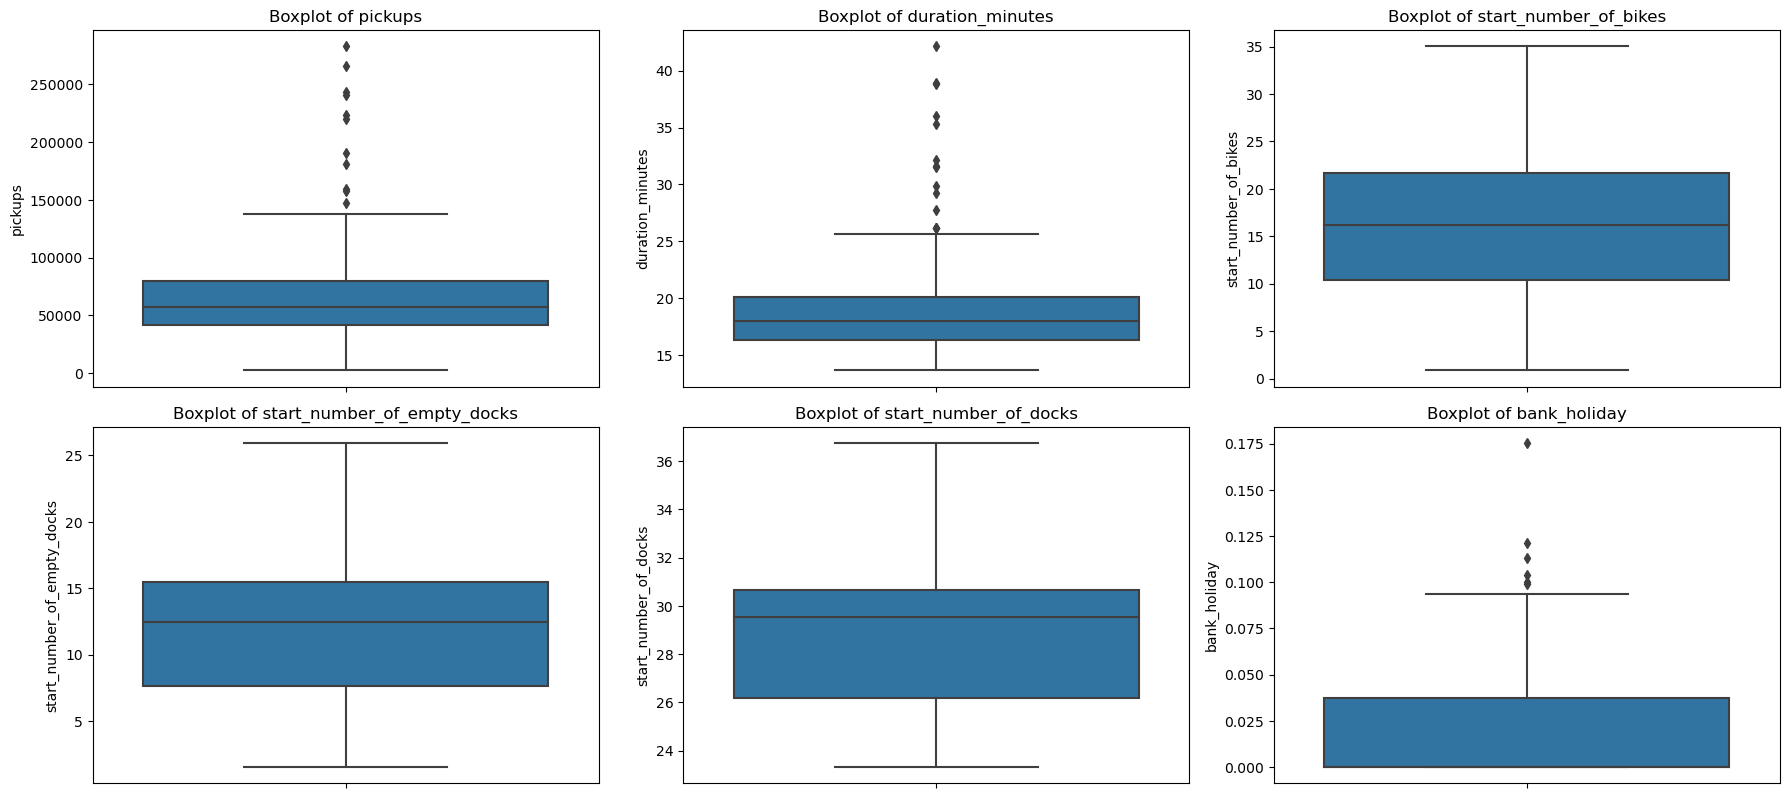

In [ ]:
features = ['pickups', 'duration_minutes','start_number_of_bikes','start_number_of_empty_docks','start_number_of_docks','bank_holiday']

# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(18, 12))

for i, feature in enumerate(features):
    ax = fig.add_subplot(3, 3, i+1)
    sns.boxplot(y=pickups_merged[feature], ax=ax)
    ax.set_title(f'Boxplot of {feature}')

# Show the figure
plt.tight_layout()
plt.show()

In [ ]:
pickups_merged[features].describe()

pickups  duration_minutes  start_number_of_bikes  \
count     144.000000        144.000000             144.000000   
mean    69021.868056         19.334903              16.161168   
std     50739.232365          5.142204               8.645326   
min      2290.000000         13.664749               0.866908   
25%     41396.250000         16.336326              10.429797   
50%     57134.500000         17.972670              16.220483   
75%     79934.250000         20.100994              21.705593   
max    283011.000000         42.135860              35.025141   

       start_number_of_empty_docks  start_number_of_docks  bank_holiday  
count                   144.000000             144.000000    144.000000  
mean                     12.617128              28.778295      0.020961  
std                       6.489917               3.441899      0.031915  
min                       1.553797              23.327775      0.000000  
25%                       7.626325              26.186691      0.000000  
50%                      12.439008              29.538602      0.000000  
75%                      15.491020              30.676532      0.037530  
max                      25.943903              36.755930      0.175457

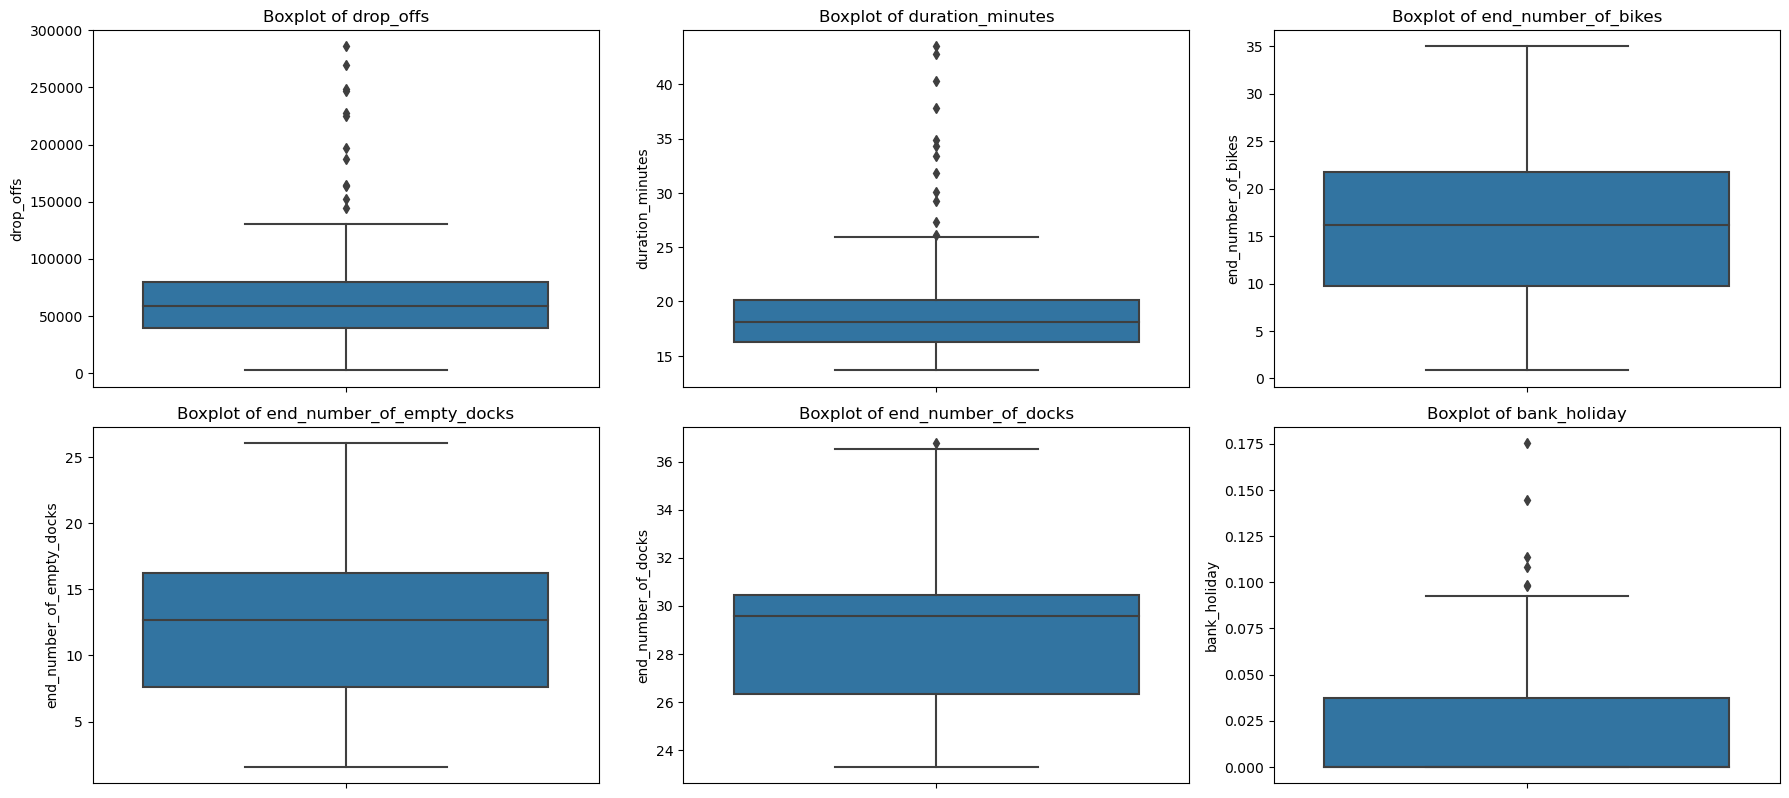

In [ ]:
features = ['drop_offs', 'duration_minutes','end_number_of_bikes','end_number_of_empty_docks','end_number_of_docks','bank_holiday']

# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(18, 12))

for i, feature in enumerate(features):
    ax = fig.add_subplot(3, 3, i+1)
    sns.boxplot(y=droppoffs_merged[feature], ax=ax)
    ax.set_title(f'Boxplot of {feature}')

# Show the figure
plt.tight_layout()
plt.show()

In [ ]:
droppoffs_merged[features].describe()

drop_offs  duration_minutes  end_number_of_bikes  \
count     144.000000        144.000000           144.000000   
mean    69021.868056         19.428214            15.915076   
std     51947.565556          5.434119             8.678758   
min      2295.000000         13.661838             0.860474   
25%     39772.750000         16.234884             9.740734   
50%     58205.000000         18.108089            16.174163   
75%     79930.000000         20.157043            21.784584   
max    286047.000000         43.493788            34.972910   

       end_number_of_empty_docks  end_number_of_docks  bank_holiday  
count                 144.000000           144.000000    144.000000  
mean                   12.887880            28.802956      0.021165  
std                     6.598052             3.436217      0.032502  
min                     1.565409            23.288068      0.000000  
25%                     7.591814            26.321823      0.000000  
50%                    12.707702            29.559265      0.000000  
75%                    16.207390            30.459868      0.037430  
max                    26.058667            36.778703      0.175369

In [ ]:


# Function to detect outliers in every feature
def detect_outliers(df):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df:
        if df[col].dtype.kind in 'bifc':
            Q1 = np.percentile(df[col], 25)
            Q3 = np.percentile(df[col], 75)
            IQR = Q3 - Q1
            
            # outlier step
            outlier_step = 1.5 * IQR
            
            # Determine a list of indices of outliers for feature col
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
            
            # append the found outlier indices for col to the list of outlier indices 
            outlier_indices.extend(outlier_list_col)
            
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers

# Re-run the outlier detection
outliers_to_drop = detect_outliers(pickups_merged)

outliers_to_drop_dropoff = detect_outliers(droppoffs_merged)

print(len(outliers_to_drop),len(outliers_to_drop_dropoff))

108 108


### outliers will be kept as it shows real world data

### Let's generate descriptive statistics for some of these key variables:

Demographics: "% of all people aged 16+ who are female", "% of all people aged 16+ who are male", "% of all 16+ who are aged 16-19", "% of all 16+ who are aged 20-24", "% of all 16+ who are aged 25-34", "% of all 16+ who are aged 35-49", "% of all 16+ who are aged 50-64", "% of all 16+ who are aged 65+".

Employment: "Employment rate - aged 16+", "Unemployment rate - aged 16+", "% in employment who are employees - aged 16+", "% in employment who are self employed - aged 16+".

Income: "total_hourly_mean_pay", "total_annual_mean_pay", "total_weekly_mean_pay","total_hourly_median_pay", 
                 "total_annual_median_pay", 
                 "total_weekly_median_pay",.

Bike sharing usage: "end_month", "drop-offs", "duration_minutes","start_number_of_bikes", "start_number_of_empty_docks", "start_number_of_docks","bank_holiday".

Indices of Deprevation: 'Income - Average rank ','Income - Rank of average rank ',	'Income - Average score ', 'Income - Rank of average score '

In [49]:
pickups_merged.head()

start_month start_borough_code start_borough_name  pickups  \
0            1          E09000001     City of London    56335   
1            2          E09000001     City of London    52799   
2            3          E09000001     City of London    59491   
3            4          E09000001     City of London    61914   
4            5          E09000001     City of London    66408   

   duration_minutes  bank_holiday  start_number_of_bikes  \
0         13.813065      0.012035               0.895181   
1         14.743669      0.000000               0.887630   
2         14.468121      0.000000               0.882621   
3         15.911119      0.039216               0.883645   
4         16.036321      0.026397               0.871838   

   start_number_of_docks  start_number_of_empty_docks  average_house_price  \
0              26.629449                    25.734268          865636.1043   
1              26.629936                    25.742306          894519.9090   
2              26.617488                    25.734867          853451.0753   
3              26.646574                    25.762929          738796.7242   
4              26.522241                    25.650404          719217.5584   

        temp  feelslike   humidity  windspeed  cloudcover   uvindex  \
0   5.453235   3.414801  75.987020  12.222070   73.279421  0.181930   
1   9.875306   8.773280  73.485954  13.488805   55.195678  0.473967   
2  10.672241   9.713774  67.424379  17.773608   66.527641  0.892908   
3  12.476939  11.830588  59.732989  14.434551   64.179379  1.687809   
4  15.543156  15.481517  57.148522  13.297116   70.400699  1.561574   

   % of all people aged 16+ who are female  \
0                                     46.4   
1                                     46.4   
2                                     46.4   
3                                     46.4   
4                                     46.4   

   % of all people aged 16+ who are male  % of all 16+ who are aged 16-19  \
0                                   53.6                              NaN   
1                                   53.6                              NaN   
2                                   53.6                              NaN   
3                                   53.6                              NaN   
4                                   53.6                              NaN   

   % of all 16+ who are aged 20-24  % of all 16+ who are aged 25-34  \
0                              NaN                             45.4   
1                              NaN                             45.4   
2                              NaN                             45.4   
3                              NaN                             45.4   
4                              NaN                             45.4   

   % of all 16+ who are aged 35-49  % of all 16+ who are aged 50-64  \
0                              NaN                             23.4   
1                              NaN                             23.4   
2                              NaN                             23.4   
3                              NaN                             23.4   
4                              NaN                             23.4   

   % of all 16+ who are aged 65+  \
0                           31.1   
1                           31.1   
2                           31.1   
3                           31.1   
4                           31.1   

   % in employment who are employees - aged 16+  \
0                                          73.0   
1                                          73.0   
2                                          73.0   
3                                          73.0   
4                                          73.0   

   % in employment who are self employed - aged 16+  \
0                                              27.0   
1                                              27.0   
2                                              27.0   
3                

In [51]:
key_variables = ["start_month", "pickups", "start_number_of_bikes", "start_number_of_empty_docks", "start_number_of_docks", "duration_minutes", 
                 "bank_holiday", "temp", "humidity", "windspeed",'cloudcover',
                 "% of all people aged 16+ who are female", 
                 "% of all people aged 16+ who are male", 
                 "% of all 16+ who are aged 16-19", 
                 "% of all 16+ who are aged 20-24", 
                 "% of all 16+ who are aged 25-34", 
                 "% of all 16+ who are aged 35-49", 
                 "% of all 16+ who are aged 50-64", 
                 "% of all 16+ who are aged 65+",
                 "Employment rate - aged 16+", 
                 "Unemployment rate - aged 16+", 
                 "% in employment who are employees - aged 16+", 
                 "% in employment who are self employed - aged 16+",
                 "total_hourly_mean_pay", 
                 "total_annual_mean_pay", 
                 "total_weekly_mean_pay",
                 "total_hourly_median_pay", 
                 "total_annual_median_pay", 
                 "total_weekly_median_pay",
                 'Income - Average rank ','Income - Rank of average rank ',	'Income - Average score ', 'Income - Rank of average score ',
                 'Employment - Average rank ',	'Employment - Rank of average rank ',	'Employment - Average score ',	'Employment - Rank of average score '
                 ]

# Generate descriptive statistics for these key variables
pickups_merged[key_variables].describe(include='all')

start_month        pickups  start_number_of_bikes  \
count   144.000000     144.000000             144.000000   
mean      6.500000   69024.958333              16.161174   
std       3.464102   50740.534195               8.645316   
min       1.000000    2290.000000               0.866908   
25%       3.750000   41396.250000              10.429797   
50%       6.500000   57134.500000              16.220483   
75%       9.250000   79934.250000              21.705593   
max      12.000000  283011.000000              35.025141   

       start_number_of_empty_docks  start_number_of_docks  duration_minutes  \
count                   144.000000             144.000000        144.000000   
mean                     12.617106              28.778280         19.335359   
std                       6.489920               3.441878          5.142272   
min                       1.553797              23.327775         13.664749   
25%                       7.626325              26.186691         16.336326   
50%                      12.439008              29.538602         17.972670   
75%                      15.491020              30.676532         20.100994   
max                      25.943903              36.755930         42.135860   

       bank_holiday        temp    humidity   windspeed  cloudcover  \
count    144.000000  144.000000  144.000000  144.000000  144.000000   
mean       0.020961   13.185409   69.579327   14.201975   63.807015   
std        0.031915    5.119510    9.169703    1.678446    6.216540   
min        0.000000    4.905445   52.771554   11.241747   45.913473   
25%        0.000000    8.262262   61.676295   12.949161   58.846978   
50%        0.000000   12.345814   67.110164   13.799623   63.978897   
75%        0.037530   17.721003   77.567272   15.373025   68.931215   
max        0.175457   22.318194   85.991899   18.256312   76.381572   

       % of all people aged 16+ who are female  \
count                               144.000000   
mean                                 49.216667   
std                                   2.020662   
min                                  46.100000   
25%                                  48.450000   
50%                                  49.100000   
75%                                  50.050000   
max                                  54.200000   

       % of all people aged 16+ who are male  % of all 16+ who are aged 16-19  \
count                             144.000000                       132.000000   
mean                               50.783333                         4.872727   
std                                 2.020662                         1.454086   
min                                45.800000                         3.100000   
25%                                49.950000                         3.600000   
50%                                50.900000                         4.700000   
75%                                51.550000                         6.500000   
max                                53.900000                         7.400000   

       % of all 16+ who are aged 20-24  % of all 16+ who are aged 25-34  \
count                       132.000000                       144.000000   
mean                          8.881818                        29.450000   
std                           2.457635                         7.963536   
min                           3.700000                        13.000000   
25%                           8.200000                        25.625000   
50%                           8.800000                        30.150000   
75%                          10.200000                        34.125000   
max                          14.400000                        45.400000   

       % of all 16+ who are aged 35-49  % of all 16+ who are aged 50-64  \
count                       132.000000                       144.000000   
mean                         28.490909                        18.408333   
std                           1.

In [ ]:
key_variables = ["end_month", "drop_offs", "end_number_of_bikes", "end_number_of_empty_docks", "end_number_of_docks", "duration_minutes", 
                 "bank_holiday",
                 "% of all people aged 16+ who are female", 
                 "% of all people aged 16+ who are male", 
                 "% of all 16+ who are aged 16-19", 
                 "% of all 16+ who are aged 20-24", 
                 "% of all 16+ who are aged 25-34", 
                 "% of all 16+ who are aged 35-49", 
                 "% of all 16+ who are aged 50-64", 
                 "% of all 16+ who are aged 65+",
                 "Employment rate - aged 16+", 
                 "Unemployment rate - aged 16+", 
                 "% in employment who are employees - aged 16+", 
                 "% in employment who are self employed - aged 16+",
                 "total_hourly_mean_pay", 
                 "total_annual_mean_pay", 
                 "total_weekly_mean_pay",
                 "total_hourly_median_pay", 
                 "total_annual_median_pay", 
                 "total_weekly_median_pay",
                 'Income - Average rank ','Income - Rank of average rank ',	'Income - Average score ', 'Income - Rank of average score ',
                 'Employment - Average rank ',	'Employment - Rank of average rank ',	'Employment - Average score ',	'Employment - Rank of average score '
                 ]

droppoffs_merged[key_variables].describe(include='all')

end_month      drop_offs  end_number_of_bikes  \
count  144.000000     144.000000           144.000000   
mean     6.500000   69021.868056            15.915076   
std      3.464102   51947.565556             8.678758   
min      1.000000    2295.000000             0.860474   
25%      3.750000   39772.750000             9.740734   
50%      6.500000   58205.000000            16.174163   
75%      9.250000   79930.000000            21.784584   
max     12.000000  286047.000000            34.972910   

       end_number_of_empty_docks  end_number_of_docks  duration_minutes  \
count                 144.000000           144.000000        144.000000   
mean                   12.887880            28.802956         19.428214   
std                     6.598052             3.436217          5.434119   
min                     1.565409            23.288068         13.661838   
25%                     7.591814            26.321823         16.234884   
50%                    12.707702            29.559265         18.108089   
75%                    16.207390            30.459868         20.157043   
max                    26.058667            36.778703         43.493788   

       bank_holiday  % of all people aged 16+ who are female  \
count    144.000000                               144.000000   
mean       0.021165                                49.216667   
std        0.032502                                 2.020662   
min        0.000000                                46.100000   
25%        0.000000                                48.450000   
50%        0.000000                                49.100000   
75%        0.037430                                50.050000   
max        0.175369                                54.200000   

       % of all people aged 16+ who are male  % of all 16+ who are aged 16-19  \
count                             144.000000                       144.000000   
mean                               50.783333                         4.466667   
std                                 2.020662                         1.939937   
min                                45.800000                         0.000000   
25%                                49.950000                         3.500000   
50%                                50.900000                         4.500000   
75%                                51.550000                         5.750000   
max                                53.900000                         7.400000   

       % of all 16+ who are aged 20-24  % of all 16+ who are aged 25-34  \
count                       144.000000                       144.000000   
mean                          8.141667                        29.450000   
std                           3.406072                         7.963536   
min                           0.000000                        13.000000   
25%                           7.875000                        25.625000   
50%                           8.700000                        30.150000   
75%                           9.525000                        34.125000   
max                          14.400000                        45.400000   

       % of all 16+ who are aged 35-49  % of all 16+ who are aged 50-64  \
count                       144.000000                       144.000000   
mean                         26.116667                        18.408333   
std                           8.109961                         4.237388   
min                           0.000000                         9.500000   
25%                          26.900000                        16.750000   
50%                          28.300000                        17.650000   
75%                          30.125000                        20.925000   
max                          30.700000                        24.500000   

       % of all 16+ who are aged 65+  Employment rate - aged 16+  \
count                     144.000000                  144.000000   
mean                   

# Correlation analysis

<Axes: >

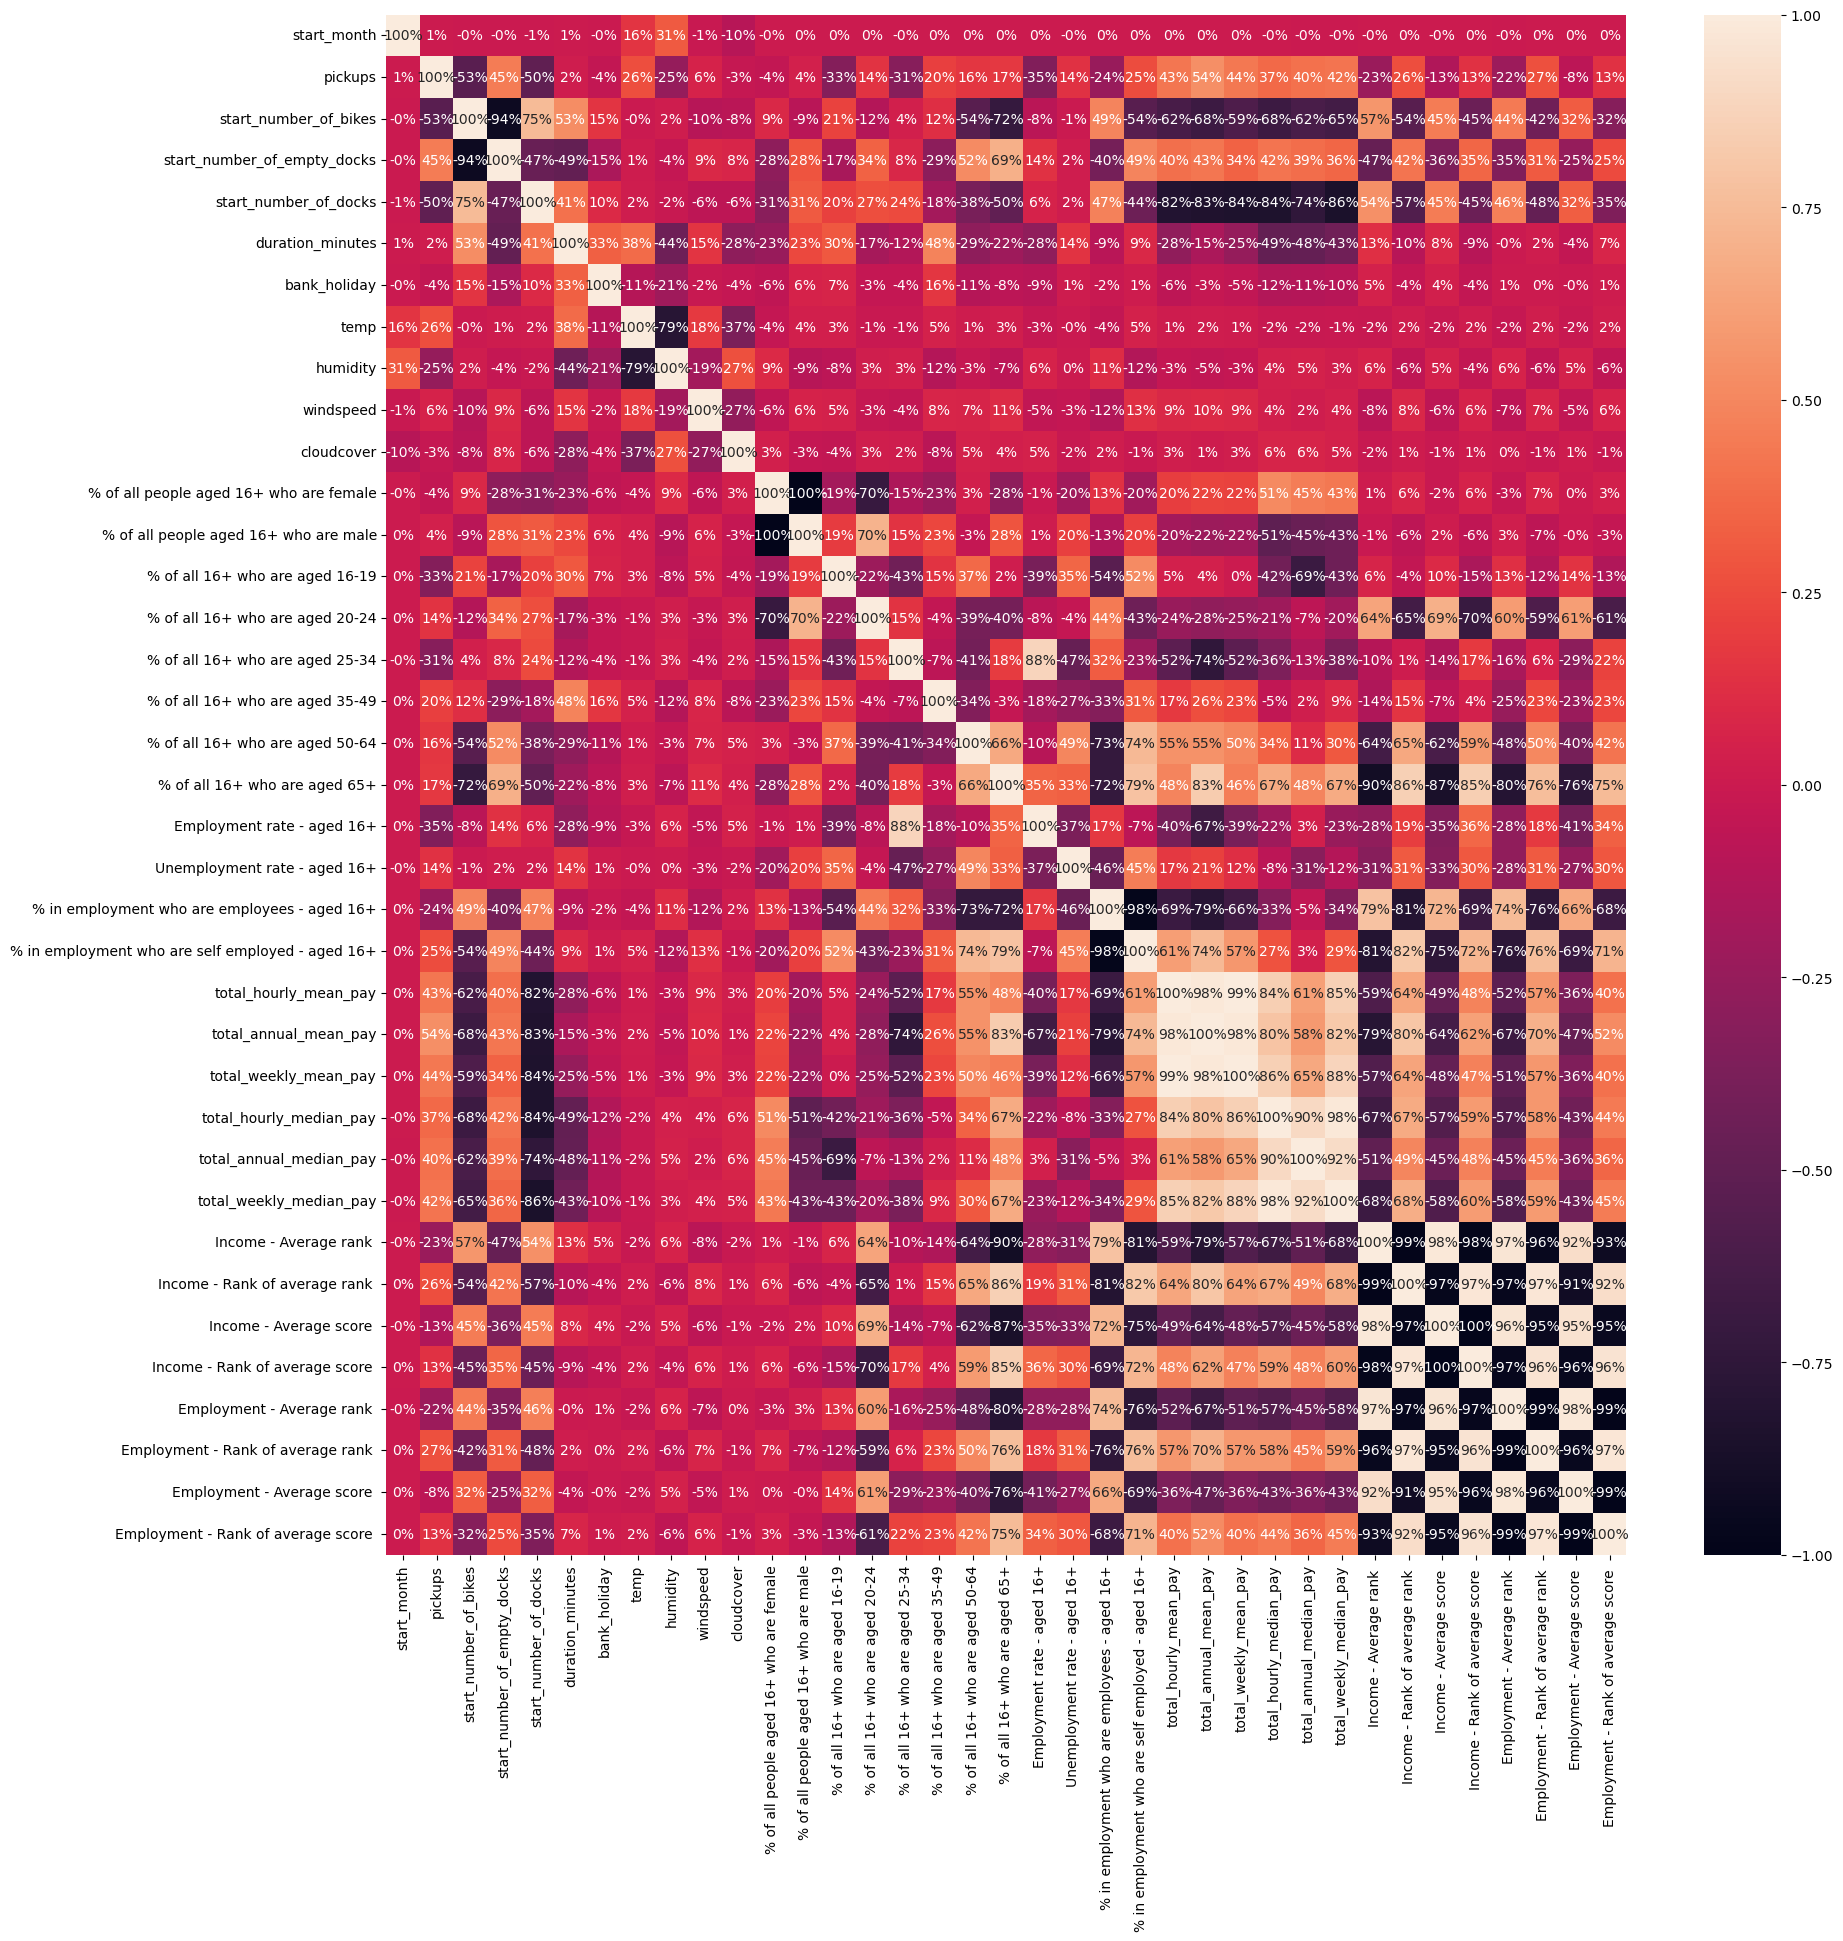

In [52]:
# plot correlation matrix heat map for key_variables
plt.figure(figsize=(20,20))
sns.heatmap(pickups_merged[key_variables].corr(), annot=True, fmt='.0%')


In [ ]:
# Plot
plt.figure(figsize=(10, 20))  # Adjust as needed
corr_matrix.plot(kind='barh')
plt.title('Correlation with Pickups')
plt.xlabel('Correlation')
plt.ylabel('Variable')
plt.show()

In [57]:
# calculate correlation between pickups and other variables and print values greater than 0.5
correlation = pickups_merged.corr()
correlation[correlation['pickups'] > 0.5]['pickups']


/var/folders/pz/y4y03t6d7cd_76njhx8sjzzm0000gn/T/ipykernel_13852/3704695404.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = pickups_merged.corr()


pickups                                                                                            1.000000
% in employment working part-time - aged 16-19                                                     0.607080
female_full_time_hourly_mean_pay                                                                   0.667691
female_full_time_annual_mean_pay                                                                   0.798735
total_annual_mean_pay                                                                              0.536764
full_time_annual_mean_pay                                                                          0.532714
female_full_time_weekly_mean_pay                                                                   0.663922
male_full_time_annual_median_pay                                                                   0.562382
female_full_time_annual_median_pay                                                                 0.506845
full_time_annual_median_pay 

In [63]:
# calculate correlation between pickups and other variables and print values greater than 0.5
correlation = pickups_merged_mean_fill.corr()
correlation[correlation['pickups'] > 0.5]['pickups']

/var/folders/pz/y4y03t6d7cd_76njhx8sjzzm0000gn/T/ipykernel_13852/2494198635.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = pickups_merged_mean_fill.corr()


pickups                                                                                            1.000000
female_full_time_hourly_mean_pay                                                                   0.667691
female_full_time_annual_mean_pay                                                                   0.798735
total_annual_mean_pay                                                                              0.535537
full_time_annual_mean_pay                                                                          0.531496
female_full_time_weekly_mean_pay                                                                   0.663922
Employment - Proportion  of LSOAs in most deprived 10% nationally                                  0.517155
Barriers to Housing and Services - Rank of average score                                           0.531941
Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally     0.534856
Name: pickups, dtype: float6

# Exploratory Data Analysis

In [ ]:

["start_month", "pickups", "start_number_of_bikes", "start_number_of_empty_docks", "start_number_of_docks", "duration_minutes", 
                 "bank_holiday",
                 "% of all people aged 16+ who are female", 
                 "% of all people aged 16+ who are male", 
                 "% of all 16+ who are aged 16-19", 
                 "% of all 16+ who are aged 20-24", 
                 "% of all 16+ who are aged 25-34", 
                 "% of all 16+ who are aged 35-49", 
                 "% of all 16+ who are aged 50-64", 
                 "% of all 16+ who are aged 65+",
                 "Employment rate - aged 16+", 
                 "Unemployment rate - aged 16+", 
                 "% in employment who are employees - aged 16+", 
                 "% in employment who are self employed - aged 16+",
                 'female_full_time_weekly_mean_pay',
                  'female_full_time_annual_mean_pay',
                  'female_full_time_hourly_mean_pay',
                  'male_part_time_hourly_mean_pay',
                  'female_part_time_annual_mean_pay',
                  'part_time_annual_mean_pay',
                  'male_part_time_weekly_mean_pay',
                  'male_full_time_annual_median_pay',
                 "total_hourly_mean_pay", 
                 "total_annual_mean_pay", 
                 "total_weekly_mean_pay",
                 "total_hourly_median_pay", 
                 "total_annual_median_pay", 
                 "total_weekly_median_pay",
                 'Income - Average rank ','Income - Rank of average rank ',	'Income - Average score ', 'Income - Rank of average score ',
                 'Employment - Average rank ',	'Employment - Rank of average rank ',	'Employment - Average score ',	'Employment - Rank of average score ','Employment - Proportion  of LSOAs in most deprived 10% nationally'
                 ,'Barriers to Housing and Services - Average rank','Barriers to Housing and Services - Average score','Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally', 'Barriers to Housing and Services - Rank of average score','average_house_price']

Text(0, 0.5, 'Barriers to Housing and Services - Average rank ')

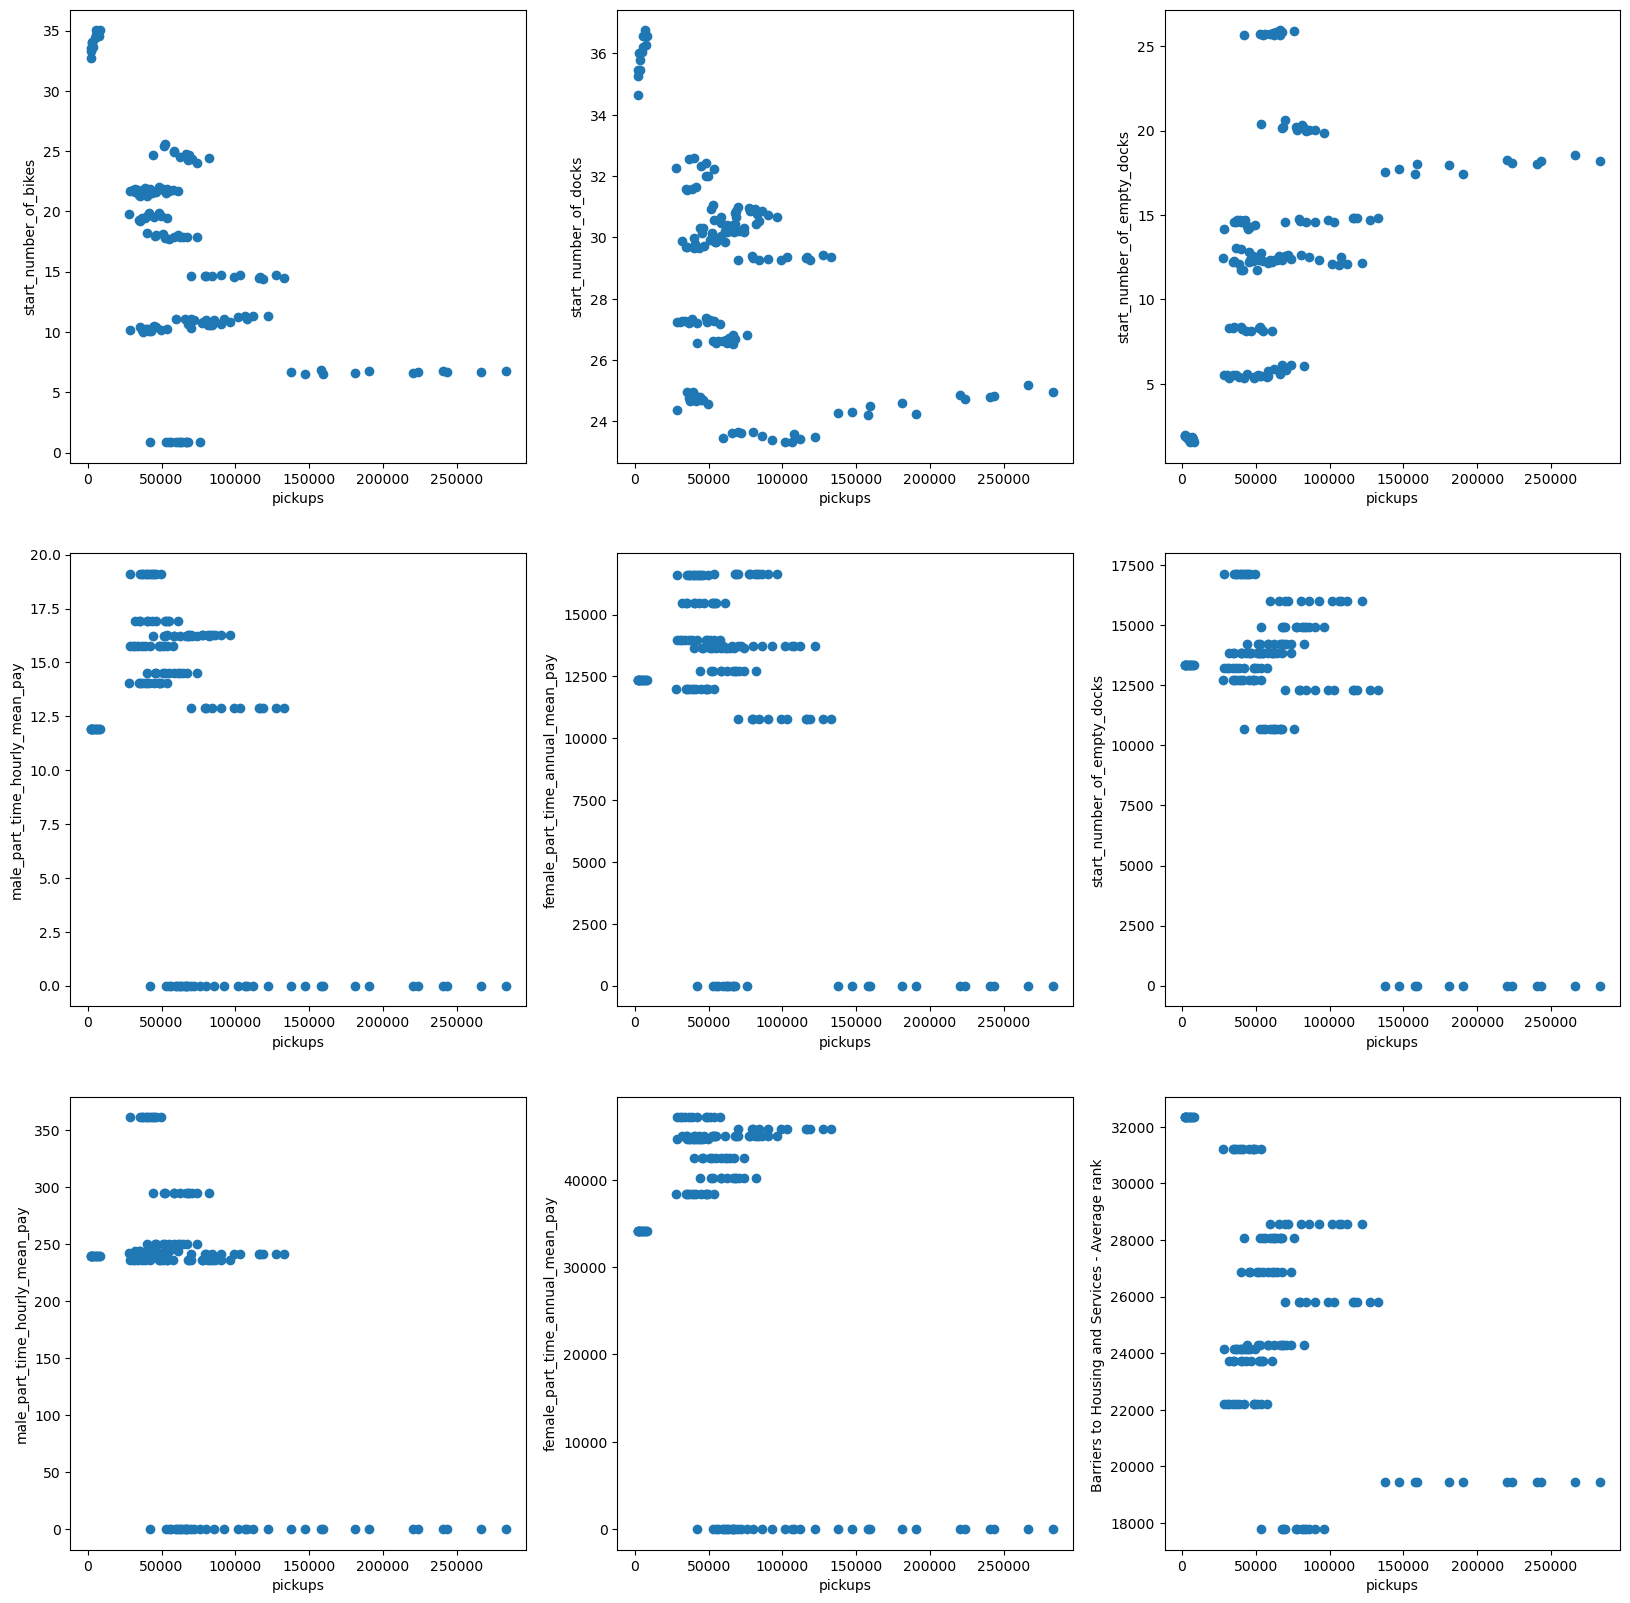

In [ ]:
# plot scatter plot for pickups vs male_part_time_hourly_mean_pay,female_part_time_annual_mean_pay ,part_time_annual_mean_pay,male_part_time_weekly_mean_pay,male_full_time_annual_median_pay,Barriers to Housing and Services - Average rank ,Barriers to Housing and Services - Average score   
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
plt.scatter(pickups_merged['pickups'], pickups_merged['start_number_of_bikes'])
plt.xlabel('pickups')
plt.ylabel('start_number_of_bikes')
plt.subplot(3,3,2)
plt.scatter(pickups_merged['pickups'], pickups_merged['start_number_of_docks'])
plt.xlabel('pickups')
plt.ylabel('start_number_of_docks')
plt.subplot(3,3,3)
plt.scatter(pickups_merged['pickups'], pickups_merged['start_number_of_empty_docks'])
plt.xlabel('pickups')
plt.ylabel('start_number_of_empty_docks')
plt.subplot(3,3,4)
plt.scatter(pickups_merged['pickups'], pickups_merged['male_part_time_hourly_mean_pay'])
plt.xlabel('pickups')
plt.ylabel('male_part_time_hourly_mean_pay')
plt.subplot(3,3,5)
plt.scatter(pickups_merged['pickups'], pickups_merged['female_part_time_annual_mean_pay'])
plt.xlabel('pickups')
plt.ylabel('female_part_time_annual_mean_pay')
plt.subplot(3,3,6)
plt.scatter(pickups_merged['pickups'], pickups_merged['part_time_annual_mean_pay'])
plt.xlabel('pickups')
plt.ylabel('start_number_of_empty_docks')
plt.subplot(3,3,7)
plt.scatter(pickups_merged['pickups'], pickups_merged['male_part_time_weekly_mean_pay'])
plt.xlabel('pickups')
plt.ylabel('male_part_time_hourly_mean_pay')
plt.subplot(3,3,8)
plt.scatter(pickups_merged['pickups'], pickups_merged['male_full_time_annual_median_pay'])
plt.xlabel('pickups')
plt.ylabel('female_part_time_annual_mean_pay')
plt.subplot(3,3,9)
plt.scatter(pickups_merged['pickups'], pickups_merged['Barriers to Housing and Services - Average rank '])
plt.xlabel('pickups')
plt.ylabel('Barriers to Housing and Services - Average rank ')



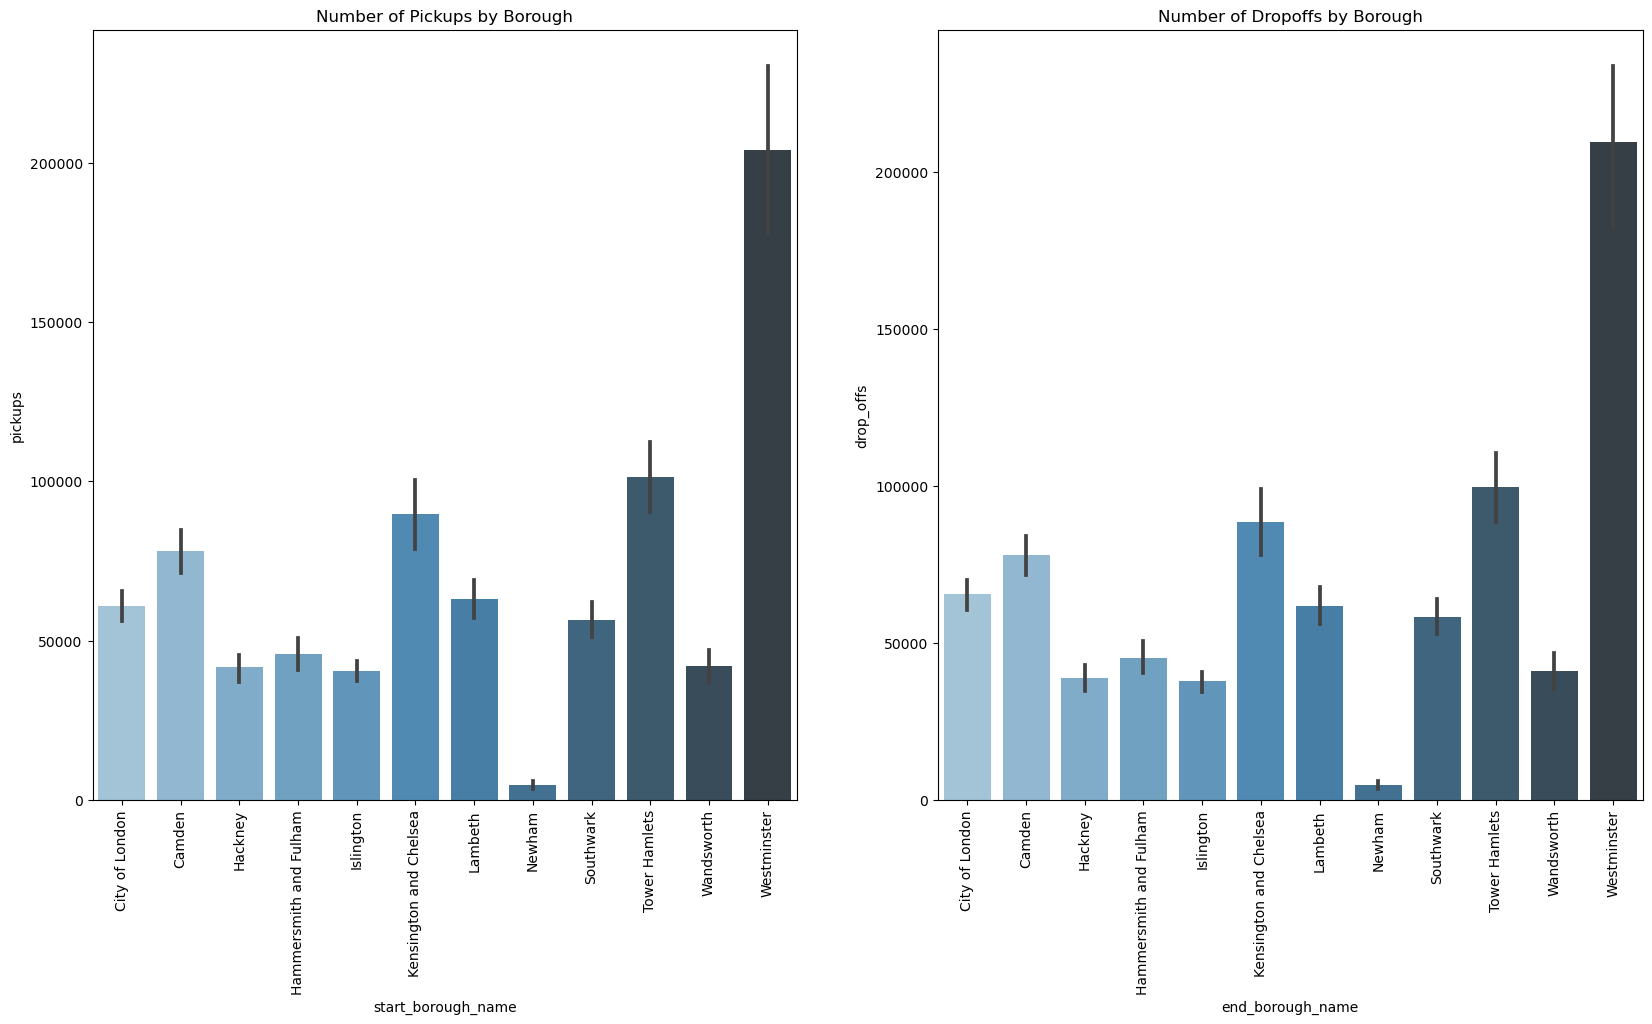

In [ ]:
# continue with borough level analysis and EDA
#plot number of pickups and dropoffs by borough 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x='start_borough_name', y='pickups', data=pickups_merged, palette='Blues_d')
plt.xticks(rotation=90)
plt.title('Number of Pickups by Borough')
plt.subplot(1,2,2)
sns.barplot(x='end_borough_name', y='drop_offs', data=droppoffs_merged, palette='Blues_d')  
plt.xticks(rotation=90)
plt.title('Number of Dropoffs by Borough')
plt.show()

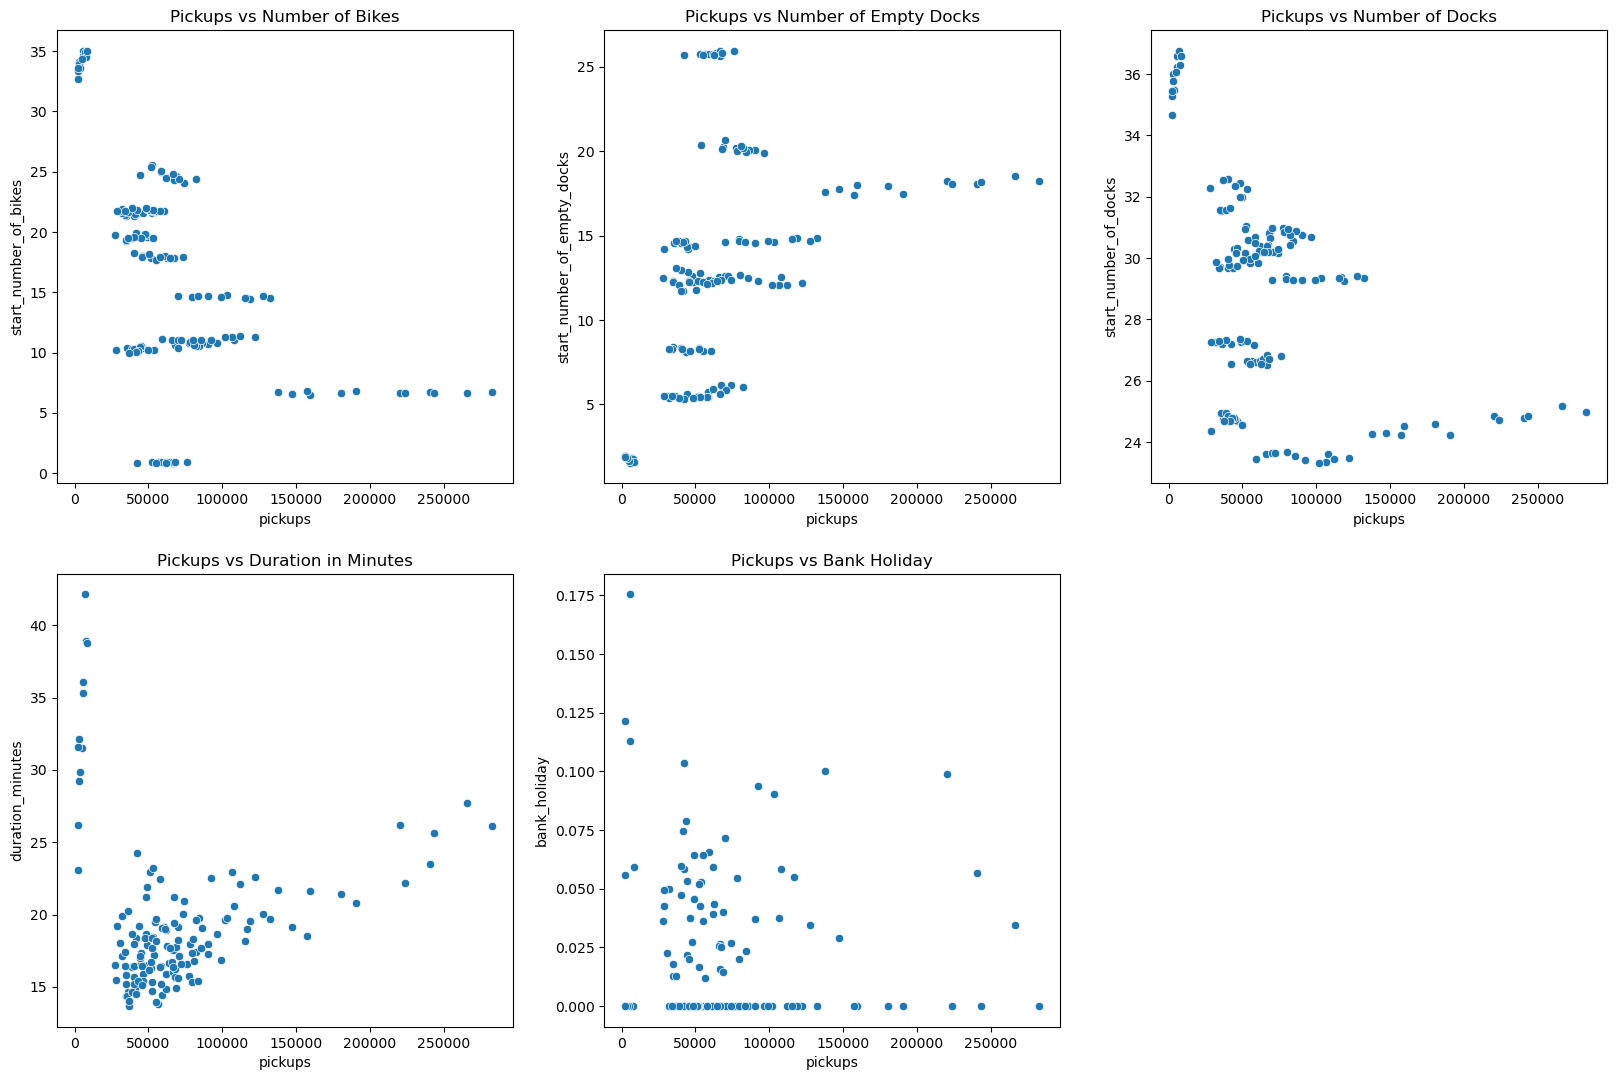

In [ ]:
# continue with borough level analysis and EDA
#plot scatter plot for pickups vs key_variables features
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.scatterplot(x='pickups', y='start_number_of_bikes', data=pickups_merged)
plt.title('Pickups vs Number of Bikes')
plt.subplot(3,3,2)
sns.scatterplot(x='pickups', y='start_number_of_empty_docks', data=pickups_merged)
plt.title('Pickups vs Number of Empty Docks')
plt.subplot(3,3,3)
sns.scatterplot(x='pickups', y='start_number_of_docks', data=pickups_merged)
plt.title('Pickups vs Number of Docks')
plt.subplot(3,3,4)
sns.scatterplot(x='pickups', y='duration_minutes', data=pickups_merged)
plt.title('Pickups vs Duration in Minutes')
plt.subplot(3,3,5)
sns.scatterplot(x='pickups', y='bank_holiday', data=pickups_merged)
plt.title('Pickups vs Bank Holiday')
plt.show()




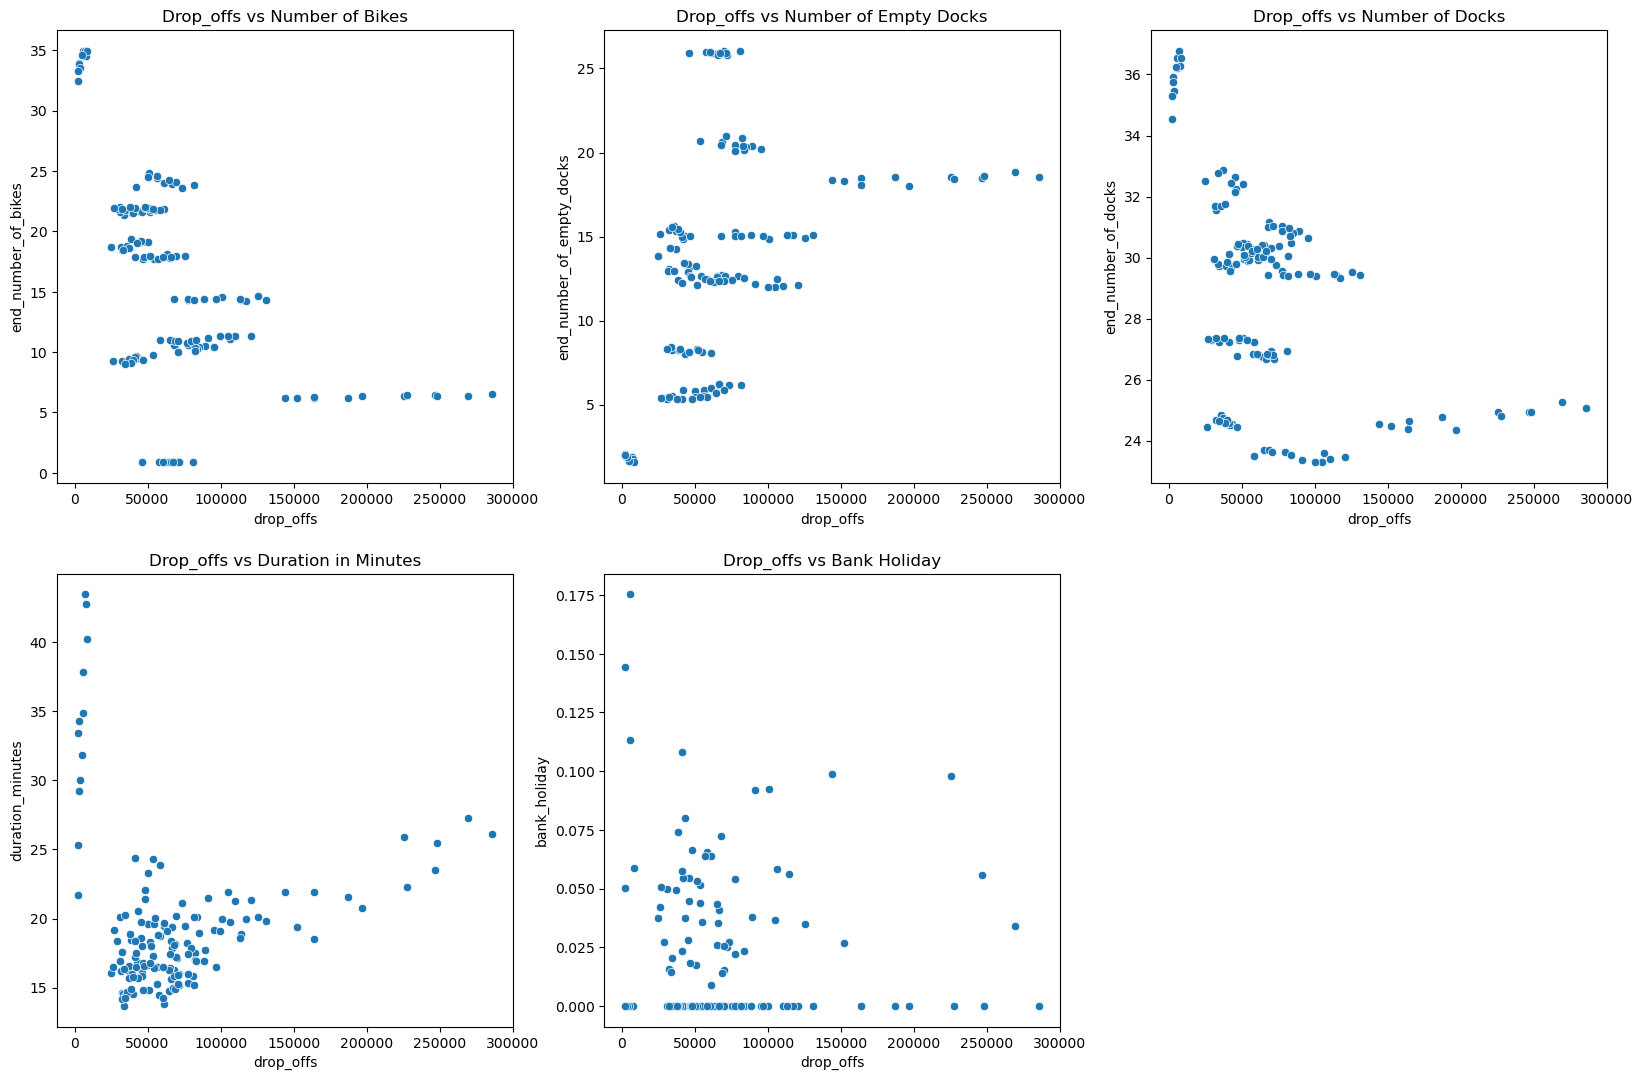

In [ ]:
#plot scatter plot for pickups vs key_variables features
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.scatterplot(x='drop_offs', y='end_number_of_bikes', data=droppoffs_merged)
plt.title('Drop_offs vs Number of Bikes')
plt.subplot(3,3,2)
sns.scatterplot(x='drop_offs', y='end_number_of_empty_docks', data=droppoffs_merged)
plt.title('Drop_offs vs Number of Empty Docks')
plt.subplot(3,3,3)
sns.scatterplot(x='drop_offs', y='end_number_of_docks', data=droppoffs_merged)
plt.title('Drop_offs vs Number of Docks')
plt.subplot(3,3,4)
sns.scatterplot(x='drop_offs', y='duration_minutes', data=droppoffs_merged)
plt.title('Drop_offs vs Duration in Minutes')
plt.subplot(3,3,5)
sns.scatterplot(x='drop_offs', y='bank_holiday', data=droppoffs_merged)
plt.title('Drop_offs vs Bank Holiday')
plt.show()




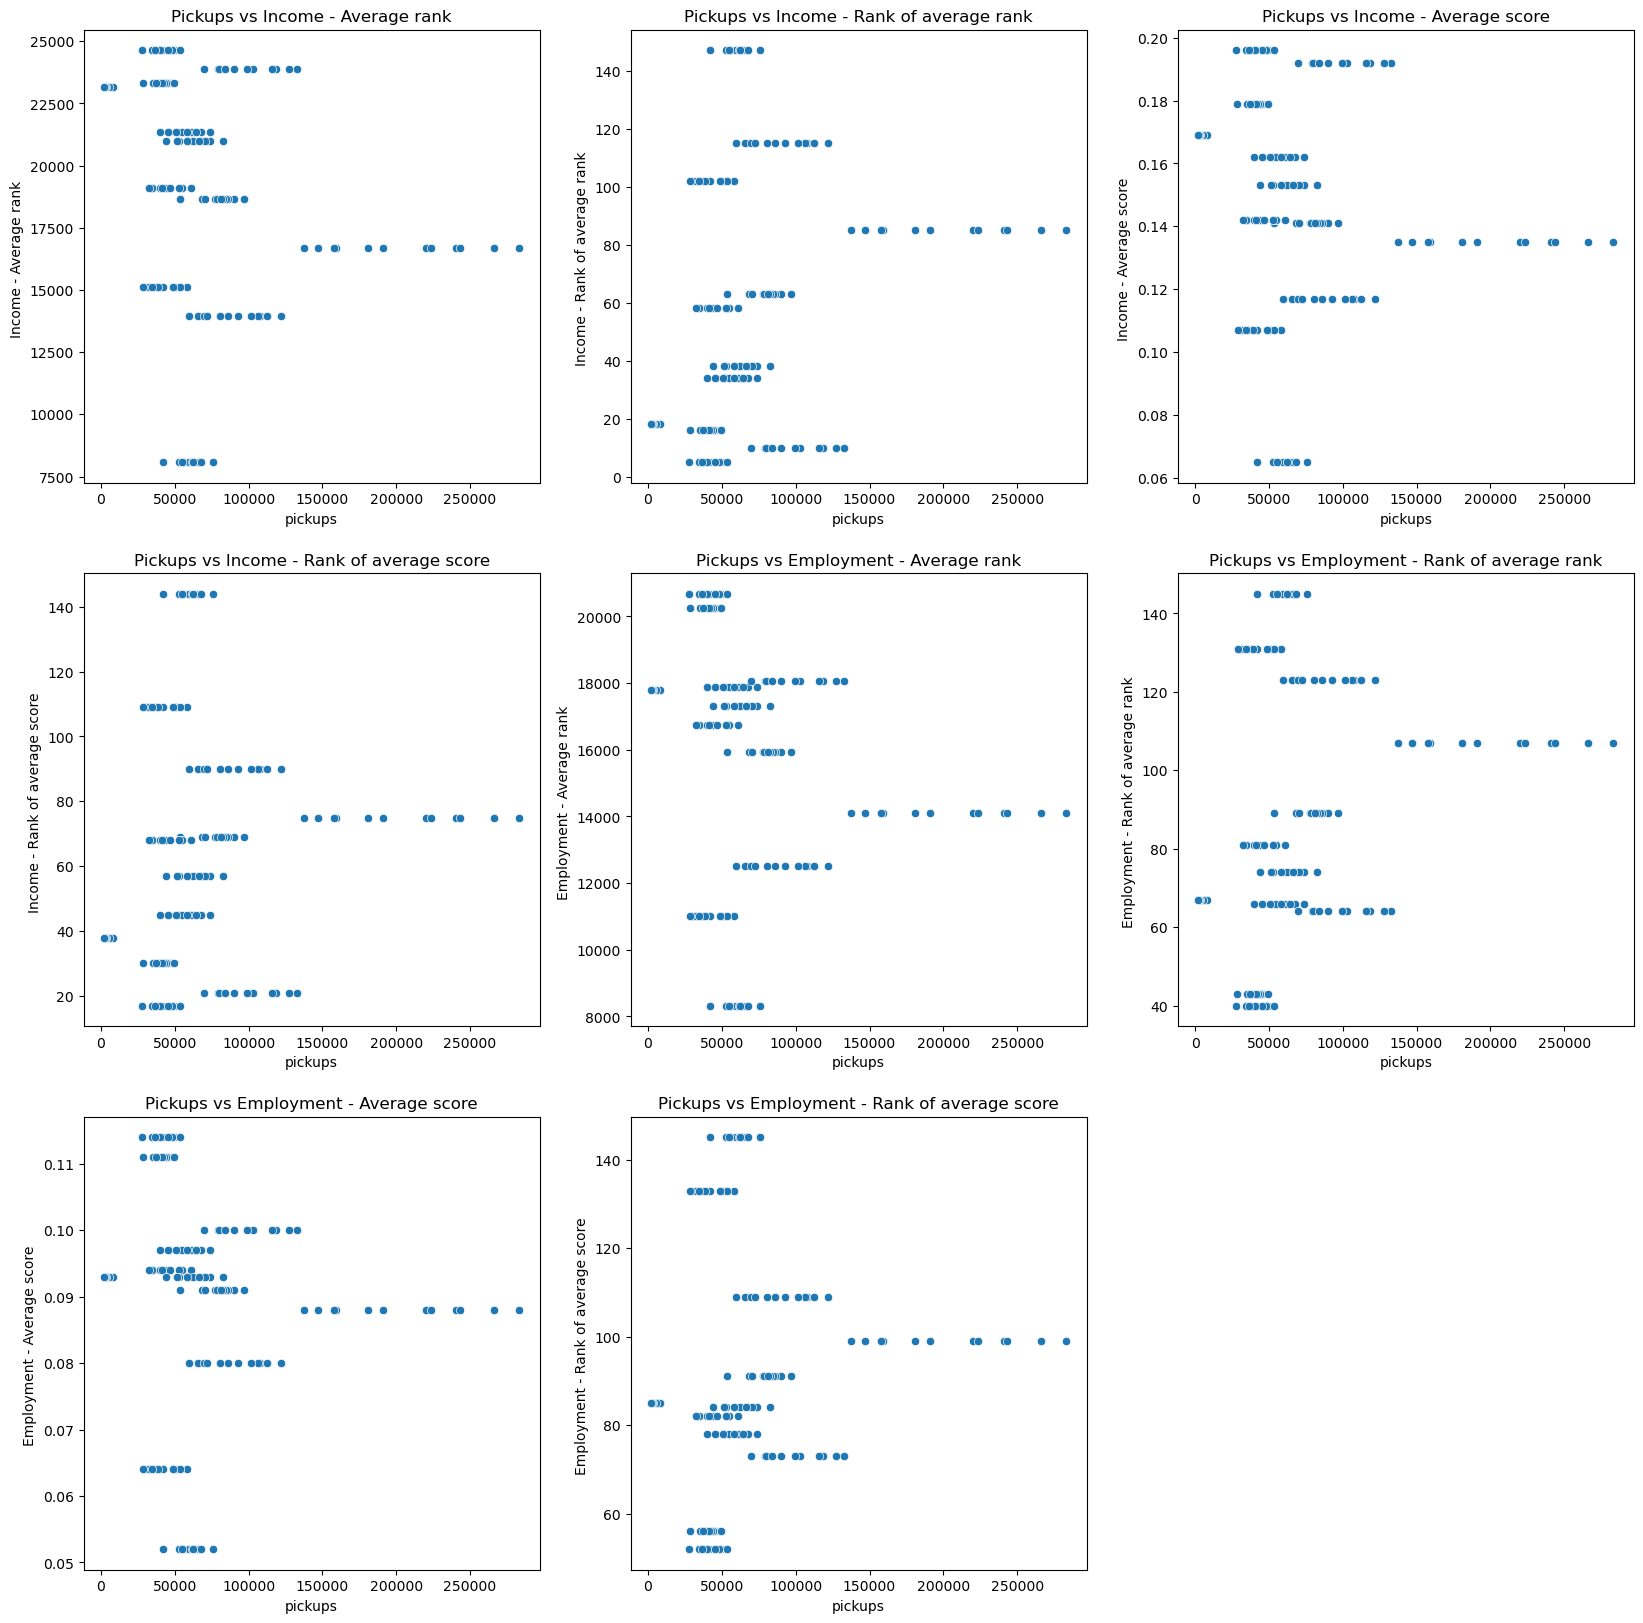

In [ ]:
# plot scatter plot pickups vs 'Income - Average rank ','Income - Rank of average rank ',	'Income - Average score ', 'Income - Rank of average score ', 'Employment - Average rank ',	'Employment - Rank of average rank ',	'Employment - Average score ',	'Employment - Rank of average score '
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.scatterplot(x='pickups', y='Income - Average rank ', data=pickups_merged)
plt.title('Pickups vs Income - Average rank')
plt.subplot(3,3,2)
sns.scatterplot(x='pickups', y='Income - Rank of average rank ', data=pickups_merged)
plt.title('Pickups vs Income - Rank of average rank')
plt.subplot(3,3,3)
sns.scatterplot(x='pickups', y='Income - Average score ', data=pickups_merged)
plt.title('Pickups vs Income - Average score')
plt.subplot(3,3,4)
sns.scatterplot(x='pickups', y='Income - Rank of average score ', data=pickups_merged)  
plt.title('Pickups vs Income - Rank of average score')
plt.subplot(3,3,5)
sns.scatterplot(x='pickups', y='Employment - Average rank ', data=pickups_merged)
plt.title('Pickups vs Employment - Average rank')
plt.subplot(3,3,6)
sns.scatterplot(x='pickups', y='Employment - Rank of average rank ', data=pickups_merged)
plt.title('Pickups vs Employment - Rank of average rank')
plt.subplot(3,3,7)
sns.scatterplot(x='pickups', y='Employment - Average score ', data=pickups_merged)
plt.title('Pickups vs Employment - Average score')
plt.subplot(3,3,8)
sns.scatterplot(x='pickups', y='Employment - Rank of average score ', data=pickups_merged)
plt.title('Pickups vs Employment - Rank of average score')
plt.show()

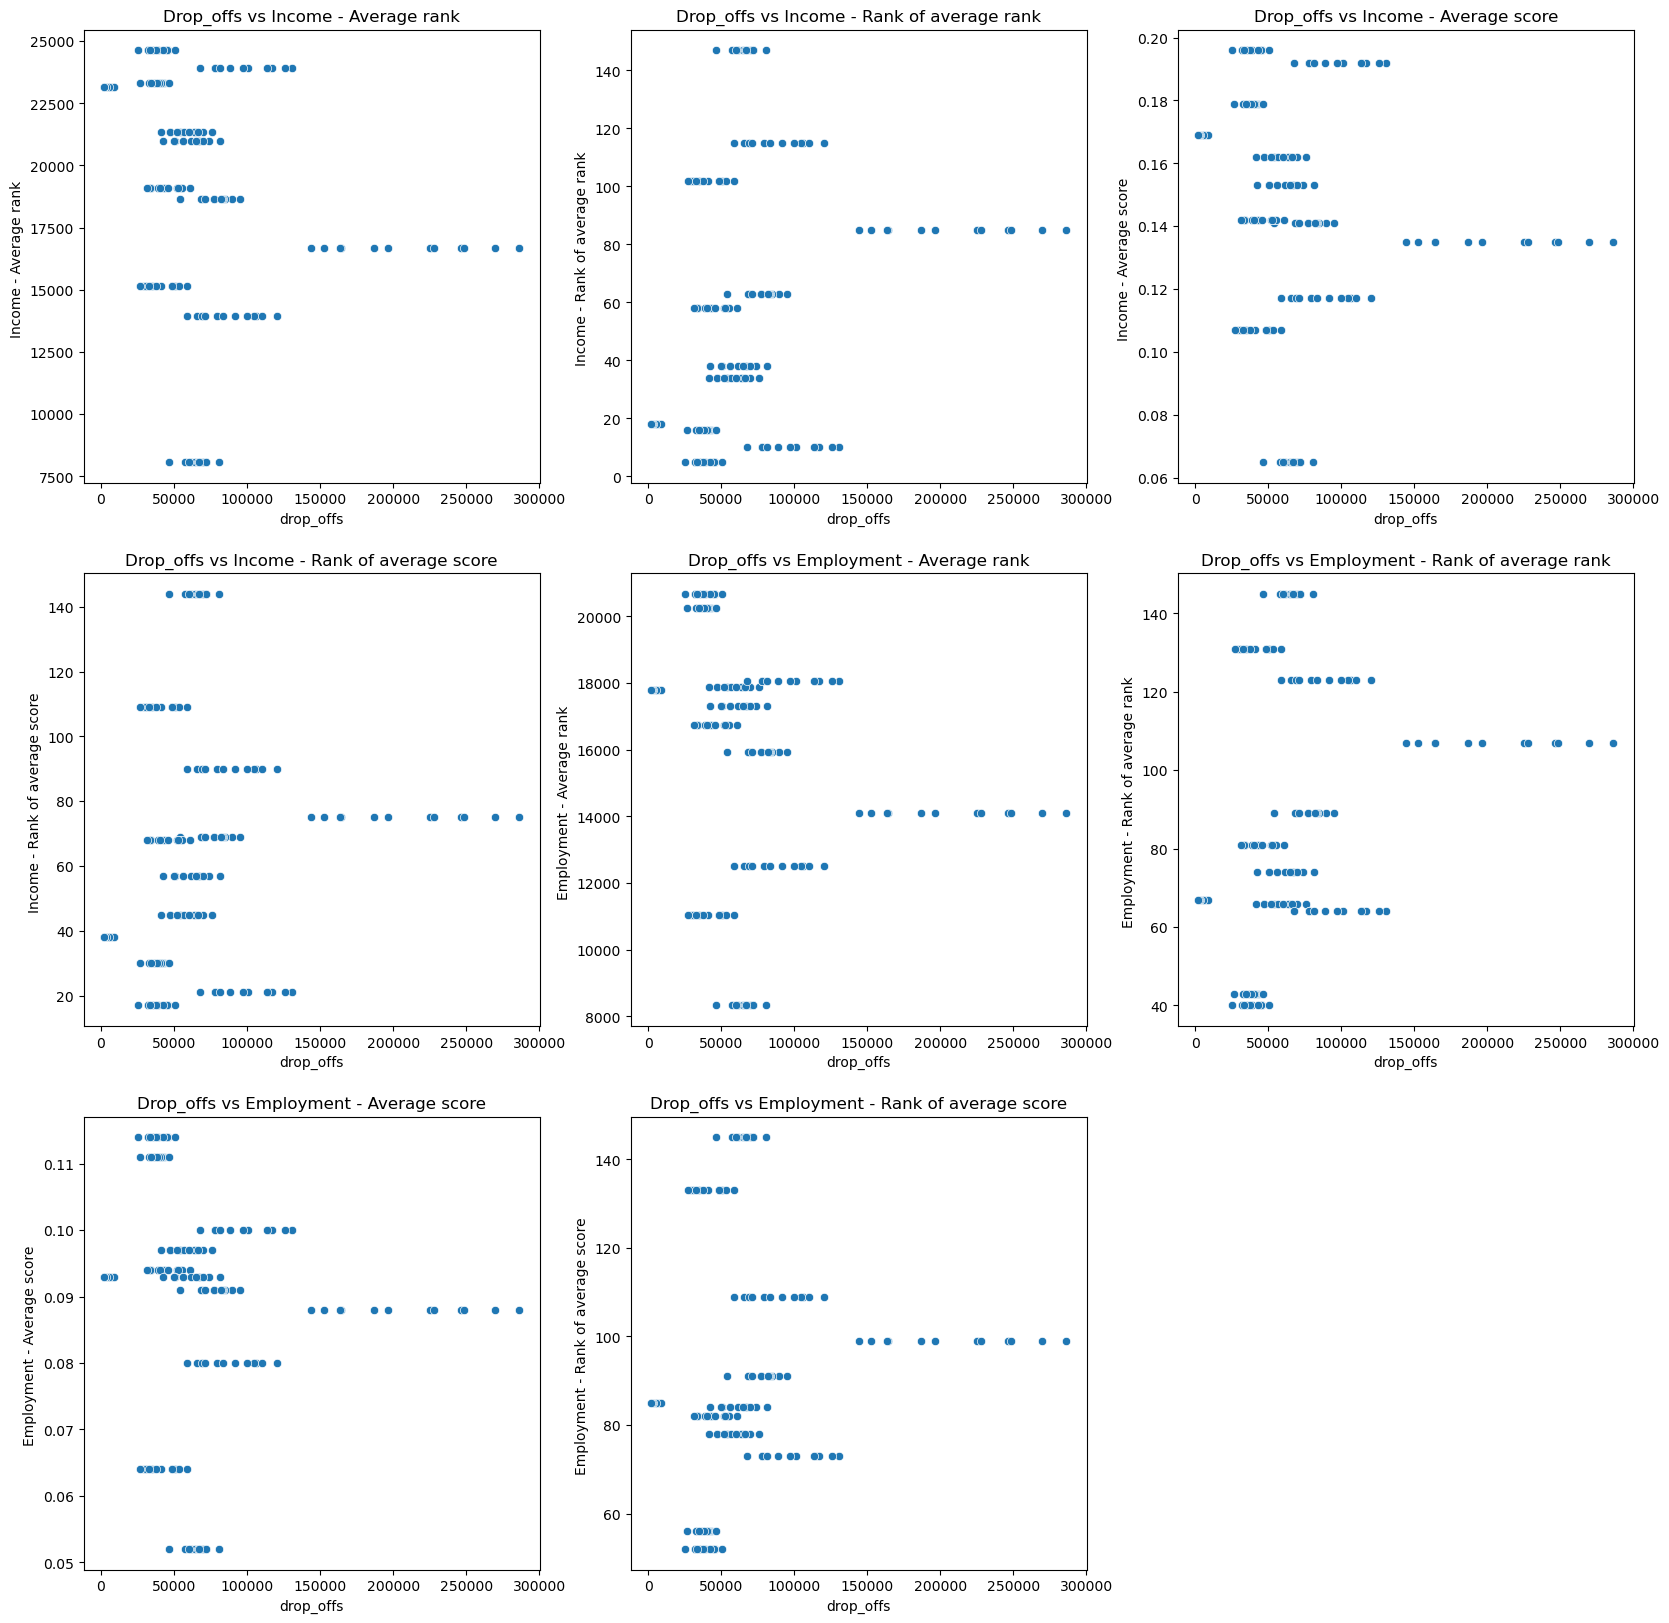

In [ ]:
# plot scatter plot drop_offs vs 'Income - Average rank ','Income - Rank of average rank ',	'Income - Average score ', 'Income - Rank of average score ', 'Employment - Average rank ',	'Employment - Rank of average rank ',	'Employment - Average score ',	'Employment - Rank of average score '
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.scatterplot(x='drop_offs', y='Income - Average rank ', data=droppoffs_merged)
plt.title('Drop_offs vs Income - Average rank')
plt.subplot(3,3,2)  
sns.scatterplot(x='drop_offs', y='Income - Rank of average rank ', data=droppoffs_merged)
plt.title('Drop_offs vs Income - Rank of average rank')
plt.subplot(3,3,3)
sns.scatterplot(x='drop_offs', y='Income - Average score ', data=droppoffs_merged)
plt.title('Drop_offs vs Income - Average score')
plt.subplot(3,3,4)
sns.scatterplot(x='drop_offs', y='Income - Rank of average score ', data=droppoffs_merged)
plt.title('Drop_offs vs Income - Rank of average score')
plt.subplot(3,3,5)
sns.scatterplot(x='drop_offs', y='Employment - Average rank ', data=droppoffs_merged)
plt.title('Drop_offs vs Employment - Average rank')
plt.subplot(3,3,6)
sns.scatterplot(x='drop_offs', y='Employment - Rank of average rank ', data=droppoffs_merged)
plt.title('Drop_offs vs Employment - Rank of average rank')
plt.subplot(3,3,7)
sns.scatterplot(x='drop_offs', y='Employment - Average score ', data=droppoffs_merged)
plt.title('Drop_offs vs Employment - Average score')
plt.subplot(3,3,8)
sns.scatterplot(x='drop_offs', y='Employment - Rank of average score ', data=droppoffs_merged)
plt.title('Drop_offs vs Employment - Rank of average score')
plt.show()

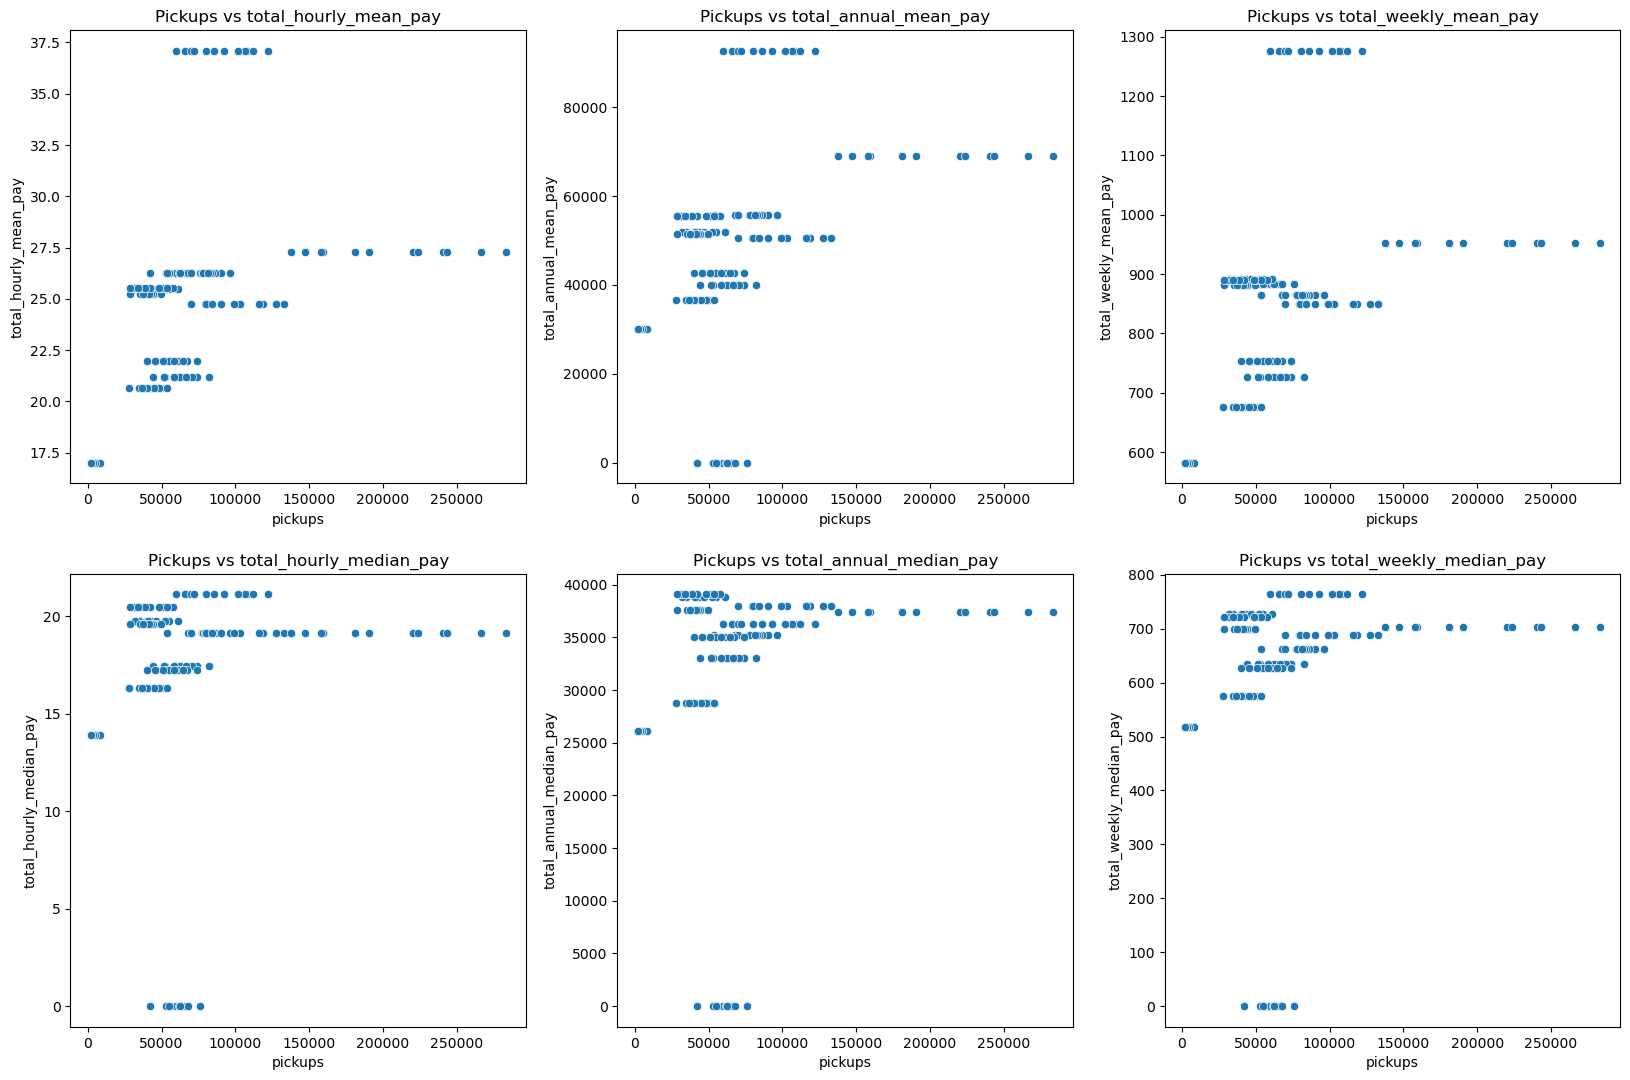

In [ ]:
# plot scatter plot for pickups vs "total_hourly_mean_pay", "total_annual_mean_pay", "total_weekly_mean_pay","total_hourly_median_pay", "total_annual_median_pay", 
"total_weekly_median_pay"
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.scatterplot(x='pickups', y='total_hourly_mean_pay', data=pickups_merged)
plt.title('Pickups vs total_hourly_mean_pay')
plt.subplot(3,3,2)
sns.scatterplot(x='pickups', y='total_annual_mean_pay', data=pickups_merged)
plt.title('Pickups vs total_annual_mean_pay')
plt.subplot(3,3,3)
sns.scatterplot(x='pickups', y='total_weekly_mean_pay', data=pickups_merged)
plt.title('Pickups vs total_weekly_mean_pay')
plt.subplot(3,3,4)
sns.scatterplot(x='pickups', y='total_hourly_median_pay', data=pickups_merged)
plt.title('Pickups vs total_hourly_median_pay')
plt.subplot(3,3,5)
sns.scatterplot(x='pickups', y='total_annual_median_pay', data=pickups_merged)
plt.title('Pickups vs total_annual_median_pay')
plt.subplot(3,3,6)
sns.scatterplot(x='pickups', y='total_weekly_median_pay', data=pickups_merged)
plt.title('Pickups vs total_weekly_median_pay')
plt.show()


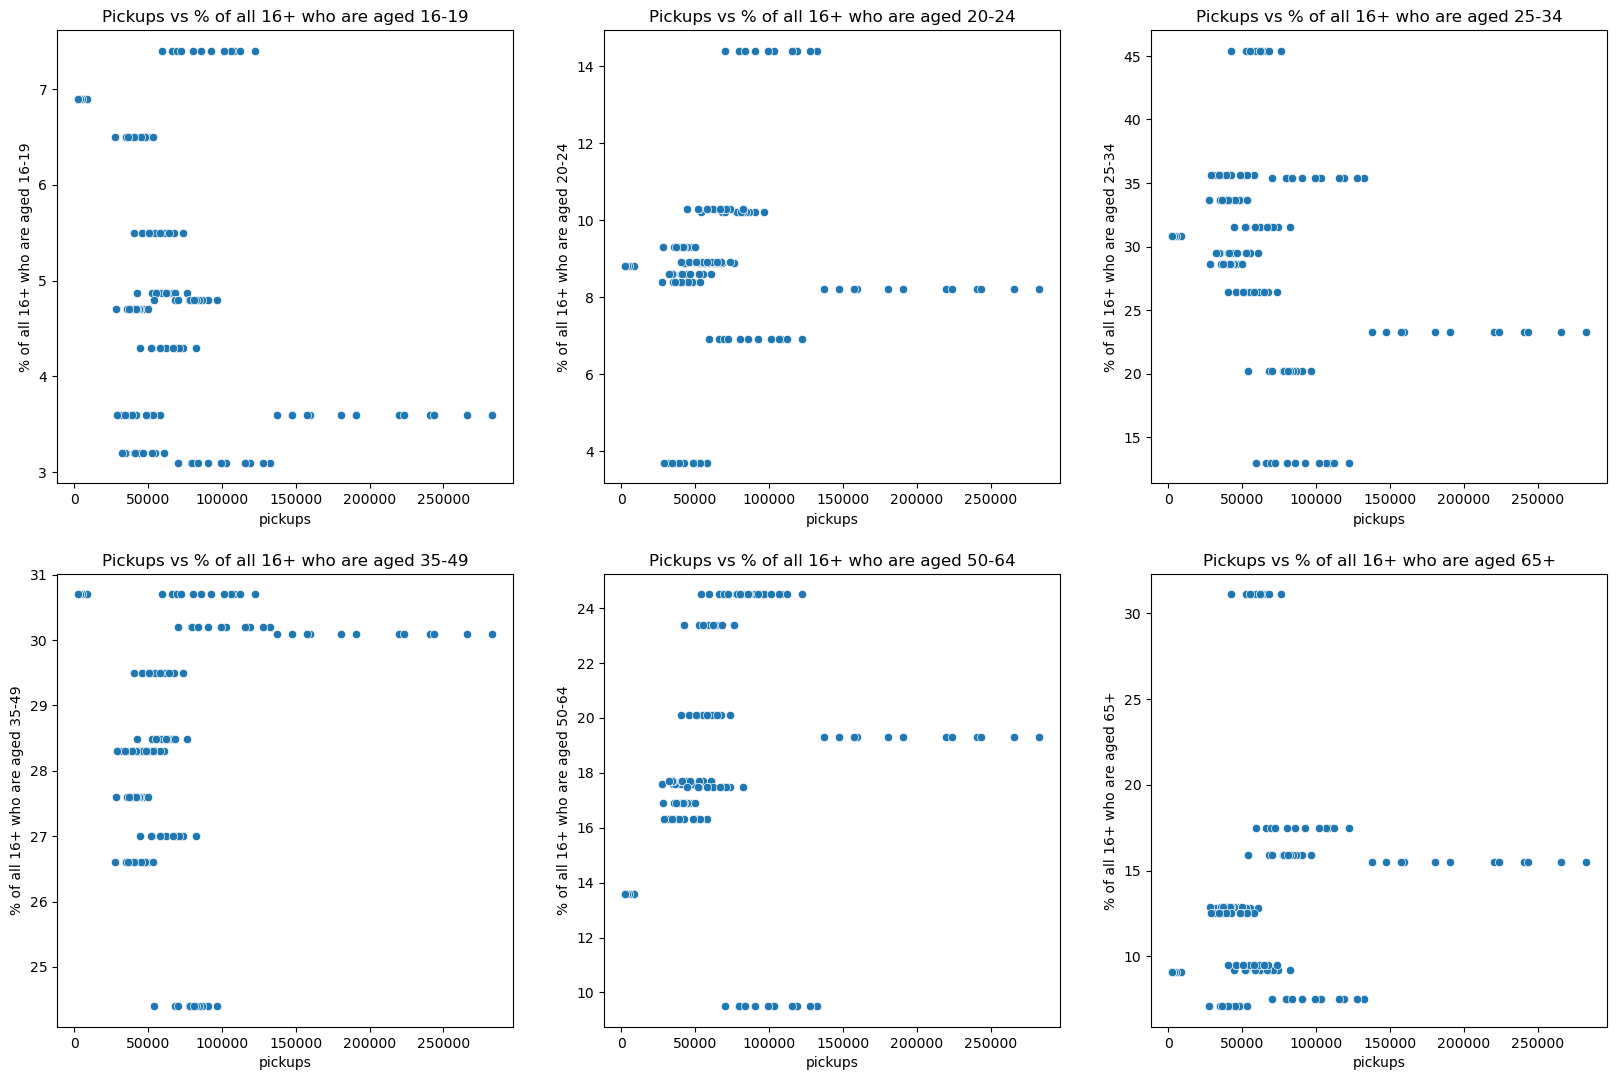

In [56]:
# plot scatter plot for pickups vs "% of all 16+ who are aged 16-19", "% of all 16+ who are aged 20-24", "% of all 16+ who are aged 25-34", "% of all 16+ who are aged 35-49", "% of all 16+ who are aged 50-64", "% of all 16+ who are aged 65+",
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.scatterplot(x='pickups', y='% of all 16+ who are aged 16-19', data=pickups_merged_)
plt.title('Pickups vs % of all 16+ who are aged 16-19')
plt.subplot(3,3,2)
sns.scatterplot(x='pickups', y='% of all 16+ who are aged 20-24', data=pickups_merged)
plt.title('Pickups vs % of all 16+ who are aged 20-24')
plt.subplot(3,3,3)
sns.scatterplot(x='pickups', y='% of all 16+ who are aged 25-34', data=pickups_merged)
plt.title('Pickups vs % of all 16+ who are aged 25-34')
plt.subplot(3,3,4)
sns.scatterplot(x='pickups', y='% of all 16+ who are aged 35-49', data=pickups_merged)
plt.title('Pickups vs % of all 16+ who are aged 35-49')
plt.subplot(3,3,5)
sns.scatterplot(x='pickups', y='% of all 16+ who are aged 50-64', data=pickups_merged)
plt.title('Pickups vs % of all 16+ who are aged 50-64')
plt.subplot(3,3,6)
sns.scatterplot(x='pickups', y='% of all 16+ who are aged 65+', data=pickups_merged)
plt.title('Pickups vs % of all 16+ who are aged 65+')
plt.show()

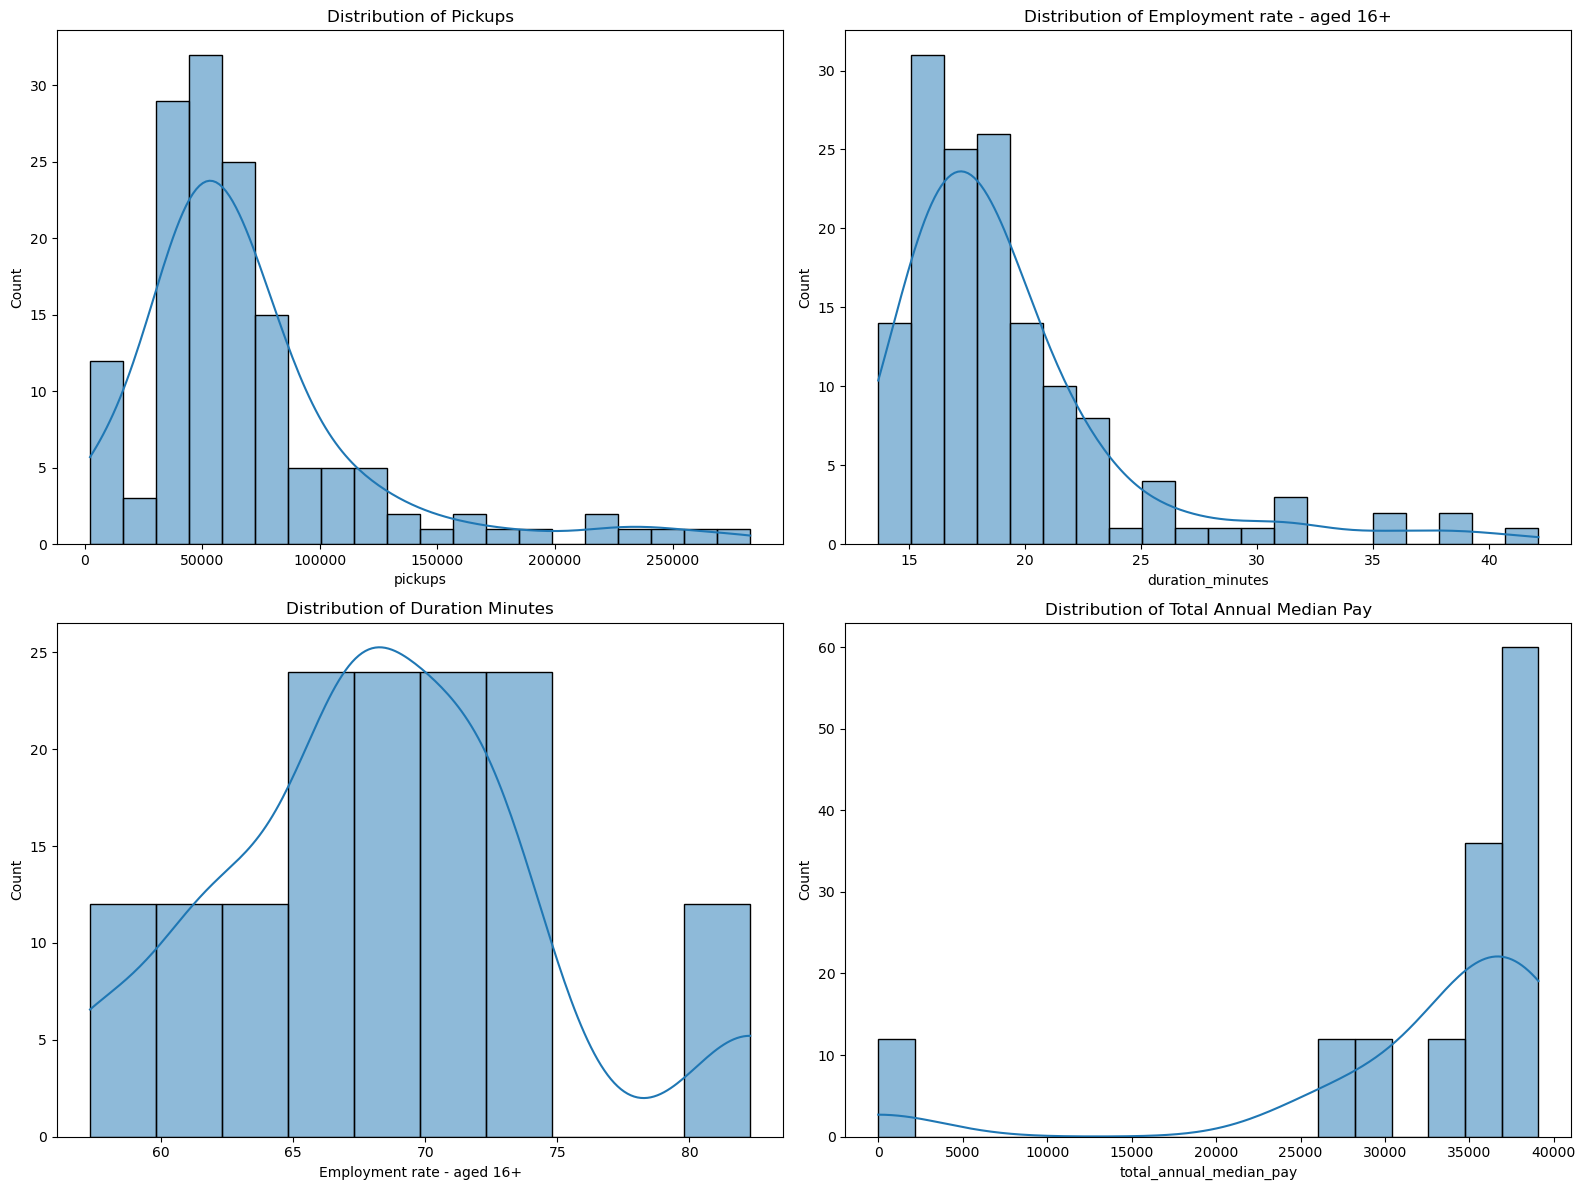

In [ ]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot the distribution of pickups
sns.histplot(pickups_merged['pickups'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Pickups')

# Plot the distribution of duration_minutes
sns.histplot(pickups_merged['duration_minutes'], kde=True, ax=axes[0, 1])
axes[1, 0].set_title('Distribution of Duration Minutes')

# Plot the distribution of Employment rate - aged 16+
sns.histplot(pickups_merged['Employment rate - aged 16+'], kde=True, ax=axes[1, 0])
axes[0, 1].set_title('Distribution of Employment rate - aged 16+')

# Plot the distribution of total_annual_median_pay
sns.histplot(pickups_merged['total_annual_median_pay'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Total Annual Median Pay')


# Show the plots
plt.tight_layout()
plt.show()


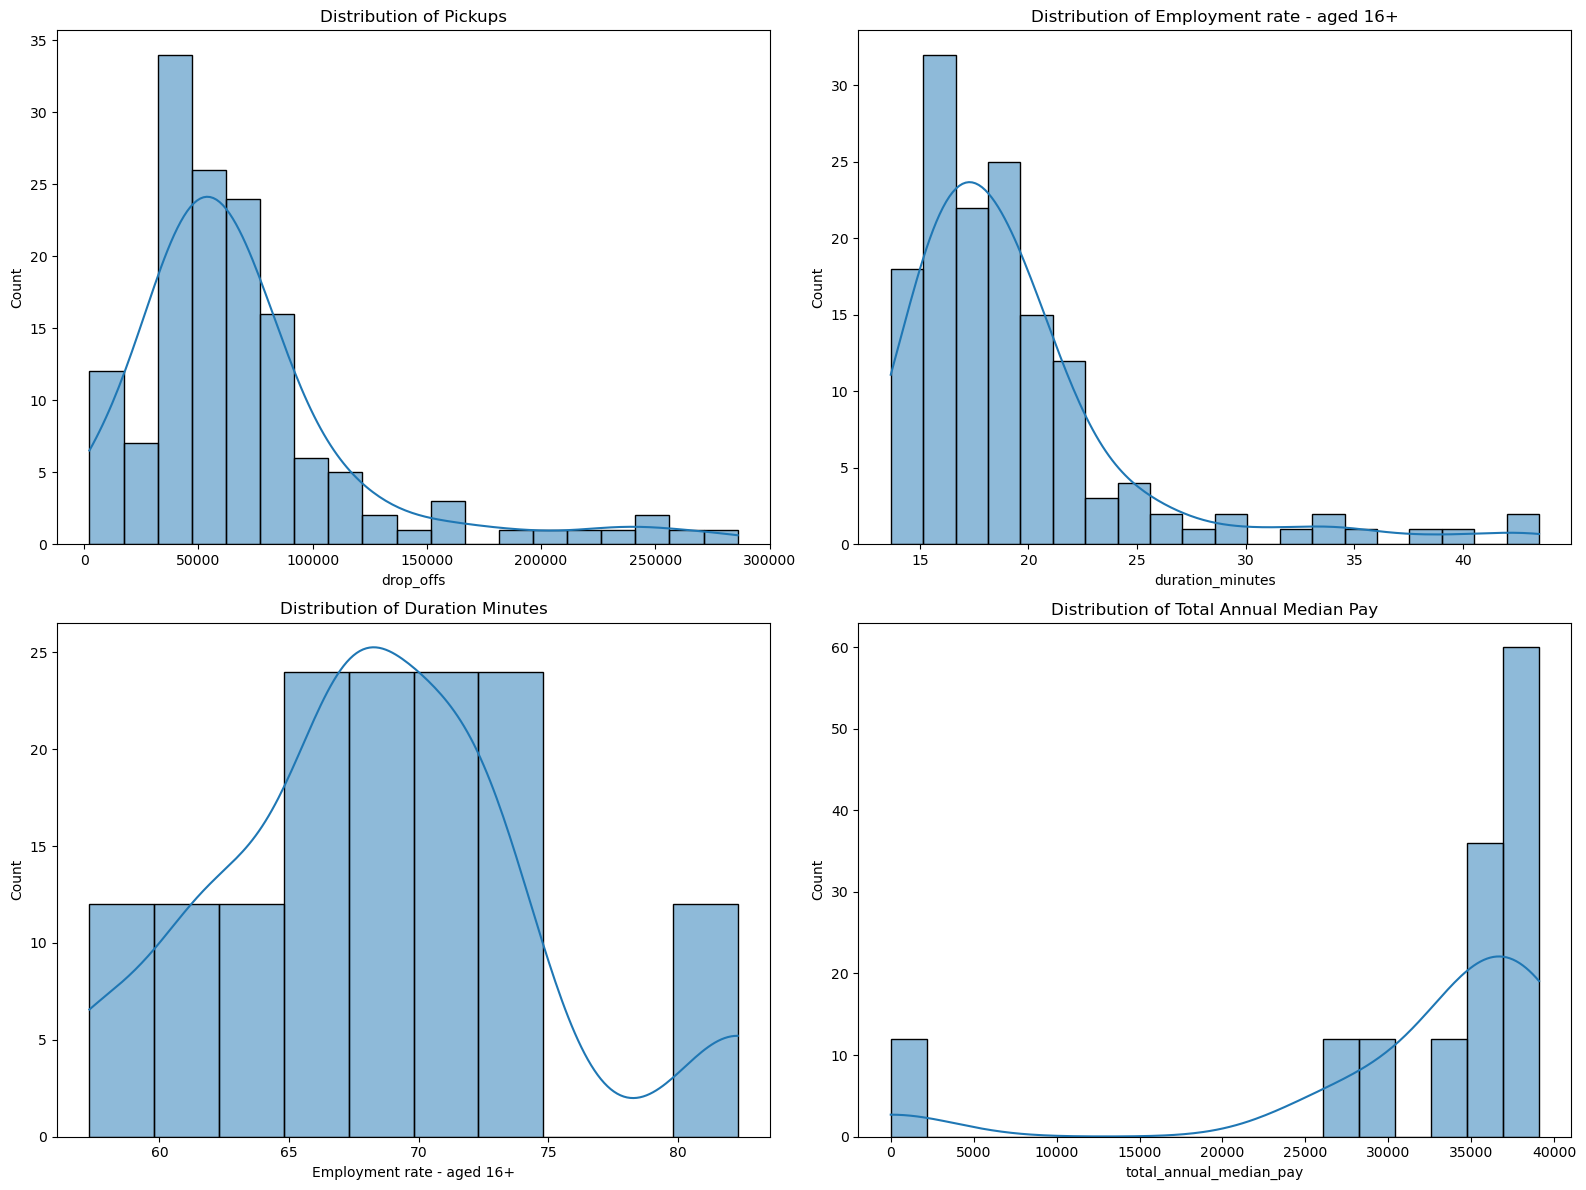

In [ ]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot the distribution of pickups
sns.histplot(droppoffs_merged['drop_offs'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Pickups')

# Plot the distribution of duration_minutes
sns.histplot(droppoffs_merged['duration_minutes'], kde=True, ax=axes[0, 1])
axes[1, 0].set_title('Distribution of Duration Minutes')

# Plot the distribution of Employment rate - aged 16+
sns.histplot(droppoffs_merged['Employment rate - aged 16+'], kde=True, ax=axes[1, 0])
axes[0, 1].set_title('Distribution of Employment rate - aged 16+')

# Plot the distribution of total_annual_median_pay
sns.histplot(droppoffs_merged['total_annual_median_pay'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Total Annual Median Pay')


# Show the plots
plt.tight_layout()
plt.show()


### Fit model on mixed data

In [75]:
# create values of 0 to 12 for start_borough_name
label_encoder = LabelEncoder()

# Fit the encoder on the borough column and transform the values
pickups_merged['start_borough_code'] = label_encoder.fit_transform(pickups_merged['start_borough_code'])

pickups_merged['start_borough_code'].unique()

# pickups_merged.drop(columns=["start_borough_name"], inplace=True)


# # create values of 0 to 12 for start_borough_name
# label_encoder = LabelEncoder()

# # Fit the encoder on the borough column and transform the values
# droppoffs_merged ['end_borough_code'] = label_encoder.fit_transform(droppoffs_merged['end_borough_code'])

# droppoffs_merged['end_borough_code'].unique()

# droppoffs_merged.drop(columns=["end_borough_name"], inplace=True)
pickups_merged_zero_fill['start_borough_code'] = label_encoder.fit_transform(pickups_merged_zero_fill['start_borough_code'])

pickups_merged_zero_fill['start_borough_code'].unique()

# Fit the encoder on the borough column and transform the values
pickups_merged_mean_fill['start_borough_code'] = label_encoder.fit_transform(pickups_merged_mean_fill['start_borough_code'])

pickups_merged_mean_fill['start_borough_code'].unique()

pickups_merged_median_fill['start_borough_code'] = label_encoder.fit_transform(pickups_merged_median_fill['start_borough_code'])

pickups_merged_median_fill['start_borough_code'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Conveted categorical features such as boroughs into labels from 0 to 11

# Split data to train and test sets

In [95]:
# split the pickups_merged, dropoffs_merged into train and test sets
X_train_zero, X_test_zero, y_train_zero, y_test_zero = train_test_split(pickups_merged_zero_fill.drop(columns=['pickups','start_borough_name']), pickups_merged_zero_fill['pickups'], test_size=0.25, random_state=42)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(pickups_merged_mean_fill.drop(columns=['pickups','start_borough_name']), pickups_merged_mean_fill['pickups'], test_size=0.25, random_state=42)
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(pickups_merged_median_fill.drop(columns=['pickups','start_borough_name']), pickups_merged_median_fill['pickups'], test_size=0.25, random_state=42)

# split the pickups_merged, dropoffs_merged into train and test sets
# X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(droppoffs_merged.drop(columns=['drop_offs']), droppoffs_merged['drop_offs'], test_size=0.25, random_state=42)

In [96]:
# print shapes of train and test sets
print(X_train_zero.shape, X_test_zero.shape, y_train_zero.shape, y_test_zero.shape)

# print shapes of train and test sets
# print(X_train_drop.shape, X_test_drop.shape, y_train_drop.shape, y_test_drop.shape)

(108, 149) (36, 149) (108,) (36,)


# Regression models

# Fit first decision tree model

In [105]:
# train a decision tree regressor model on the training set with grid search and validation
# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error

model = DecisionTreeRegressor(random_state=42)
# max_depth=6, min_samples_split=5, min_samples_leaf=9
# define the parameters to search
param_grid = {
    'max_depth': [3, 5, 7, 8,9,10,11,12, None],
    'min_samples_split': [2, 3,4,5,6,7, 10,11,12,13],
    'min_samples_leaf': [2, 3,4,5,6,7,8, 10,11,12]
}

# define the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=1)

# execute the grid search
grid_search.fit(X_train_zero, y_train_zero)

# print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)

y_pred = grid_search.predict(X_test_zero)

y_pred_train = grid_search.predict(X_train_zero)

# print the r2 score
print(r2_score(y_train_zero, y_pred_train))
print(r2_score(y_test_zero, y_pred))


# Compute the RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train_zero, y_pred_train))

mse = mean_squared_error(y_test_zero, y_pred)
print('Mean Squared Error:', rmse_train, mse)

#print summary of the model
print(grid_search.best_estimator_)

# print the feature importances in descending order
sorted(zip(grid_search.best_estimator_.feature_importances_, X_train_zero.columns), reverse=True)


Fitting 10 folds for each of 990 candidates, totalling 9900 fits
{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.9162683734408631
0.9982143175383725
0.8956940092293123
Mean Squared Error: 2315.6104329157397 127082739.80971278
DecisionTreeRegressor(max_depth=8, min_samples_split=3, random_state=42)


[(0.7185076714591557, 'part_time_annual_mean_pay'),
 (0.09171395921799948, 'female_part_time_annual_median_pay'),
 (0.053639584319189075, 'feelslike'),
 (0.03795859261609141, '% of all people aged 16+ who are female'),
 (0.035186245157448115, 'female_full_time_hourly_mean_pay'),
 (0.024587698576092616, 'humidity'),
 (0.016606479687392935, 'temp'),
 (0.005625253484678192, 'start_number_of_bikes'),
 (0.0027701811032974782, 'full_time_weekly_median_pay'),
 (0.002671100485603792, 'bank_holiday'),
 (0.0023808806007564395,
  'Living Environment - Rank of proportion of LSOAs in most deprived 10% nationally '),
 (0.0017796915016396076, 'cloudcover'),
 (0.0017407289341270506, 'full_time_hourly_median_pay'),
 (0.0014810867126722955, 'start_number_of_empty_docks'),
 (0.0009522122064565764, 'male_part_time_weekly_median_pay'),
 (0.0007799264660398733, 'start_month'),
 (0.0006847889559551571, 'male_full_time_annual_median_pay'),
 (0.0003786245710180015, 'duration_minutes'),
 (0.0003595381803197971,

In [108]:
# train a decision tree regressor model on the training set with grid search and validation
# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error

model = DecisionTreeRegressor(random_state=42)
# max_depth=6, min_samples_split=5, min_samples_leaf=9
# define the parameters to search
param_grid = {
    'max_depth': [3, 5, 7, 8,9,10,11,12, None],
    'min_samples_split': [ 3,4,5,6,7, 10,11,12,13],
    'min_samples_leaf': [3,4,5,6,7,8, 10,11,12]
}

# define the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=1)

# execute the grid search
grid_search.fit(X_train_mean, y_train_mean)

# print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)

y_pred = grid_search.predict(X_test_mean)

y_pred_train = grid_search.predict(X_train_mean)

# print the r2 score
print(r2_score(y_train_mean, y_pred_train))
print(r2_score(y_test_mean, y_pred))


# Compute the RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train_mean, y_pred_train))

mse = mean_squared_error(y_test_mean, y_pred)
print('Mean Squared Error:', rmse_train, mse)

#print summary of the model
print(grid_search.best_estimator_)

# print the feature importances in descending order
sorted(zip(grid_search.best_estimator_.feature_importances_, X_train_mean.columns), reverse=True)


Fitting 10 folds for each of 729 candidates, totalling 7290 fits
{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.8959398667013397
0.9880279260687815
0.932332334544984
Mean Squared Error: 5995.812953611157 82443896.64497685
DecisionTreeRegressor(max_depth=8, min_samples_leaf=3, min_samples_split=3,
                      random_state=42)


[(0.7259153572363265, '% with NVQ2 only - aged 16-64'),
 (0.08907675927849447, '% in employment working full-time - aged 50+'),
 (0.07167144535307808, 'feelslike'),
 (0.06179229140595532, 'part_time_hourly_median_pay'),
 (0.023903550584773784, '% of all people aged 16+ who are male'),
 (0.015101607561821618, 'temp'),
 (0.004325149408641757, 'start_number_of_empty_docks'),
 (0.0023310930413361257, 'average_house_price'),
 (0.0021729451018093373, '% in employment working part-time - aged 20-24'),
 (0.0010246652997958209, 'start_month'),
 (0.0008407546746342384, '% with NVQ3 only - aged 16-64'),
 (0.0007215068204979376, 'part_time_weekly_median_pay'),
 (0.0005181858658058577, 'cloudcover'),
 (0.0003623392638933495, 'start_number_of_docks'),
 (0.00024234910313589676, 'windspeed'),
 (0.0, 'uvindex'),
 (0.0, 'total_weekly_median_pay'),
 (0.0, 'total_weekly_mean_pay'),
 (0.0, 'total_hourly_median_pay'),
 (0.0, 'total_hourly_mean_pay'),
 (0.0, 'total_annual_median_pay'),
 (0.0, 'total_annual_m

# Random Forest Regressor round 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Define the initial parameters to search
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50, 60, 80, 100, 110],
    'max_depth': [5, 6, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20


while overfitting and iteration < max_iterations:

    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the R2 scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(train_r2, test_r2)

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_r2 - test_r2) < 0.05:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]
        param_grid['n_estimators'] = [random.randint(5, 150) if n >= 150 else n+10 for n in param_grid['n_estimators']]

        
        print('param_grid',iteration,":", param_grid)
        

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Compute and print the RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'n_estimators': [5, 10, 20, 30, 40, 50, 60, 80, 100, 110], 'max_depth': [5, 6, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
0.9917011185483159 0.8337841261042038
param_grid 0 : {'n_estimators': [15, 20, 30, 40, 50, 60, 70, 90, 110, 120], 'max_depth': [4, 5, 7, 8, 9], 'min_samples_split': [3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6, 7]}
param_grid 1 : {'n_estimators': [15, 20, 30, 40, 50, 60, 70, 90, 110, 120], 'max_depth': [4, 5, 7, 8, 9], 'min_samples_split': [3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6, 7]}
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
0.9779542370471754 0.8292492986911482
param_grid 1 : {'n_estimators': [25, 30, 40, 50, 60, 70, 80, 100, 120, 130], 'max_depth': [3, 4, 6, 7, 8], 'min_samples_split': [4, 5, 6, 7, 8], 'min_samples_leaf': [3, 4, 5, 6, 7, 8]}
param_grid 2 : {'n_estimators': [25, 30, 40, 50, 60, 70, 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Define the initial parameters to search
param_grid = {
    'n_estimators': [110,120,122,124,126,128,127,130],
    'max_depth': [3,4,5, 6, 8, 9, 10],
    'min_samples_split': [6,7,8,9,10,12,13],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6,7,8,10]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20


while overfitting and iteration < max_iterations:

    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the R2 scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(train_r2, test_r2)

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_r2 - test_r2) < 0.05:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]
        param_grid['n_estimators'] = [random.randint(5, 150) if n >= 150 else n+10 for n in param_grid['n_estimators']]

        
        print('param_grid',iteration,":", param_grid)
        

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Compute and print the RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'n_estimators': [110, 120, 122, 124, 126, 128, 127, 130], 'max_depth': [3, 4, 5, 6, 8, 9, 10], 'min_samples_split': [6, 7, 8, 9, 10, 12, 13], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10]}
Fitting 5 folds for each of 3528 candidates, totalling 17640 fits
0.9723007158047705 0.8107316705282912
param_grid 0 : {'n_estimators': [120, 130, 132, 134, 136, 138, 137, 140], 'max_depth': [2, 3, 4, 5, 7, 8, 9], 'min_samples_split': [7, 8, 9, 10, 2, 7, 9], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 6]}
param_grid 1 : {'n_estimators': [120, 130, 132, 134, 136, 138, 137, 140], 'max_depth': [2, 3, 4, 5, 7, 8, 9], 'min_samples_split': [7, 8, 9, 10, 2, 7, 9], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 6]}
Fitting 5 folds for each of 3528 candidates, totalling 17640 fits
0.983283989996272 0.8248809394294748
param_grid 1 : {'n_estimators': [130, 140, 142, 144, 146, 148, 147, 150], 'max_depth': [3, 2, 3, 4, 6, 7, 8], 'min_samples_split': [8, 9, 10, 4, 3, 8, 10], 'min_samples_leaf': [

KeyboardInterrupt: 

# Gradient Boosting Regressor round 1

In [ ]:
# train a gradient boosting regressor model on the training set with grid search and validation
# define the model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

model = GradientBoostingRegressor(random_state=42)

# Define the initial parameters to search
param_grid = {
    'n_estimators': [10,20,50,80,120,130,180,220],
    'max_depth': [3,4,5, 6, 8, 9, 10,15,20,25,30],
    'min_samples_split': [6,7,8,9,10,12,13,15,18,20,25,28,30,32],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6,7,8,10,13,14,15,18,20,25,29,30,25]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20


while overfitting and iteration < max_iterations:

    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the R2 scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(train_r2, test_r2)
    
    print('best params',grid_search.best_params_)

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_r2 - test_r2) < 0.05:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]
        param_grid['n_estimators'] = [random.randint(5, 150) if n >= 150 else n+10 for n in param_grid['n_estimators']]

        
        print('param_grid',iteration,":", param_grid)
        

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Compute and print the RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'n_estimators': [10, 20, 50, 80, 120, 130, 180, 220], 'max_depth': [3, 4, 5, 6, 8, 9, 10, 15, 20, 25, 30], 'min_samples_split': [6, 7, 8, 9, 10, 12, 13, 15, 18, 20, 25, 28, 30, 32], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 15, 18, 20, 25, 29, 30, 25]}
Fitting 5 folds for each of 22176 candidates, totalling 110880 fits
0.9997759212823398 0.9013880122100839
best params {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 32, 'n_estimators': 220}
param_grid 0 : {'n_estimators': [20, 30, 60, 90, 130, 140, 23, 21], 'max_depth': [2, 3, 4, 5, 7, 8, 9, 14, 19, 24, 29], 'min_samples_split': [7, 8, 9, 10, 3, 5, 6, 2, 6, 10, 8, 10, 9, 3], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 4, 5, 8, 9, 7, 3, 10, 8, 10, 7]}
param_grid 1 : {'n_estimators': [20, 30, 60, 90, 130, 140, 23, 21], 'max_depth': [2, 3, 4, 5, 7, 8, 9, 14, 19, 24, 29], 'min_samples_split': [7, 8, 9, 10, 3, 5, 6, 2, 6, 10, 8, 10, 9, 3], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 4, 5, 8, 9, 7

KeyboardInterrupt: 

In [ ]:
# train a gradient boosting regressor model on the training set with grid search and validation
# define the model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

model = GradientBoostingRegressor(random_state=42)

# Define the initial parameters to search
param_grid = {
    'n_estimators': [158, 151, 137, 146, 153, 53, 144, 102],
    'max_depth': [3, 4, 2, 5, 8],
    'min_samples_split': [5, 8, 6, 10, 7, 9],
    'min_samples_leaf': [6, 7, 5, 9, 8,10]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20


while overfitting and iteration < max_iterations:

    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the R2 scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(train_r2, test_r2)
    
    print('best params', grid_search.best_params_)

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_r2 - test_r2) < 0.05:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]
        param_grid['n_estimators'] = [random.randint(5, 150) if n >= 150 else n+10 for n in param_grid['n_estimators']]

        
        print('param_grid',iteration,":", param_grid)
        

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Compute and print the RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'n_estimators': [158, 151, 137, 146, 153, 53, 144, 102], 'max_depth': [3, 4, 2, 5, 8], 'min_samples_split': [5, 8, 6, 10, 7, 9], 'min_samples_leaf': [6, 7, 5, 9, 8, 10]}
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
0.998626746040217 0.9292690749072638
Best parameters: {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 158}
param_grid 0 : {'n_estimators': [70, 130, 138, 147, 110, 54, 145, 103], 'max_depth': [2, 3, 3, 4, 7], 'min_samples_split': [6, 9, 7, 9, 8, 10], 'min_samples_leaf': [7, 8, 6, 10, 9, 2]}
param_grid 1 : {'n_estimators': [70, 130, 138, 147, 110, 54, 145, 103], 'max_depth': [2, 3, 3, 4, 7], 'min_samples_split': [6, 9, 7, 9, 8, 10], 'min_samples_leaf': [7, 8, 6, 10, 9, 2]}
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
0.9986374420246359 0.886567377064486
Best parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 138}
param_grid 1 : {'n_estimators': [71

## evaluating models

# Evaluate Random Forest Model

In [87]:
# import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# max_depth=5, min_samples_leaf=5, min_samples_split=4, n_estimators=11
# create a model with best parameters and test it on test set   
model_test = RandomForestRegressor(max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=127, random_state=42)
# {'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 127}
# fit the model
model_test.fit(X_train_mean, y_train_mean)

#print train and test scores
print(model_test.score(X_train_mean, y_train_mean))
print(model_test.score(X_test_mean, y_test_mean))

# predict the test set
y_pred = model_test.predict(X_test_mean)

# predict the train set
y_pred_train = model_test.predict(X_train_mean)

# Compute the RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train_mean, y_pred_train))

# Compute the RMSE on the testing set
rmse_test = np.sqrt(mean_squared_error(y_test_mean, y_pred))

print(rmse_train, rmse_test)

# print the r2 score
print(r2_score(y_test_mean, y_pred))

# print the feature importances in descending order
sorted(zip(model_test.feature_importances_, X_train_mean.columns), reverse=True)


0.8495078441040154
0.874179456677201
21257.897708000626 12381.248391150793
0.874179456677201


[(0.07763318244369605, 'start_borough_code'),
 (0.05555341815524796, '% in employment working full-time - aged 20-24'),
 (0.053806763463423675, 'female_full_time_hourly_mean_pay'),
 (0.05232708800253544, 'female_full_time_weekly_mean_pay'),
 (0.04667031624675891, 'full_time_annual_median_pay'),
 (0.04583233358499303, 'male_full_time_weekly_median_pay'),
 (0.04563937677923029, 'start_number_of_empty_docks'),
 (0.04533853113524471, '% in employment working full-time - aged 50+'),
 (0.04276317755679238, 'female_full_time_annual_mean_pay'),
 (0.04114464628483732, 'average_house_price'),
 (0.03921187067962743, '% with NVQ2 only - aged 16-64'),
 (0.03611121216100135, '% of all 16+ who are aged 20-24'),
 (0.025898963915050213, 'start_number_of_bikes'),
 (0.02331876825467613, 'start_number_of_docks'),
 (0.023058496033206206, 'total_hourly_mean_pay'),
 (0.022905479903312487, 'full_time_weekly_median_pay'),
 (0.022785337860886264, 'full_time_hourly_mean_pay'),
 (0.022382254885738313,
  'Employme

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Define the model
model = RandomForestRegressor(max_depth=3, min_samples_leaf=7, min_samples_split=10, n_estimators=127, random_state=42)

# Fit the model to the training data
model.fit(X_train_mean, y_train_mean)

# Predict on the training data
train_predictions = model.predict(X_train_mean)

# precict on the test data
test_predictions = model.predict(X_test_mean)

# Calculate the mean absolute error on the training data
train_error = mean_absolute_error(y_train_mean, train_predictions)
print(f'Training Mean Absolute Error: {train_error:.3f}')

test_error = mean_absolute_error(y_test_mean, test_predictions)
print(f'Test Mean Absolute Error: {test_error:.3f}')

# Calculate the r2 score on the training data
train_r2_score = r2_score(y_train_mean, train_predictions)
print(f'Training R2 Score: {train_r2_score:.3f}')

# Calculate the r2 score on the test data
test_r2_score = r2_score(y_test_mean, test_predictions)
print(f'Test R2 Score: {test_r2_score:.3f}')

# Define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model, X_train_mean, y_train_mean, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Force the scores to be positive
scores = np.absolute(scores)

# Print the mean and standard deviation of the cross-validation error
print(f'Cross-Validation Mean Absolute Error: {scores.mean():.3f} ({scores.std():.3f})')

# Evaluate the model using cross-validation for r2 score
r2_scores = cross_val_score(model, X_train_mean, y_train_mean, scoring='r2', cv=cv, n_jobs=-1)

# Calculate the mean r2 score
mean_r2_score = np.mean(r2_scores)
print(f'Cross-Validation Mean R2 Score: {mean_r2_score:.3f}')



Training Mean Absolute Error: 13433.382
Test Mean Absolute Error: 9472.313
Training R2 Score: 0.850
Test R2 Score: 0.874
Cross-Validation Mean Absolute Error: 17847.768 (6649.411)
Cross-Validation Mean R2 Score: 0.714


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Define the model
model = RandomForestRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=3, n_estimators=80, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the training data
train_predictions = model.predict(X_train)

# precict on the test data
test_predictions = model.predict(X_test)

# Calculate the mean absolute error on the training data
train_error = mean_absolute_error(y_train, train_predictions)
print(f'Training Mean Absolute Error: {train_error:.3f}')

test_error = mean_absolute_error(y_test, test_predictions)
print(f'Test Mean Absolute Error: {test_error:.3f}')

# Calculate the r2 score on the training data
train_r2_score = r2_score(y_train, train_predictions)
print(f'Training R2 Score: {train_r2_score:.3f}')

# Calculate the r2 score on the test data
test_r2_score = r2_score(y_test, test_predictions)
print(f'Test R2 Score: {test_r2_score:.3f}')

# Define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Force the scores to be positive
scores = np.absolute(scores)

# Print the mean and standard deviation of the cross-validation error
print(f'Cross-Validation Mean Absolute Error: {scores.mean():.3f} ({scores.std():.3f})')

# Evaluate the model using cross-validation for r2 score
r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)

# Calculate the mean r2 score
mean_r2_score = np.mean(r2_scores)
print(f'Cross-Validation Mean R2 Score: {mean_r2_score:.3f}')



Training Mean Absolute Error: 10053.762
Test Mean Absolute Error: 10803.988
Training R2 Score: 0.909
Test R2 Score: 0.800
Cross-Validation Mean Absolute Error: 14330.141 (5576.046)
Cross-Validation Mean R2 Score: 0.812


# evaluate gradient boost model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Define the model
model = GradientBoostingRegressor(n_estimators=100, max_depth=15,min_samples_leaf=15, min_samples_split=80, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the training data
train_predictions = model.predict(X_train)

# precict on the test data
test_predictions = model.predict(X_test)

# Calculate the mean absolute error on the training data
train_error = mean_absolute_error(y_train, train_predictions)
print(f'Training Mean Absolute Error: {train_error:.3f}')

test_error = mean_absolute_error(y_test, test_predictions)
print(f'Test Mean Absolute Error: {test_error:.3f}')

# Calculate the r2 score on the training data
train_r2_score = r2_score(y_train, train_predictions)
print(f'Training R2 Score: {train_r2_score:.3f}')

# Calculate the r2 score on the test data
test_r2_score = r2_score(y_test, test_predictions)
print(f'Test R2 Score: {test_r2_score:.3f}')

# Define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# Force the scores to be positive
scores = np.absolute(scores)

# Print the mean and standard deviation of the cross-validation error
print(f'Cross-Validation Mean Absolute Error: {scores.mean():.3f} ({scores.std():.3f})')

# Evaluate the model using cross-validation for r2 score
r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)

# Calculate the mean r2 score
mean_r2_score = np.mean(r2_scores)
print(f'Cross-Validation Mean R2 Score: {mean_r2_score:.3f}')



Training Mean Absolute Error: 5276.397
Test Mean Absolute Error: 9249.337
Training R2 Score: 0.974
Test R2 Score: 0.839
Cross-Validation Mean Absolute Error: 9214.116 (3599.500)
Cross-Validation Mean R2 Score: 0.896


# Classification Methods

# Clustering data into groups based on demand

In [305]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

features = pickups_merged_zero_fill[['pickups']]

scaler = StandardScaler()
pickups_scaled = scaler.fit_transform(features)

# Define the number of clusters
num_clusters = 2

# Create and fit the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pickups_scaled)

# Get the cluster labels
cluster_labels = kmeans.labels_

score = silhouette_score(pickups_scaled, cluster_labels)
print('Silhouette Score: ', score)

# Assign the cluster labels as the pickup labels
pickups_merged_zero_fill['pickup_label'] = cluster_labels

Silhouette Score:  0.7404239081887165


/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [118]:
pickups_merged_zero_fill['pickup_label'].value_counts()

0    130
1     14
Name: pickup_label, dtype: int64

In [126]:
pickups_merged_zero_fill[pickups_merged_zero_fill['pickup_label'] == 0]['pickups'].describe()

count       130.000000
mean      55605.315385
std       26675.069613
min        2290.000000
25%       40113.250000
50%       53367.500000
75%       69846.000000
max      122160.000000
Name: pickups, dtype: float64

In [127]:
pickups_merged_zero_fill[pickups_merged_zero_fill['pickup_label'] == 1]['pickups'].describe()

count        14.000000
mean     193635.928571
std       52312.010188
min      127608.000000
25%      149852.250000
50%      185782.500000
75%      236494.500000
max      283011.000000
Name: pickups, dtype: float64

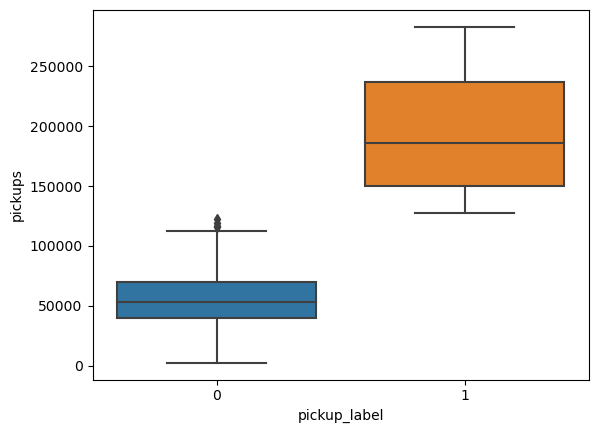

In [119]:
# plot box plot for pickups by cluster
sns.boxplot(x='pickup_label', y='pickups', data=pickups_merged_zero_fill)
plt.show()


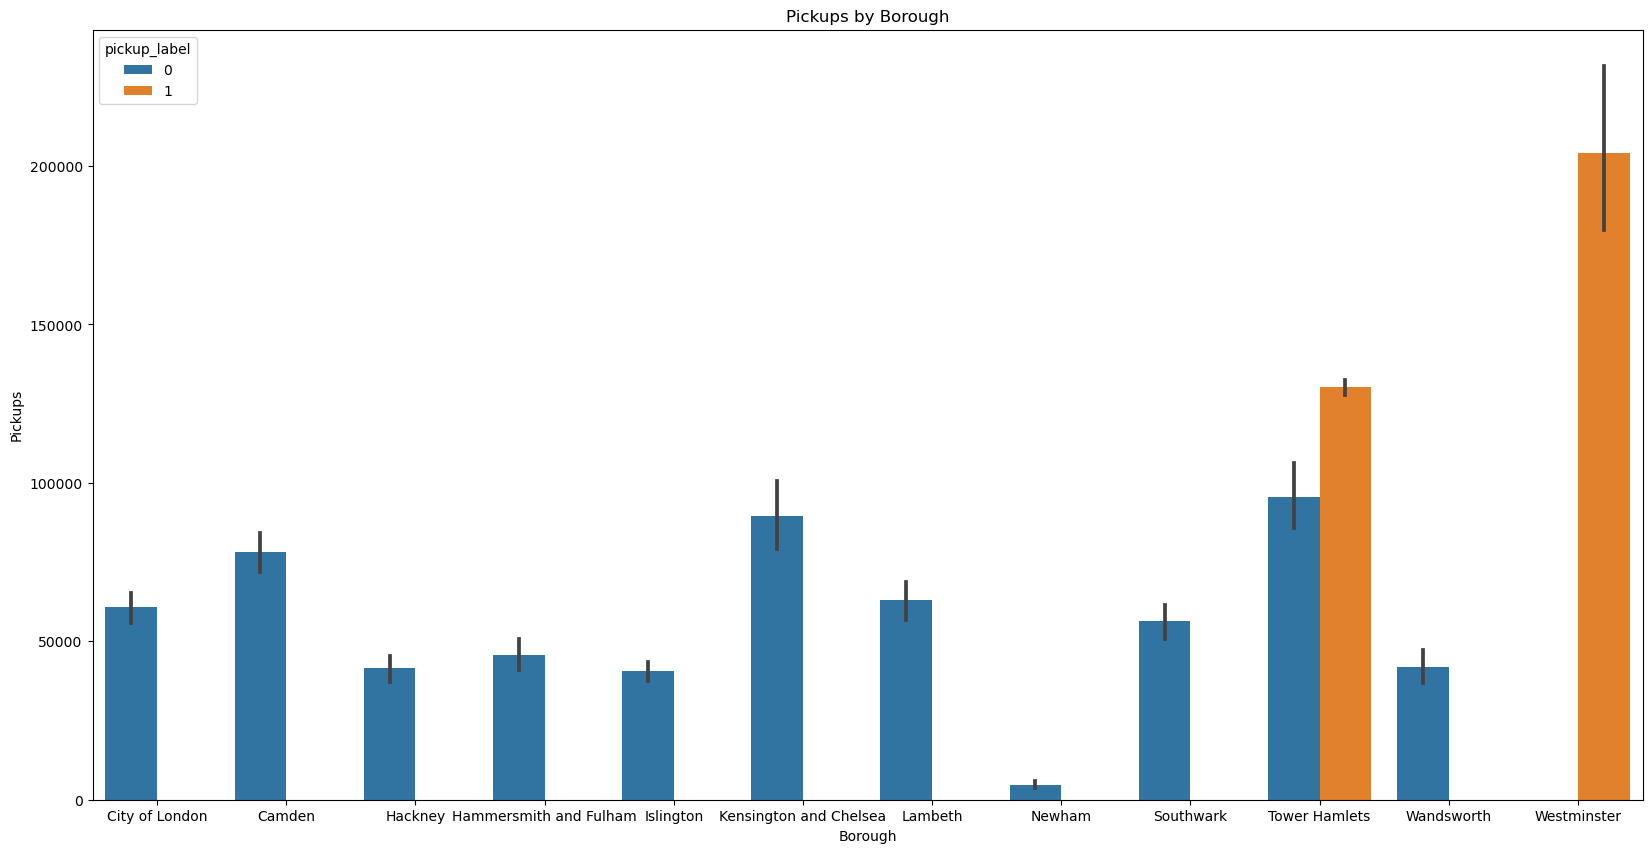

In [138]:
# plot for each borough the number of pickups
plt.figure(figsize=(20, 10))
sns.barplot(x='start_borough_name', y='pickups', data=pickups_merged_zero_fill, hue='pickup_label')
plt.title('Pickups by Borough')
plt.xlabel('Borough')
plt.ylabel('Pickups')
plt.show()


# fix unbalanced data

In [139]:
#transform pickup_label to 0,1,2
# pickups_merged['pickup_label'] = pickups_merged['pickup_label'].replace({'low': 0, 'medium': 2, 'high': 1})


from sklearn.utils import resample

# Separate majority and minority classes
pickups_majority = pickups_merged_zero_fill[pickups_merged_zero_fill.pickup_label==0]
pickups_minority = pickups_merged_zero_fill[pickups_merged_zero_fill.pickup_label==1]

# Upsample minority class
pickups_minority_upsampled = resample(pickups_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=50,    # to match majority class
                                    random_state=42) # reproducible results


# Combine majority class with upsampled minority class
pickups_upsampled = pd.concat([pickups_majority, pickups_minority_upsampled])

pickups_upsampled.pickup_label.value_counts()

0    130
1     50
Name: pickup_label, dtype: int64

In [141]:
pickups_upsampled['pickup_label'].value_counts()

low     130
high     50
Name: pickup_label, dtype: int64

In [140]:
# transfer pickup_label values to low, medium and high
pickups_upsampled['pickup_label'] = pickups_upsampled['pickup_label'].replace({0: 'low', 1: 'high'})

In [315]:
# transfer pickup_label values to low, medium and high
pickups_merged_zero_fill['pickup_label'] = pickups_merged_zero_fill['pickup_label'].replace({0: 'low', 1: 'high'})

In [143]:
pickups_upsampled.head()

start_month  start_borough_code start_borough_name  pickups  \
0            1                   0     City of London    56335   
1            2                   0     City of London    52799   
2            3                   0     City of London    59491   
3            4                   0     City of London    61914   
4            5                   0     City of London    66408   

   duration_minutes  bank_holiday  start_number_of_bikes  \
0         13.813065      0.012035               0.895181   
1         14.743669      0.000000               0.887630   
2         14.468121      0.000000               0.882621   
3         15.911119      0.039216               0.883645   
4         16.036321      0.026397               0.871838   

   start_number_of_docks  start_number_of_empty_docks  average_house_price  \
0              26.629449                    25.734268          865636.1043   
1              26.629936                    25.742306          894519.9090   
2              26.617488                    25.734867          853451.0753   
3              26.646574                    25.762929          738796.7242   
4              26.522241                    25.650404          719217.5584   

        temp  feelslike   humidity  windspeed  cloudcover   uvindex  \
0   5.453235   3.414801  75.987020  12.222070   73.279421  0.181930   
1   9.875306   8.773280  73.485954  13.488805   55.195678  0.473967   
2  10.672241   9.713774  67.424379  17.773608   66.527641  0.892908   
3  12.476939  11.830588  59.732989  14.434551   64.179379  1.687809   
4  15.543156  15.481517  57.148522  13.297116   70.400699  1.561574   

   % of all people aged 16+ who are female  \
0                                     46.4   
1                                     46.4   
2                                     46.4   
3                                     46.4   
4                                     46.4   

   % of all people aged 16+ who are male  % of all 16+ who are aged 16-19  \
0                                   53.6                              0.0   
1                                   53.6                              0.0   
2                                   53.6                              0.0   
3                                   53.6                              0.0   
4                                   53.6                              0.0   

   % of all 16+ who are aged 20-24  % of all 16+ who are aged 25-34  \
0                              0.0                             45.4   
1                              0.0                             45.4   
2                              0.0                             45.4   
3                              0.0                             45.4   
4                              0.0                             45.4   

   % of all 16+ who are aged 35-49  % of all 16+ who are aged 50-64  \
0                              0.0                             23.4   
1                              0.0                             23.4   
2                              0.0                             23.4   
3                              0.0                             23.4   
4                              0.0                             23.4   

   % of all 16+ who are aged 65+  \
0                           31.1   
1                           31.1   
2                           31.1   
3                           31.1   
4                           31.1   

   % in employment who are employees - aged 16+  \
0                                          73.0   
1                                          73.0   
2                                          73.0   
3                                          73.0   
4                                          73.0   

   % in employment who are self employed - aged 16+  \
0                                              27.0   
1                                              27.0   
2                                              27.0   
3          

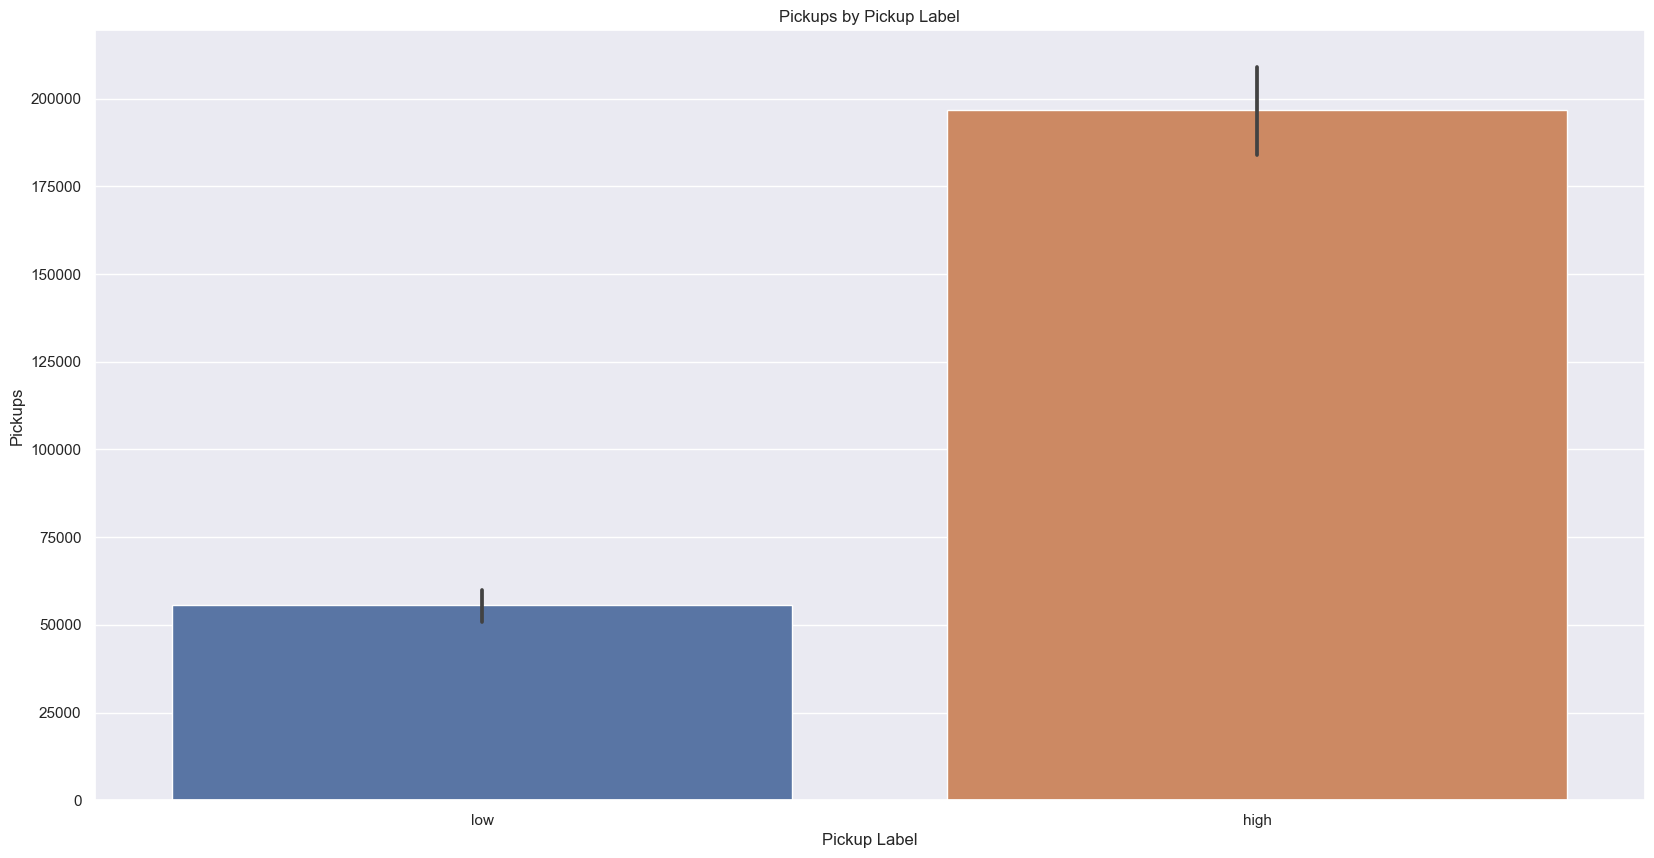

In [840]:
# plot for each pickup label the number of records
plt.figure(figsize=(20, 10))
sns.barplot(x='pickup_label', y='pickups', data=pickups_upsampled)
plt.title('Pickups by Pickup Label')
plt.xlabel('Pickup Label')
plt.ylabel('Pickups')
plt.show()


# Split data to training and testing set for both unbalanced and balanced data

In [222]:
# # Separate the features and target variable
# X = pickups_upsampled.drop(['pickup_label', 'pickups', 'start_borough_name'], axis=1)
# y = pickups_upsampled['pickup_label']

# # Split the data into training, testing, and validation sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42,stratify=y)

In [459]:
# Separate the features and target variable
X2 = pickups_merged_zero_fill.drop(['pickup_label', 'pickups','start_borough_name'], axis=1)
y2 = pickups_merged_zero_fill['pickup_label']

# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.25, random_state=42,stratify=y2) 

In [460]:
# pritn shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())

(108, 149)
(36, 149)
low     98
high    10
Name: pickup_label, dtype: int64
low     32
high     4
Name: pickup_label, dtype: int64


# Decision Tree Classifier

In [319]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Initialize the model
model = DecisionTreeClassifier(random_state=42)

# Define the initial parameters to search
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10],
    'min_samples_split': [1,2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5,6],
    'max_features': [ 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20

while overfitting and iteration < max_iterations:
    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the accuracy scores
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(train_acc, test_acc)

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_acc - test_acc) < 0.05:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]

        print('param_grid',iteration,":", param_grid)

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Print the classification report
print("Train Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [1, 2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced', None]}
Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
0.9814814814814815 1.0
Best parameters: {'class_weight': None, 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1}
Best score: 0.9818181818181818
Train Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.80      0.89        10
         low       0.98      1.00      0.99        98

    accuracy                           0.98       108
   macro avg       0.99      0.90      0.94       108
weighted avg       0.98      0.98      0.98       108

Test Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         4
         low       1.00      1.00      1.00      

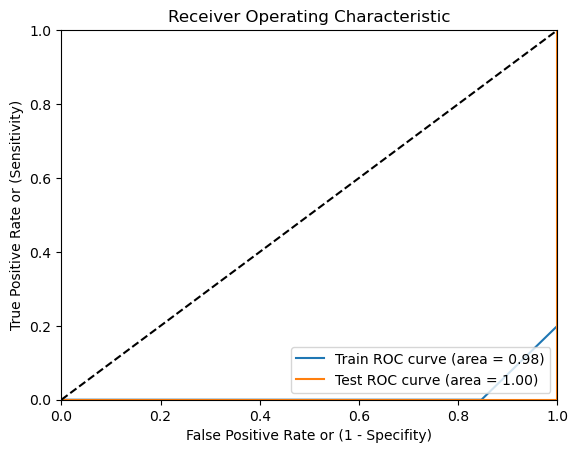

In [321]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities of the positive class
y_pred_prob_train = grid_search.predict_proba(X_train)[:, 1]
y_pred_prob_test = grid_search.predict_proba(X_test)[:, 1]

# Compute the ROC curve and ROC area for the training set
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train, pos_label='high')
roc_auc_train = roc_auc_score(y_train, y_pred_prob_train)

# Compute the ROC curve and ROC area for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test, pos_label='high')
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier

In [462]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Define the initial parameters to search
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50, 60, 80],
    'max_depth': [5, 6, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20


while overfitting and iteration < max_iterations:

    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the accuracy scores
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(train_acc, test_acc)

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_acc - test_acc) < 0.05 or train_acc < 0.99 or test_acc < 0.99:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]

        print('param_grid',iteration,":", param_grid)

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Print the classification report
print("Train Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'n_estimators': [5, 10, 20, 30, 40, 50, 60, 80], 'max_depth': [5, 6, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
Fitting 10 folds for each of 1200 candidates, totalling 12000 fits
1.0 1.0
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
Best score: 0.990909090909091
Train Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        10
         low       1.00      1.00      1.00        98

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108

Test Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         4
         low       1.00      1.00      1.00        32

    accuracy                           1.00        36
   macro avg       

In [280]:
from sklearn.ensemble import RandomForestClassifier

# first_model = RandomForestClassifier(max_depth= 3, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 40,random_state=42)

first_model = DecisionTreeClassifier(max_depth=3, min_samples_split=6, min_samples_leaf=5 ,random_state=42)
# 
# first_model = DecisionTreeClassifier(max_depth=6, min_samples_split=5, min_samples_leaf=9 ,random_state=42)


first_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=9,random_state=42)

In [281]:
from sklearn.metrics import accuracy_score, classification_report

#standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

first_model.fit(X2_train, y2_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=6,
                       random_state=42)

In [282]:


y_pred = first_model.predict(X_test)

# calculate accuracy of training
print('training score = ', first_model.score( X_train, y_train ))
print('test score = ', first_model.score( X_test, y_test ))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

training score =  0.9703703703703703
test score =  1.0
Accuracy: 1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        13
         low       1.00      1.00      1.00        32

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [283]:

from sklearn.metrics import accuracy_score, classification_report

y2_pred = first_model.predict(X2_test)

# calculate accuracy of training
print('training score = ', first_model.score( X2_test, y2_test ))

# Calculate accuracy
accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y2_test, y2_pred))

training score =  1.0
Accuracy: 1.0
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         4
         low       1.00      1.00      1.00        32

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [ ]:
# print confusion matrix for the model with labels
cm = confusion_matrix(y_test, y_pred)
print(cm)



[[30  0  0]
 [ 0 28  3]
 [ 1  2 27]]


In [ ]:
# print confusion matrix for the model with labels
cm = confusion_matrix(y2_train, y2_pred)
print(cm)



[[ 6  0  0]
 [ 0 63  7]
 [ 1  2 21]]


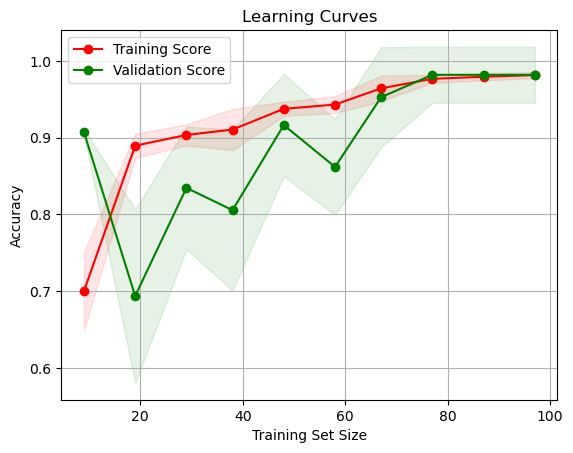

In [285]:

from sklearn.model_selection import learning_curve

# Calculate the learning curves
train_sizes, train_scores, val_scores = learning_curve(first_model, X2_train, y2_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curves
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
plt.legend(loc="best")

plt.show()

In [ ]:
# print the results of learning curve mean and standard deviation
print('train_scores_mean = ', train_scores_mean)
print('train_scores_std = ', train_scores_std)
print('val_scores_mean = ', val_scores_mean)
print('val_scores_std = ', val_scores_std)


train_scores_mean =  [0.5625     0.84242424 0.836      0.86268657 0.88333333 0.888
 0.89230769 0.89552239 0.89271523 0.89642857]
train_scores_std =  [0.         0.06470957 0.05276362 0.02567858 0.02308419 0.0183303
 0.01388725 0.01334966 0.01139381 0.00967147]
val_scores_mean =  [0.33333333 0.67619048 0.78095238 0.84285714 0.86190476 0.89047619
 0.87619048 0.87619048 0.87619048 0.87619048]
val_scores_std =  [0.         0.13602721 0.02776644 0.03229681 0.03499271 0.0386859
 0.05084323 0.05084323 0.05084323 0.05084323]


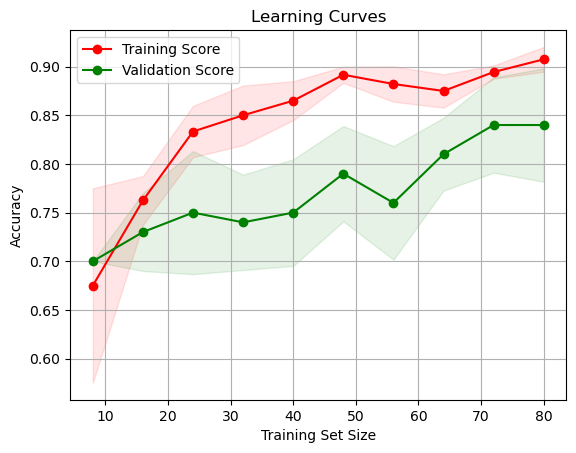

In [ ]:
from sklearn.model_selection import learning_curve

# Calculate the learning curves
train_sizes, train_scores, val_scores = learning_curve(first_model, X2_train, y2_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curves
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
plt.legend(loc="best")

plt.show()

In [ ]:
# print the results of learning curve mean and standard deviation
print('train_scores_mean = ', train_scores_mean)
print('train_scores_std = ', train_scores_std)
print('val_scores_mean = ', val_scores_mean)
print('val_scores_std = ', val_scores_std)


train_scores_mean =  [0.8        0.93333333 0.908      0.88059701 0.9047619  0.9049505
 0.91186441 0.93037037 0.93421053 0.93372781]
train_scores_std =  [0.1        0.01212121 0.016      0.02312229 0.01992048 0.00485047
 0.01376956 0.00362887 0.00832178 0.0114738 ]
val_scores_mean =  [0.59424142 0.79291251 0.76899225 0.7406423  0.81129568 0.82547065
 0.84440753 0.89601329 0.90542636 0.90066445]
val_scores_std =  [0.0193542  0.10175193 0.04007482 0.05768009 0.04522749 0.04896173
 0.03834935 0.0493472  0.03732087 0.03859894]


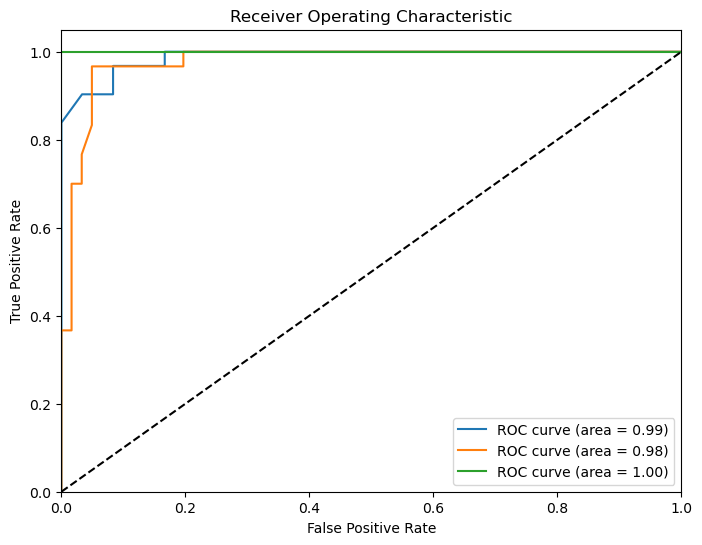

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# make y_test and y_train binary
y_test = label_binarize(y_test, classes=['low', 'medium', 'high'])
y_train = label_binarize(y_train, classes=['low', 'medium', 'high'])
n_classes = y_train.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(first_model)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# make y_test and y_train binary
y_test = label_binarize(y2_test, classes=['low', 'medium', 'high'])
y_train = label_binarize(y2_train, classes=['low', 'medium', 'high'])
n_classes = y_train.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(first_model)
y_score = classifier.fit(X2_train, y_train).predict_proba(X2_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [100, 210]

In [ ]:
importance = first_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print feature importance
print(feature_importance[feature_importance["Importance"] != 0])

                                               Feature  Importance
66                         full_time_annual_median_pay    0.466859
70                  female_full_time_weekly_median_pay    0.233486
0                                          start_month    0.126922
6                                         borough_name    0.086468
1                                     duration_minutes    0.061105
145                                         day_prob_2    0.023452
111  Health Deprivation and Disability - Proportion...    0.001709


In [ ]:
first_model = DecisionTreeClassifier(random_state=42)

In [ ]:
y2_test.value_counts()

low       17
medium    12
Name: pickup_label, dtype: int64

In [ ]:
# use random over-sampling to fix imbalance
from imblearn.over_sampling import RandomOverSampler

# Define the resampling method
method = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Separate the features and target variable
X = pickups_merged.drop(['pickup_label', 'pickups'], axis=1)
y = pickups_merged['pickup_label']

# Use SMOTE to upsample the minority classes
# Create the resampling method and fit the training data to it
X, y = method.fit_resample(X, y)

# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Print the value counts of the target variable
print(y_train.value_counts())

print(y_test.value_counts())

low       81
medium    81
high      80
Name: pickup_label, dtype: int64
high      21
low       20
medium    20
Name: pickup_label, dtype: int64


In [ ]:
# Separate the features and target variable
X2 = pickups_merged.drop(['pickup_label', 'pickups'], axis=1)
y2 = pickups_merged['pickup_label']

# Split the data into training, testing, and validation sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=33 )

In [ ]:
y2_train.value_counts()

low       86
medium    27
high       2
Name: pickup_label, dtype: int64

In [ ]:
from sklearn.model_selection import StratifiedKFold

from sklearn.utils.class_weight import compute_class_weight

# define weights for each class with different combinations for low medium and high
class_labels = ['low', 'medium', 'high']
class_counts = [101, 35, 8]
total_samples = np.sum(class_counts)
class_proportions = class_counts / total_samples

# Calculate inverse class weights
class_weights = 1 / class_proportions
class_weights /= np.max(class_weights)  # Normalize weights

# Convert class weights to a dictionary
class_weight_dict = [{class_labels[i]: class_weights[i] for i in range(len(class_labels))}]

print(class_weight_dict)


# Define the hyperparameters and their values to search
param_grid = {
    'max_depth': [4,5,6,7,8,9],
    'min_samples_split': [ 4,5,6,7,8],
    'min_samples_leaf': [5,6,7,8,9],
    
}


# Define the cross-validator with shuffling
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create an instance of GridSearchCV and fit the data
grid_search = GridSearchCV(estimator=first_model, param_grid=param_grid, cv=cv, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

print('training score = ', grid_search.score( X_train, y_train ))

y_pred = grid_search.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)

# print accuracy for X2_test and y2_test
y2_pred = grid_search.predict(X2_test)

test_accuracy2 = accuracy_score(y2_test, y2_pred)

print("Test Accuracy:", test_accuracy2)

# # save the model to disk
# filename = './Final Data Files/finalized_model.sav'
# pickle.dump(grid_search, open(filename, 'wb'))

# load the model from disk
    

[{'low': 0.07920792079207922, 'medium': 0.2285714285714286, 'high': 1.0}]
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4}
Best Score: 0.913
training score =  0.9669421487603306
Test Accuracy: 0.9508196721311475
Test Accuracy: 0.9310344827586207


In [ ]:
y2_test.value_counts()

low       15
medium     8
high       6
Name: pickup_label, dtype: int64

In [ ]:
# class_weight={'low': 0.07920792079207922, 'medium': 0.2285714285714286, 'high': 1.0} ,max_depth=5, min_samples_leaf=15, min_samples_split=5, 
# max_depth=4, min_samples_leaf=5, min_samples_split=5, random_state=42
from sklearn.metrics import accuracy_score, classification_report

first_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4,random_state=42)

first_model.fit(X_train, y_train)

y_pred = first_model.predict(X_test)

# calculate accuracy of training
print('training score = ', first_model.score( X_train, y_train ))
print('test score = ', first_model.score( X_test, y_test ))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))



training score =  0.9669421487603306
test score =  0.9508196721311475
Accuracy: 0.9508196721311475
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        21
         low       0.95      0.90      0.92        20
      medium       0.90      0.95      0.93        20

    accuracy                           0.95        61
   macro avg       0.95      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [ ]:
y2_pred = first_model.predict(X2_test)

# calculate accuracy of training
print('training score = ', first_model.score( X2_train, y2_train ))
print('test score = ', first_model.score( X2_test, y2_test ))

# Calculate accuracy
accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y2_test, y2_pred))

training score =  0.9478260869565217
test score =  0.9310344827586207
Accuracy: 0.9310344827586207
              precision    recall  f1-score   support

        high       1.00      1.00      1.00         6
         low       0.93      0.93      0.93        15
      medium       0.88      0.88      0.88         8

    accuracy                           0.93        29
   macro avg       0.94      0.94      0.94        29
weighted avg       0.93      0.93      0.93        29



In [ ]:
# print confusion matrix for the model with labels
cm = confusion_matrix(y2_test, y2_pred)
print(cm)

[[ 6  0  0]
 [ 0 14  1]
 [ 0  1  7]]


In [ ]:
# print confusion matrix for the model with labels
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[21  0  0]
 [ 0 18  2]
 [ 0  1 19]]


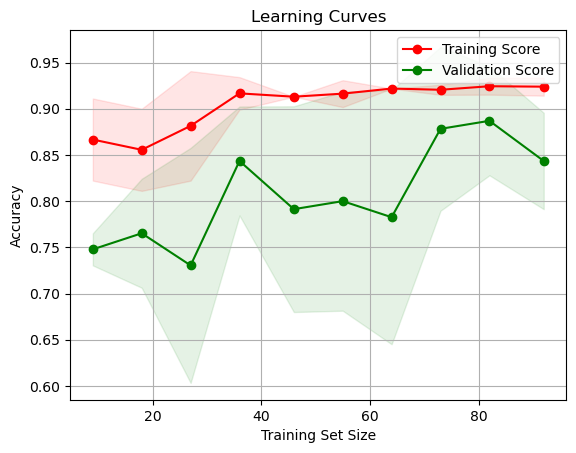

In [ ]:

from sklearn.model_selection import learning_curve

# Calculate the learning curves
train_sizes, train_scores, val_scores = learning_curve(first_model, X2_train, y2_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curves
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
plt.legend(loc="best")

plt.show()

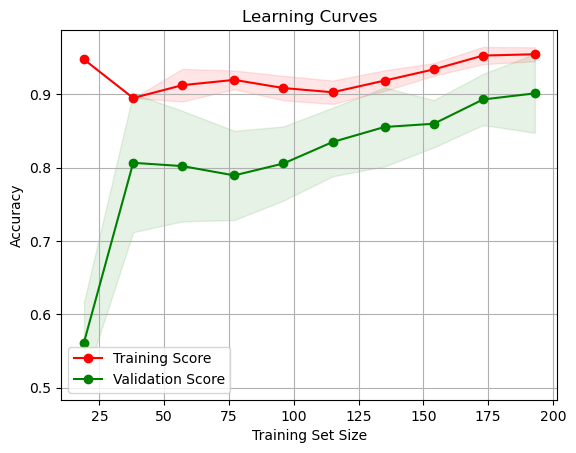

In [ ]:

from sklearn.model_selection import learning_curve

# Calculate the learning curves
train_sizes, train_scores, val_scores = learning_curve(first_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curves
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")
plt.legend(loc="best")

plt.show()

In [323]:
bike_data_merged.head()

rental_id    end_date  endstation_id                   endstation_name  \
0   91113807  2019-09-11            125  Borough High Street, The Borough   
1   91114507  2019-09-11            125  Borough High Street, The Borough   
2   91113525  2019-09-11            125  Borough High Street, The Borough   
3   91114103  2019-09-11            125  Borough High Street, The Borough   
4   91114706  2019-09-11            278         Tooley Street, Bermondsey   

   start_date  startstation_id              startstation_name  \
0  2019-09-11               10          Park Street, Bankside   
1  2019-09-11              409      Strata, Elephant & Castle   
2  2019-09-11              298     Curlew Street, Shad Thames   
3  2019-09-11              321  Bermondsey Street, Bermondsey   
4  2019-09-11              194      Hop Exchange, The Borough   

       start_timestamp        end_timestamp  start_day  start_month  \
0  2019-09-11 13:21:00  2019-09-11 13:25:00         11            9   
1  2019-09-11 13:50:00  2019-09-11 13:54:00         11            9   
2  2019-09-11 13:10:00  2019-09-11 13:29:00         11            9   
3  2019-09-11 13:33:00  2019-09-11 13:39:00         11            9   
4  2019-09-11 13:58:00  2019-09-11 14:02:00         11            9   

   start_year  start_hour start_day_of_week  end_day  end_month  end_year  \
0        2019          13         Wednesday       11          9      2019   
1        2019          13         Wednesday       11          9      2019   
2        2019          13         Wednesday       11          9      2019   
3        2019          13         Wednesday       11          9      2019   
4        2019          13         Wednesday       11          9      2019   

   end_hour end_day_of_week  bank_holiday  peak_hour  duration_minutes  \
0        13       Wednesday             0          0               4.0   
1        13       Wednesday             0          0               4.0   
2        13       Wednesday             0          0              19.0   
3        13       Wednesday             0          0               6.0   
4        14       Wednesday             0          0               4.0   

   start_number_of_bikes  start_number_of_empty_docks  start_number_of_docks  \
0                      5                           13                     18   
1                     32                            9                     41   
2                     13                            8                     21   
3                     24                            0                     24   
4                     23                            9                     32   

   start_number_standard_bikes  start_number_ebikes  \
0                            5                    0   
1                           30                    2   
2                           13                    0   
3                           23                    1   
4                           23                    0   

              start_geometry start_borough_code start_borough_name  \
0  POINT (-0.09275 51.50597)          E09000028          Southwark   
1  POINT (-0.09983 51.49315)          E09000028          Southwark   
2  POINT (-0.07419 51.50228)          E09000028          Southwark   
3  POINT (-0.08161 51.49786)          E09000028          Southwark   
4  POINT (-0.09177 51.50463)          E09000028          Southwark   

   end_number_of_bikes  end_number_of_empty_docks  end_number_of_docks  \
0                   15                          6                   21   
1                   15                          6                   21   
2                   15                          6                   21   
3                   15                          6                   21   
4                   15                         12                   27   

   end_number_standard_bikes  end_number_ebikes               end_geometry  \
0                         15                  0  POINT (-0

In [738]:
pickups_hourly = bike_data_merged.groupby(['start_year','start_month','start_day','start_hour'], as_index=False).agg({
    'rental_id': 'count', 
    'duration_minutes': 'mean',
    'bank_holiday': 'first',
    'peak_hour': 'first',
    'start_number_of_bikes': 'mean', 
    'start_number_of_docks': 'mean',
    'start_number_of_empty_docks':'mean',
    'start_number_standard_bikes':'mean',
    'start_number_ebikes':'mean',
    'temp': 'first',
    'feelslike': 'first',
    'humidity': 'first',
    'windspeed':   'first',
    'cloudcover': 'first',
    'visibility':  'first',
    'uvindex': 'first',
    'dew': 'first',
    'precip': 'first',
    })


# rename rental_id in pickups_monthly to pickups
pickups_hourly.rename(columns={"rental_id": "pickups"},errors="raise", inplace = True)

# merge demographics with pickups_monthly
# pickups_merged = pickups_monthly.merge(demographics, how='inner', left_on=["start_borough_code"],right_on='borough_code')




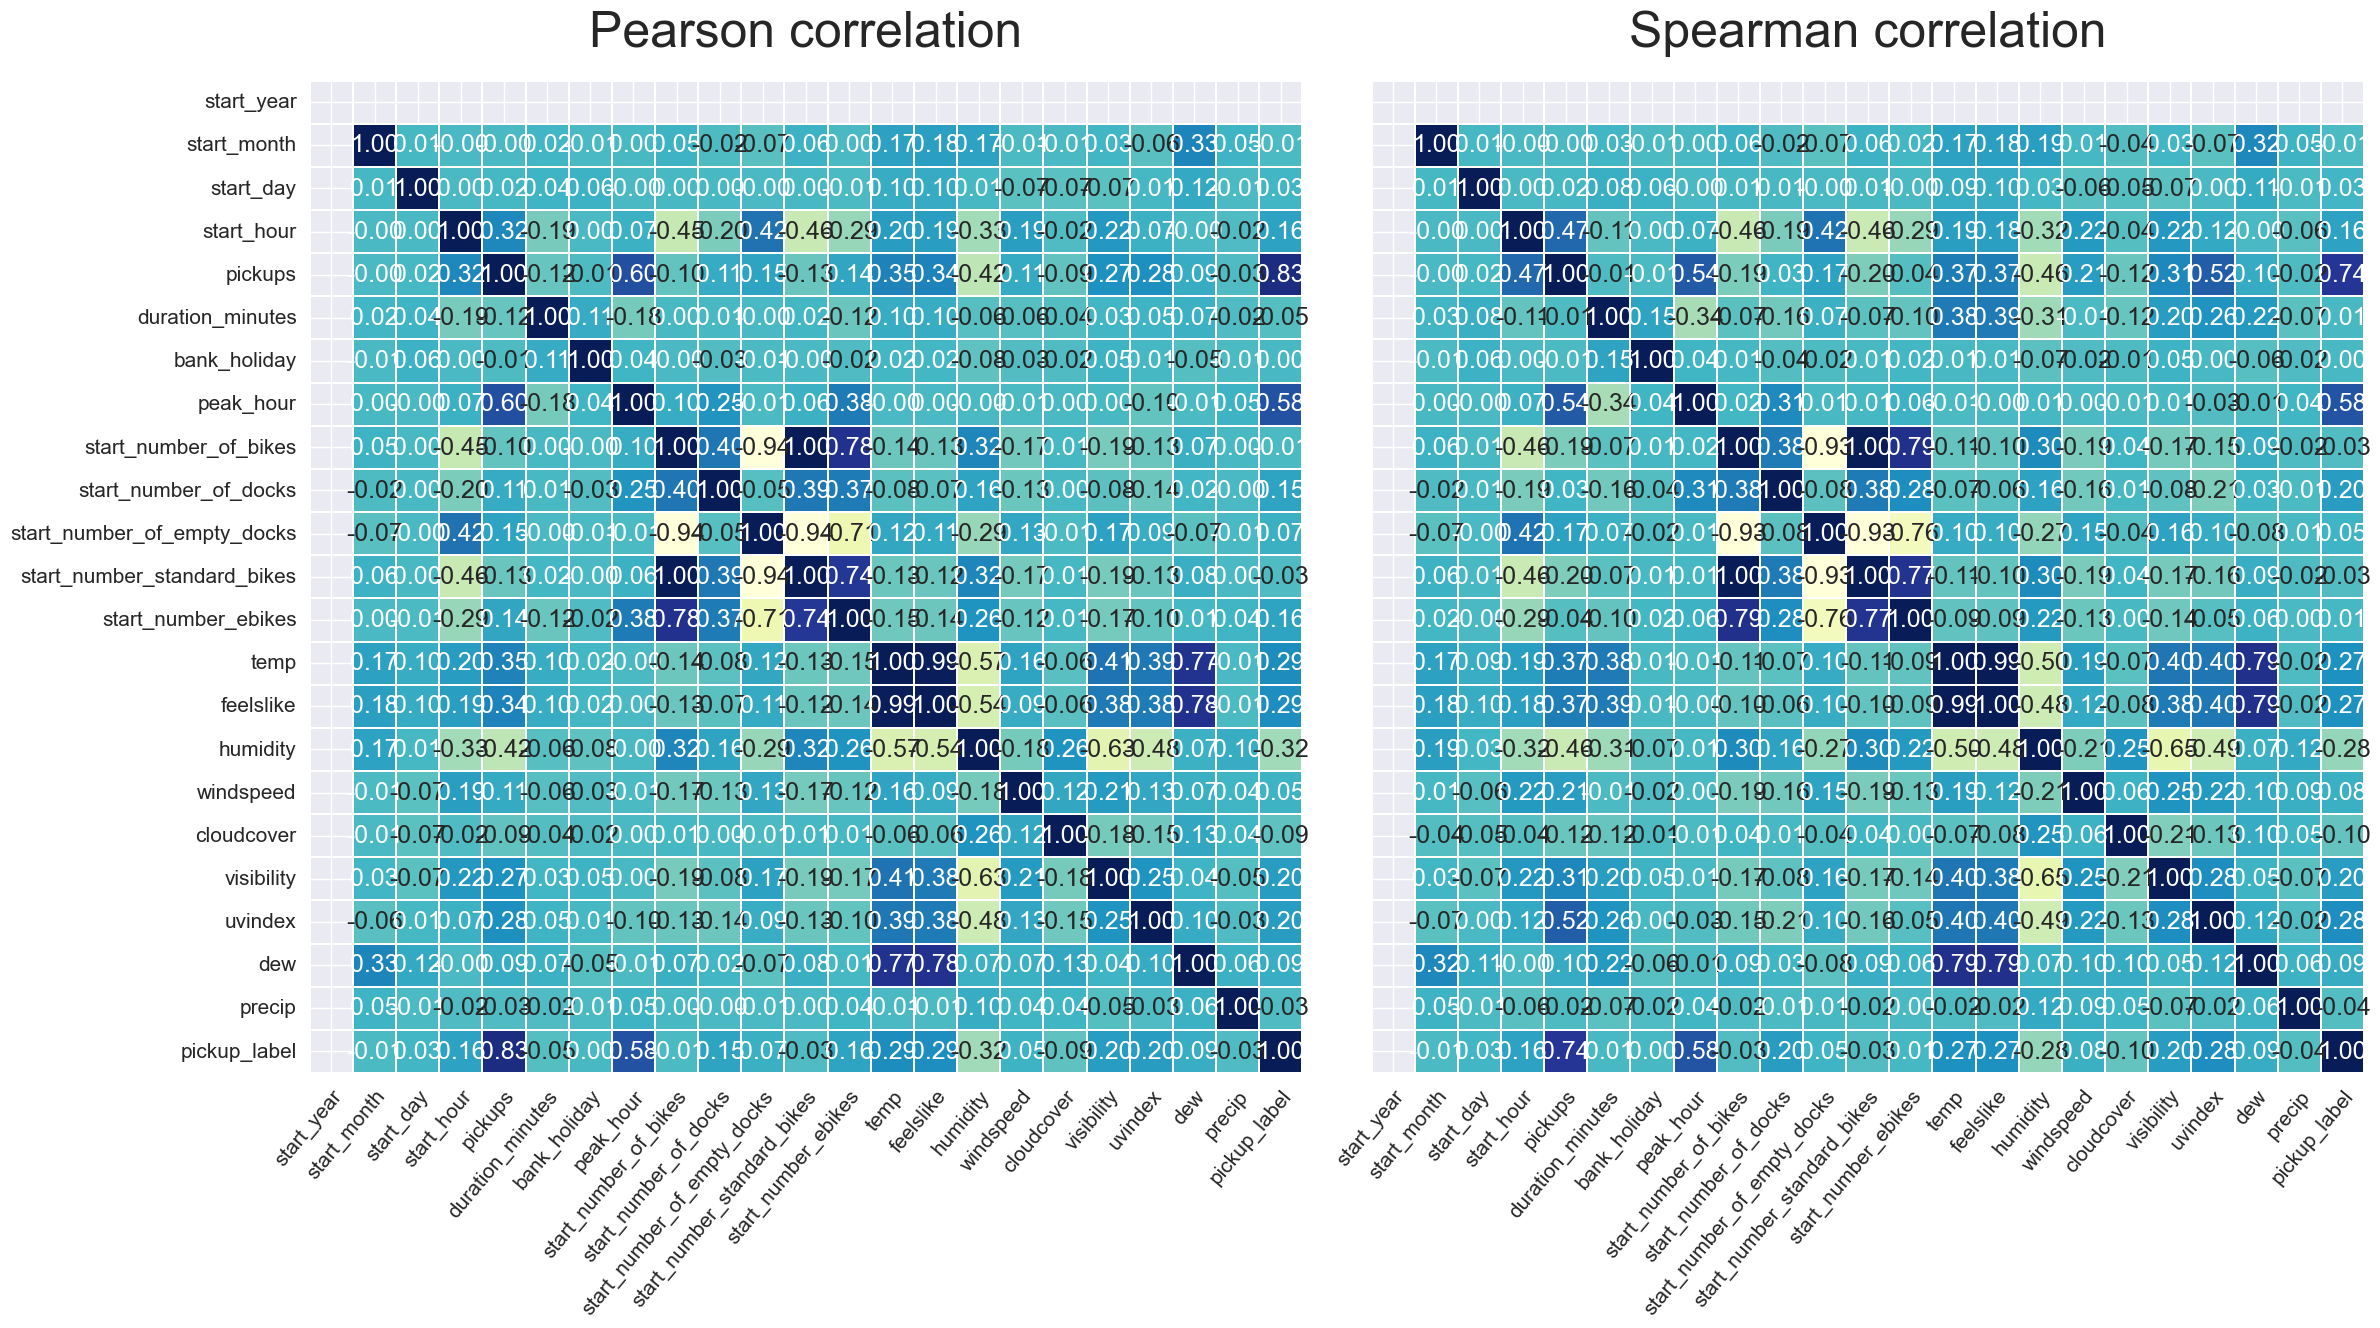

In [795]:
sns.set()

# Draw a heatmap with the numeric values in each cell
fig = plt.figure(figsize=(24, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax_array = [ax1, ax2]
correlation_data = [pickups_hourly.corr(method='pearson'), pickups_hourly.corr(method='spearman')]
titles_array = ['Pearson correlation', 'Spearman correlation']

# We use axs parameter to tell seaborn which subplot to use for this plot
for axs, data, titles in zip(ax_array, correlation_data, titles_array):
    sns.heatmap(data = data, fmt='.2f', cbar=False, square=True, cmap="YlGnBu", annot=True, annot_kws={"fontsize":18}, linewidths=.05, ax=axs)
    axs.set_title(titles, fontsize=36, pad=25)
    axs.set_xticklabels(ax1.get_xticklabels(), fontsize=15, rotation=50, ha="right", rotation_mode="anchor")
    axs.set_yticklabels(ax1.get_yticklabels(), fontsize=15)
# Y axis description on the left side only
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()

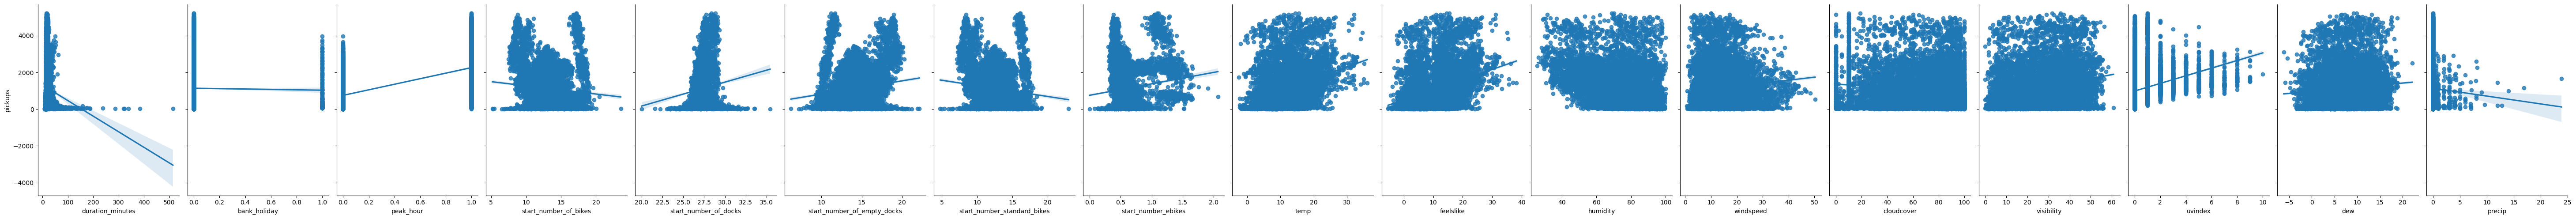

In [740]:
# plot scatter matrix for pickups and all other features
sns.pairplot(pickups_hourly, x_vars=['duration_minutes', 'bank_holiday', 'peak_hour', 'start_number_of_bikes', 'start_number_of_docks', 'start_number_of_empty_docks', 'start_number_standard_bikes', 'start_number_ebikes', 'temp', 'feelslike', 'humidity', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'dew', 'precip'], y_vars='pickups', height=5, aspect=0.7, kind='reg')
plt.show()
    

In [409]:
pickups_hourly.shape

(288, 20)

In [410]:
pickups_hourly

start_hour      start_borough_name  pickups  duration_minutes  \
0             0                  Camden     6655         27.486852   
1             0          City of London     3577         22.385519   
2             0                 Hackney     4576         21.014423   
3             0  Hammersmith and Fulham     5534         20.178352   
4             0               Islington     3514         23.226807   
..          ...                     ...      ...               ...   
283          23                  Newham      803         39.668742   
284          23               Southwark     9454         20.624709   
285          23           Tower Hamlets    22098         18.217848   
286          23              Wandsworth     5985         19.212698   
287          23             Westminster    32083         23.368980   

     bank_holiday  peak_hour  start_number_of_bikes  start_number_of_docks  \
0        0.036814          0               9.811119              29.238768   
1        0.062063          0               0.822756              26.023204   
2        0.032561          0              19.212850              32.178103   
3        0.026021          0              21.220817              29.401518   
4        0.026466          0              10.356858              24.314456   
..            ...        ...                    ...                    ...   
283      0.032379          0              32.159402              34.293898   
284      0.016501          0              17.346308              30.093188   
285      0.020816          0              13.359987              30.051815   
286      0.017043          0              22.488722              27.494403   
287      0.028426          0               6.026961              25.010348   

     start_number_of_empty_docks  start_number_standard_bikes  \
0                      19.427648                     9.435763   
1                      25.200447                     0.716522   
2                      12.965253                    18.698645   
3                       8.180701                    20.398265   
4                      13.957598                     9.660501   
..                           ...                          ...   
283                     2.134496                    31.132005   
284                    12.746880                    16.823461   
285                    16.691827                    12.613585   
286                     5.005681                    21.557393   
287                    18.983387                     5.707010   

     start_number_ebikes       temp  feelslike   humidity  windspeed  \
0               0.375357  11.990924  11.294050  78.077790  10.880331   
1               0.106234  11.915348  11.181521  78.424873  10.943919   
2               0.514205  12.593575  12.000087  77.005824  10.678191   
3               0.822551  12.301626  11.669498  77.962962  10.861782   
4               0.696357  12.206574  11.541776  78.025857  11.084889   
..                   ...        ...        ...        ...        ...   
283             1.027397  15.292653  14.998381  71.674496  10.758032   
284             0.522847  12.999672  12.466332  75.363666  11.188777   
285             0.746402  12.984714  12.460576  75.136930  11.111046   
286             0.931328  13.225146  12.695522  74.979373  11.115038   
287             0.319951  12.874276  12.338008  75.131624  11.034006   

     cloudcover  visibility  uvindex       dew    precip  
0     62.921082   25.006672      0.0  8.111119  0.184399  
1     63.898490   24.746491      0.0  8.116410  0.182539  
2     62.456884   25.401508      0.0  8.486254  0.120698  
3     62.691453   25.262450      0.0  8.395934  0.175527  
4     63.893654   24.730108      0.0  8.315566  0.181398  
..          ...         ...      ...       ...       ...  
283   61.520299   29.484060      0.0  9.969489  0.000000  
284   62.533097   27.136641      0.0  8.521525  0.000000  
285   63.181157   27.311653      0.0  8.457824  0.

In [741]:
# find null values
pickups_hourly.isnull().sum()

start_year                     0
start_month                    0
start_day                      0
start_hour                     0
pickups                        0
duration_minutes               0
bank_holiday                   0
peak_hour                      0
start_number_of_bikes          0
start_number_of_docks          0
start_number_of_empty_docks    0
start_number_standard_bikes    0
start_number_ebikes            0
temp                           0
feelslike                      0
humidity                       0
windspeed                      0
cloudcover                     0
visibility                     0
uvindex                        0
dew                            0
precip                         0
dtype: int64

/var/folders/pz/y4y03t6d7cd_76njhx8sjzzm0000gn/T/ipykernel_13852/3109241262.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pickups_hourly['pickups'], bins=20, kde=False)


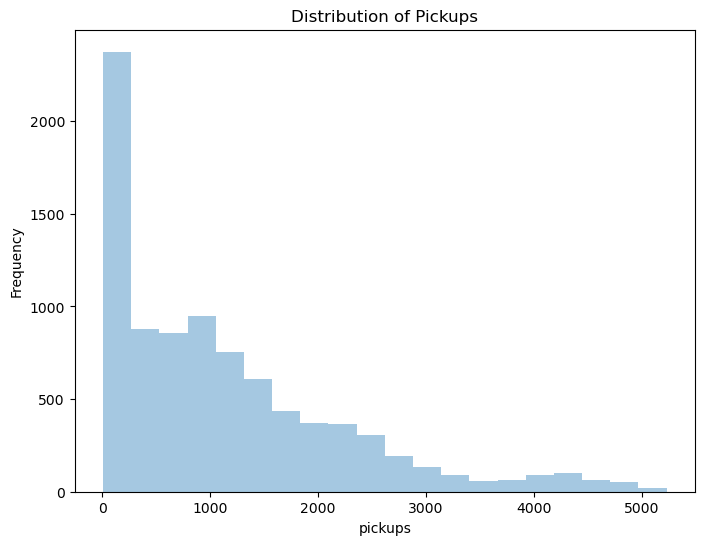

In [742]:
# Some EDA for the dataset and plot the distribution of the target variable
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
sns.distplot(pickups_hourly['pickups'], bins=20, kde=False)
plt.title('Distribution of Pickups')
plt.ylabel('Frequency')
plt.show()

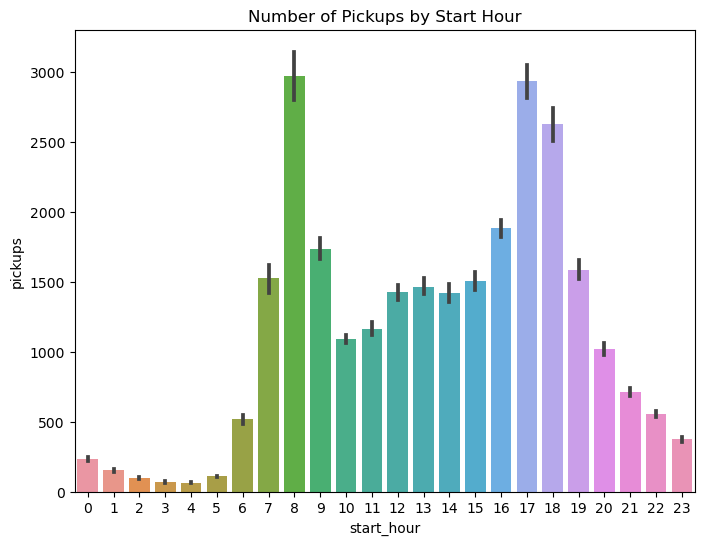

In [743]:
# plot number of pickups by start hour
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
sns.barplot(x='start_hour', y='pickups', data=pickups_hourly)
plt.title('Number of Pickups by Start Hour')
plt.show()


In [744]:
#  check for outliers across boroughs
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
sns.boxplot(x='start_borough_code', y='pickups', data=pickups_hourly)
plt.title('Number of Pickups by Borough')
plt.show()



ValueError: Could not interpret input 'start_borough_code'

<Figure size 800x600 with 0 Axes>

In [347]:
# show least number of pickups by start hour
pickups_hourly[pickups_hourly['pickups'] == pickups_hourly['pickups'].min()]

start_hour start_borough_name  pickups  duration_minutes  bank_holiday  \
55           4             Newham       42          59.02381      0.047619   

    peak_hour  start_day_of_week  start_number_of_bikes  \
55        0.0                0.0              33.452381   

    start_number_of_docks  start_number_of_empty_docks  \
55              35.738095                     2.285714   

    start_number_standard_bikes  start_number_ebikes      temp  feelslike  \
55                    32.738095             0.714286  9.861905   9.259524   

     humidity  windspeed  cloudcover  visibility  uvindex       dew  precip  
55  85.287381  10.447619    58.67619   18.011905      0.0  7.380952     0.0

In [450]:
# remove data from start_hour 2,3, 4 and 5
pickups_hourly = pickups_hourly[pickups_hourly['start_hour'].isin([0,1,2,3,4,5]) == False]

In [444]:
# use label encoding to convert start_borough_name to numeric
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Convert the labels in 'start_borough_name' to numeric values
pickups_hourly['start_borough_code'] = encoder.fit_transform(pickups_hourly['start_borough_name'])

#drop start_borough_name
pickups_hourly.drop(['start_borough_name'], axis=1, inplace=True)

/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

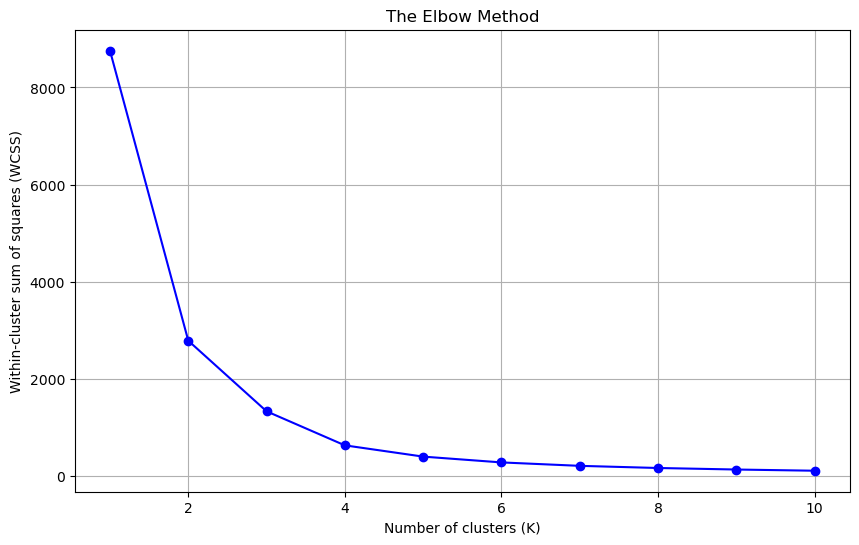

In [745]:
wcss = []

# Range of K values to try
K_range = range(1, 11)

#standardize pickups_hourly['pickups'].values.reshape(-1, 1)
scaled_features = scaler.fit_transform(pickups_hourly['pickups'].values.reshape(-1, 1))

# For each value of K, fit the K-means model and calculate WCSS
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot WCSS vs. K
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, 'bo-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.grid(True)
plt.show()

/Users/mohammadmaraqa/opt/anaconda3/envs/proj/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.648


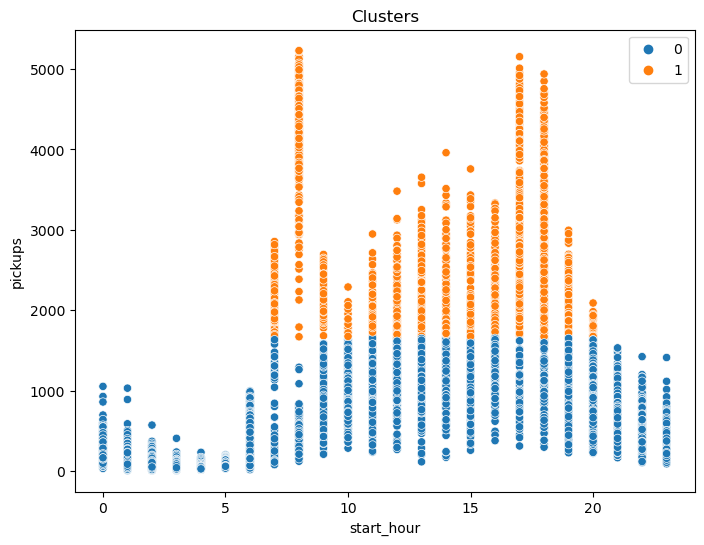

Silhouette Score: 0.648


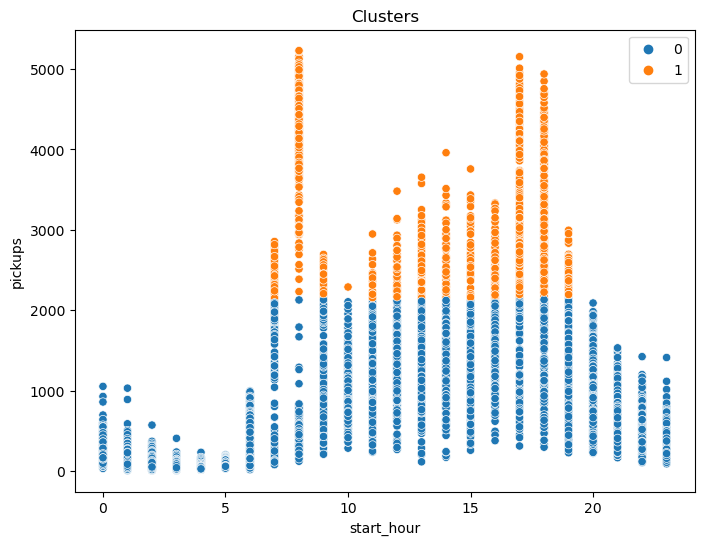

In [749]:
# clustering using k-means
from sklearn.cluster import KMeans

# Initialize the model with two parameters -- number of clusters and random state
kmeans = KMeans(n_clusters=2, random_state=42)

#standardize pickups_hourly['pickups'].values.reshape(-1, 1)
values = scaler.fit_transform(pickups_hourly['pickups'].values.reshape(-1, 1))

# Fit the model to the data
kmeans.fit(values)

# Calculate the cluster labels
labels = kmeans.labels_

# calculate the silhouette score
from sklearn.metrics import silhouette_score

score = silhouette_score(pickups_hourly, labels)

print('Silhouette Score: %.3f' % score)

# plot the clusters
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
sns.scatterplot(x='start_hour', y='pickups', hue=labels, data=pickups_hourly)
plt.title('Clusters')
plt.show()

# try different clustering algorithms
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Initialize the models with two parameters -- number of clusters and random state
agg = AgglomerativeClustering(n_clusters=2)
dbscan = DBSCAN(eps=0.05)

# Fit the models to the data
agg.fit(values)

# Calculate the cluster labels
labels_agg = agg.labels_

#print silhouette score
score = silhouette_score(pickups_hourly, labels_agg)

print('Silhouette Score: %.3f' % score)

# plot the clusters
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
sns.scatterplot(x='start_hour', y='pickups', hue=labels_agg, data=pickups_hourly)
plt.title('Clusters')
plt.show()

pickups_hourly['pickup_label'] = labels


In [750]:
pickups_hourly['pickup_label'].value_counts()

0    6613
1    2144
Name: pickup_label, dtype: int64

In [736]:
# create a new dataframe with only label 1
pickups_hourly[pickups_hourly['pickup_label'] == 0]


start_hour  pickups  duration_minutes  bank_holiday  peak_hour  \
72            6    13505         15.158830      0.006072          1   
73            6     9814         12.237416      0.003974          1   
74            6    12501         12.161347      0.004960          1   
75            6    13071         15.549078      0.004667          1   
76            6     9334         12.654060      0.004714          1   
..          ...      ...               ...           ...        ...   
283          23      803         39.668742      0.032379          0   
284          23     9454         20.624709      0.016501          0   
285          23    22098         18.217848      0.020816          0   
286          23     5985         19.212698      0.017043          0   
287          23    32083         23.368980      0.028426          0   

     start_number_of_bikes  start_number_of_docks  \
72               18.539134              32.893077   
73                0.880681              25.897290   
74               24.314535              32.575474   
75               21.419937              29.111698   
76               13.033748              24.908721   
..                     ...                    ...   
283              32.159402              34.293898   
284              17.346308              30.093188   
285              13.359987              30.051815   
286              22.488722              27.494403   
287               6.026961              25.010348   

     start_number_of_empty_docks  start_number_standard_bikes  \
72                     14.353943                    18.239689   
73                     25.016609                     0.770634   
74                      8.260939                    23.728982   
75                      7.691760                    20.485043   
76                     11.874973                    12.097707   
..                           ...                          ...   
283                     2.134496                    31.132005   
284                    12.746880                    16.823461   
285                    16.691827                    12.613585   
286                     5.005681                    21.557393   
287                    18.983387                     5.707010   

     start_number_ebikes       temp  feelslike   humidity  windspeed  \
72              0.299445   9.906250   9.082207  84.510856   9.897216   
73              0.110047   9.763521   8.892083  84.734012  10.038221   
74              0.585553   9.975306   9.140517  84.534684   9.989033   
75              0.934894  10.019884   9.207329  84.778056   9.932461   
76              0.936040   9.666392   8.789629  84.650202   9.962031   
..                   ...        ...        ...        ...        ...   
283             1.027397  15.292653  14.998381  71.674496  10.758032   
284             0.522847  12.999672  12.466332  75.363666  11.188777   
285             0.746402  12.984714  12.460576  75.136930  11.111046   
286             0.931328  13.225146  12.695522  74.979373  11.115038   
287             0.319951  12.874276  12.338008  75.131624  11.034006   

     cloudcover  visibility  uvindex       dew    precip  start_borough_code  \
72    66.914232   20.412210      0.0  7.348093  0.173471                   0   
73    67.080018   20.407408      0.0  7.247483  0.172575                   1   
74    66.695672   20.611879      0.0  7.418703  0.188550                   2   
75    66.547097   20.658680      0.0  7.505141  0.189890                   3   
76    66.900204   20.423066      0.0  7.135880  0.181356                   4   
..          ...         ...      ...       ...       ...                 ...   
283   61.520299   29.484060      0.0  9.969489  0.000000                   7   
284   62.533097   27.136641      0.0  8.521525  0.000000                   8   
285   63.181157   27.311653      0.0  8.457824  0.000000                   9   
286   62.274135   27.136107      0.0  8.648037  0.000000             

In [682]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Separate the features and target variable
X = pickups_hourly_label1.drop(['pickups','pickup_label'], axis=1)
y = pickups_hourly_label1['pickup_label']

# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33 )

# Initialize the model
model = DecisionTreeClassifier(max_depth=12, random_state=42)

# Fit the grid search
model.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# overfitting = True
# iteration = 0
# max_iterations = 20

# while overfitting and iteration < max_iterations:
#     print('param_grid',iteration,":", param_grid)

#     # Fit the grid search
#     grid_search.fit(X_train, y_train)

#     # Make predictions on the training and test sets
#     y_pred_train = grid_search.predict(X_train)
#     y_pred_test = grid_search.predict(X_test)

#     # Compute the accuracy scores
#     train_acc = accuracy_score(y_train, y_pred_train)
#     test_acc = accuracy_score(y_test, y_pred_test)
    
#     print(train_acc, test_acc)

#     # Check if the difference between the train and test score is below the threshold
#     if np.abs(train_acc - test_acc) < 0.05:
#         overfitting = False
#     else:
#         # Adjust the parameters and repeat the grid search
#         param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
#         param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
#         param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]

#         print('param_grid',iteration,":", param_grid)

#     # Increase the iteration counter
#     iteration += 1

# # Print the best parameters and score
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
    
print(train_acc, test_acc)

# Print the classification report
print("Train Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(model.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


1.0 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163

    accuracy                           1.00       163
   macro avg       1.00      1.00      1.00       163
weighted avg       1.00      1.00      1.00       163

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41

Feature importances:
windspeed 0.0
visibility 0.0
uvindex 0.0
temp 0.0
start_number_standard_bikes 0.0
start_number_of_empty_docks 0.0
start_number_of_docks 0.0
start_number_of_bikes 0.0
start_number_ebikes 0.0
start_hour 0.0
start_borough_code 0.0
precip 0.0
peak_hour 0.0
humidity 0.0
feelslike 0.0
duration_minutes 0.0
dew 0.0
cloudcover 0.0
bank_holiday 0.0


In [ ]:
# Calculate the total number of missing values in each column of the merged_dataset DataFrame
missing_values = merged_dataset.isnull().sum()

# Calculate the total number of rows in the DataFrame
total_rows = len(merged_dataset)

# Calculate the percentage of missing values in each column
percentage_missing = (missing_values / total_rows) * 100

# Sort the percentage of missing values in descending order
percentage_missing_sorted = percentage_missing.sort_values(ascending=False)

# Print the percentage of missing values in each column, sorted in descending order
print("Percentage of missing values in each column:")
print(percentage_missing_sorted)


Percentage of missing values in each column:
Male Part Time Workers - mean_annual                                                                66.666667
Female Part Time Workers  - median_annual                                                           64.583333
% in employment working part-time - aged 16-19                                                      58.333333
Part Time Workers  - median_annual                                                                  56.250000
Male Part Time Workers  - median_weekly                                                             43.750000
Male Part Time Workers  - median_hourly                                                             41.666667
Male Part Time Workers  - mean_weekly                                                               39.583333
Male Part Time Workers - mean_hourly                                                                33.333333
Female Part Time Workers - mean_annual                                     

In [ ]:
# Plot
plt.figure(figsize=(10,8))  # Adjust the size of the figure
percentage_missing_sorted.plot(kind='bar')
plt.title('Percentage of Missing Values in Each Column')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')  # Rotate column names for better visibility
plt.tight_layout()  # Adjust layout for better visibility
plt.show()

In [822]:
# initialise decision tree regressor
# train a decision tree regressor model on the training set with grid search and validation
# import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier


# Separate the features and target variable
X = pickups_hourly.drop(['pickups','pickup_label'], axis=1)
y = pickups_hourly['pickups']

# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33 )


model = RandomForestClassifier(n_estimators= 50,random_state=42)
# max_depth=6, min_samples_split=5, min_samples_leaf=9

# execute the grid search
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)

# print the r2 score
print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred))


# Compute the RMSE on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Mean Squared Error:', rmse_train, mse)


# print the feature importances in descending order
sorted(zip(model.feature_importances_, X_train.columns), reverse=True)



1.0
0.7412710155471534
Mean Squared Error: 0.0 541.2863952140638


[(0.06983679523354348, 'duration_minutes'),
 (0.06881009012732059, 'windspeed'),
 (0.06875803620286543, 'start_number_of_docks'),
 (0.06814811714398478, 'visibility'),
 (0.06780627509082282, 'start_number_ebikes'),
 (0.06725645327671972, 'humidity'),
 (0.0671899999964122, 'start_number_of_empty_docks'),
 (0.06242938093592763, 'start_number_standard_bikes'),
 (0.062154392924124634, 'dew'),
 (0.061248355964273776, 'start_number_of_bikes'),
 (0.05916761415526169, 'cloudcover'),
 (0.05905111358788772, 'feelslike'),
 (0.057842632245588124, 'temp'),
 (0.05460191621089797, 'start_day'),
 (0.03916804165946147, 'start_month'),
 (0.03657366708811836, 'start_hour'),
 (0.013959224576372284, 'uvindex'),
 (0.009018151994855271, 'precip'),
 (0.004387881896233084, 'peak_hour'),
 (0.002591859689328949, 'bank_holiday'),
 (0.0, 'start_year')]

In [846]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import random

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Separate the features and target variable
X = pickups_hourly.drop(['pickups','pickup_label'], axis=1)
y = pickups_hourly['pickups']

# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33 )

# Define the initial parameters to search
param_grid = {
    'n_estimators': [5, 10, 20, 30, 40, 50, 60, 80, 100, 110],
    'max_depth': [5, 6, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)

overfitting = True
iteration = 0
max_iterations = 20


while overfitting and iteration < max_iterations:

    print('param_grid',iteration,":", param_grid)

    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    print("best params:", grid_search.best_params_)

    # Make predictions on the training and test sets
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)

    # Compute the R2 scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(train_r2, test_r2)
    
    # Compute and print the RMSE
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

    # Check if the difference between the train and test score is below the threshold
    if np.abs(train_r2 - test_r2) < 0.005:
        overfitting = False
    else:
        # Adjust the parameters and repeat the grid search
        param_grid['max_depth'] = [random.randint(2, 10) if d <= 2 else d-1 for d in param_grid['max_depth']]
        param_grid['min_samples_split'] = [random.randint(2, 10) if s >= 10 else s+1 for s in param_grid['min_samples_split']]
        param_grid['min_samples_leaf'] = [random.randint(1, 10) if l >= 10 else l+1 for l in param_grid['min_samples_leaf']]
        param_grid['n_estimators'] = [random.randint(5, 150) if n >= 150 else n+10 for n in param_grid['n_estimators']]

        
        print('param_grid',iteration,":", param_grid)
        

    # Increase the iteration counter
    iteration += 1

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Compute and print the RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Print the feature importances
print("Feature importances:")
for importance, name in sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True):
    print(name, importance)


param_grid 0 : {'n_estimators': [5, 10, 20, 30, 40, 50, 60, 80, 100, 110], 'max_depth': [5, 6, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
0.9770746420341235 0.9466186003986196
Train RMSE: 166.0506420669927
Test RMSE: 245.8666069437066
param_grid 0 : {'n_estimators': [15, 20, 30, 40, 50, 60, 70, 90, 110, 120], 'max_depth': [4, 5, 7, 8, 9], 'min_samples_split': [3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6, 7]}
param_grid 1 : {'n_estimators': [15, 20, 30, 40, 50, 60, 70, 90, 110, 120], 'max_depth': [4, 5, 7, 8, 9], 'min_samples_split': [3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6, 7]}
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
best params: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 90}
0.9665928761262668 0.9408

KeyboardInterrupt: 

In [821]:
# from sklearn import tree
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(12, 12))
# tree.plot_tree(model, ax=ax)
# plt.show()

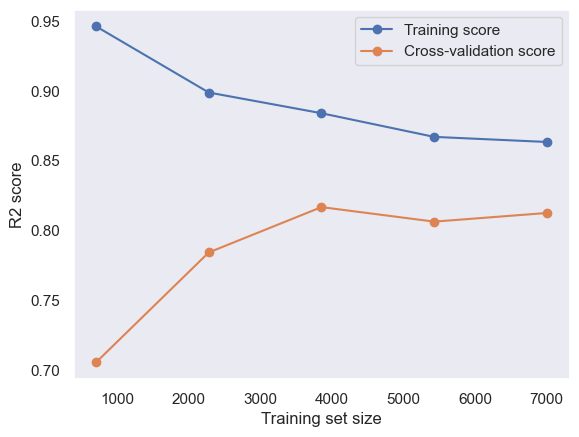

In [798]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')

plt.xlabel('Training set size')
plt.ylabel('R2 score')
plt.legend(loc='best')
plt.grid()

plt.show()


In [ ]:
df.columns[:-30]

Index(['start_month', 'pickups', 'duration_minutes', 'peak_hour',
       'bank_holiday', 'start_number_of_bikes', 'start_number_of_docks',
       'borough_name', '% of all people aged 16+ who are female',
       '% of all people aged 16+ who are male',
       ...
       'Health Deprivation and Disability - Proportion  of LSOAs in most deprived 10% nationally ',
       'Health Deprivation and Disability - Rank of proportion of LSOAs in most deprived 10% nationally ',
       'Crime - Average rank ', 'Crime - Rank of average rank ',
       'Crime - Average score ', 'Crime - Rank of average score ',
       'Crime - Proportion  of LSOAs in most deprived 10% nationally ',
       'Crime - Rank of proportion of LSOAs in most deprived 10% nationally ',
       'Barriers to Housing and Services - Average rank ',
       'Barriers to Housing and Services - Rank of average rank '],
      dtype='object', length=122)

In [ ]:
# trim end spaces
df.columns = df.columns.str.strip()

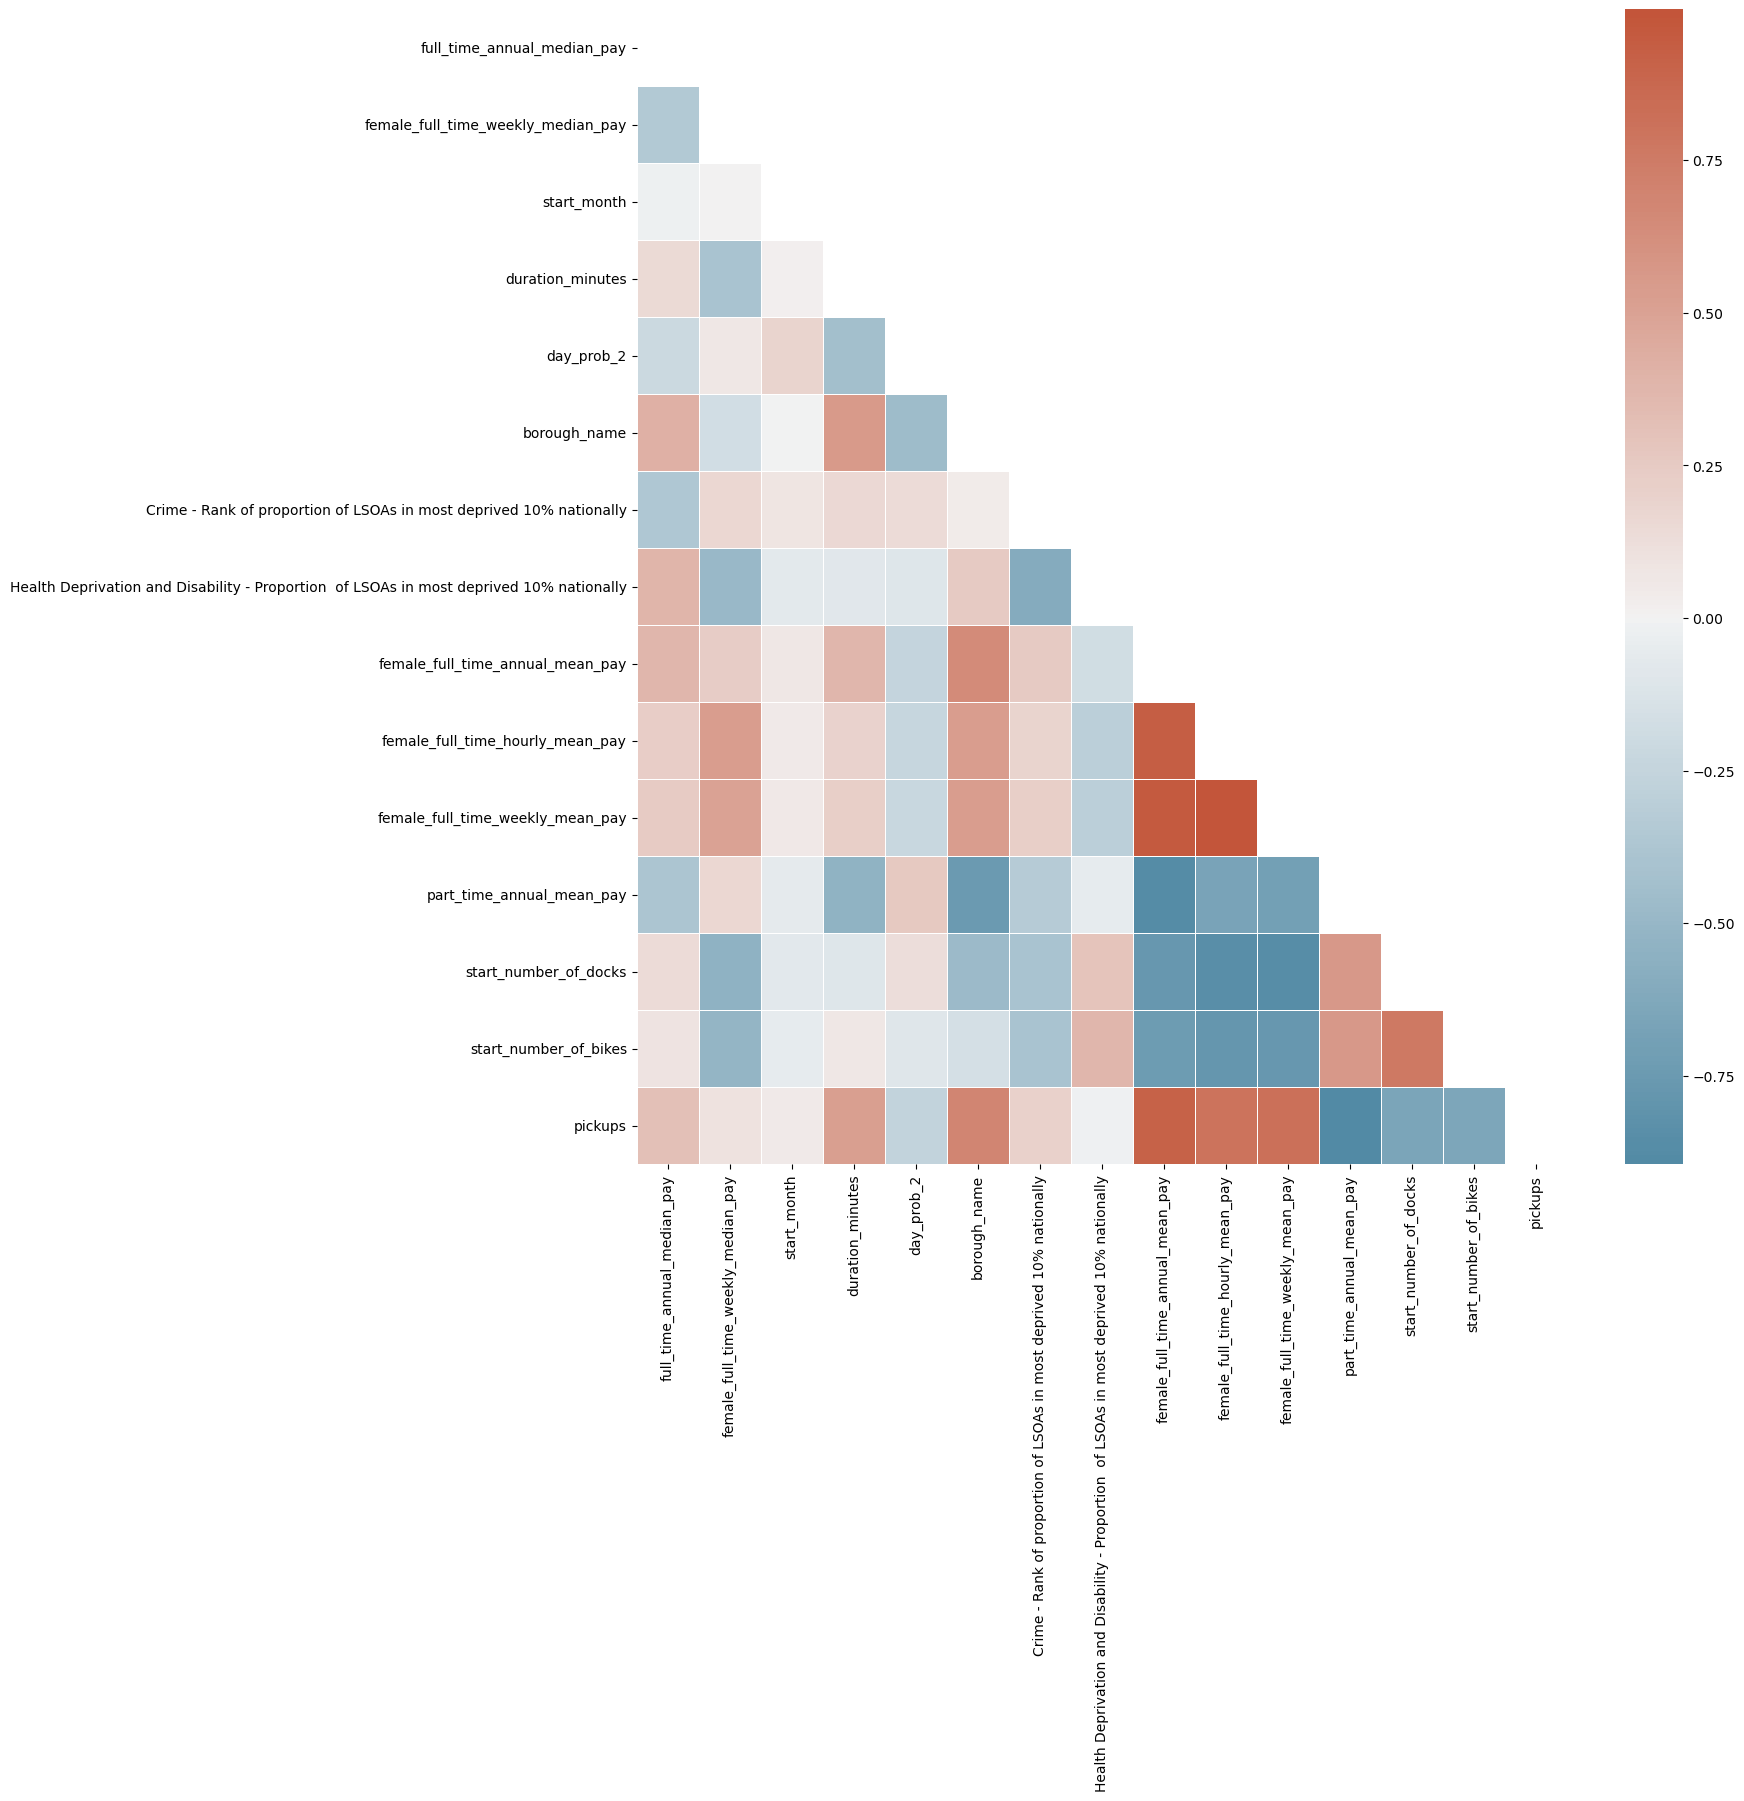

In [ ]:
# find correlation between demand and full_time_annual_median_pay,female_full_time_weekly_median_pay,start_month, Crime - Rank of proportion of LSOAs in most , duration_minutes
corr_matrix = df[['full_time_annual_median_pay', 'female_full_time_weekly_median_pay','start_month', 'duration_minutes', 'day_prob_2', 'borough_name','Crime - Rank of proportion of LSOAs in most deprived 10% nationally','Health Deprivation and Disability - Proportion  of LSOAs in most deprived 10% nationally','female_full_time_annual_mean_pay' ,'female_full_time_hourly_mean_pay',
'female_full_time_weekly_mean_pay','part_time_annual_mean_pay','start_number_of_docks','start_number_of_bikes', 'pickups']].corr()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
plt.figure(figsize=(15, 15))

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, linewidths=0.5)
plt.show()

In [ ]:
# print output of correlation matrix for pickups
print(corr_matrix['pickups'].sort_values(ascending=False))

pickups                                                                                     1.000000
female_full_time_annual_mean_pay                                                            0.909537
female_full_time_weekly_mean_pay                                                            0.815653
female_full_time_hourly_mean_pay                                                            0.802418
borough_name                                                                                0.684818
duration_minutes                                                                            0.520492
full_time_annual_median_pay                                                                 0.314824
Crime - Rank of proportion of LSOAs in most deprived 10% nationally                         0.200538
female_full_time_weekly_median_pay                                                          0.098491
start_month                                                                                

In [ ]:
# 66                         full_time_annual_median_pay    0.469321
# 70                  female_full_time_weekly_median_pay    0.235903
# 0                                          start_month    0.137842
# 118  Crime - Rank of proportion of LSOAs in most de...    0.083415
# 1                                     duration_minutes    0.050526
# 145                                         day_prob_2    0.021002
# 111  Health Deprivation and Disability - Proportion...    0.001991

In [ ]:
X_train.shape

(240, 150)

In [ ]:
# what does the tree look like?
print('decision path: ')
print(first_model.decision_path( X_train ))                                                                                

# output the tree to "dot" format for later visualising
tree.export_graphviz( first_model, out_file = './decision_tree.dot', class_names=df.pickup_label.unique(), impurity=True )
print('output dot file written to: ', 'decision_tree.dot')

decision path: 
  (0, 0)	1
  (0, 16)	1
  (0, 17)	1
  (0, 19)	1
  (1, 0)	1
  (1, 16)	1
  (1, 17)	1
  (1, 18)	1
  (2, 0)	1
  (2, 16)	1
  (2, 17)	1
  (2, 19)	1
  (3, 0)	1
  (3, 1)	1
  (3, 2)	1
  (3, 3)	1
  (3, 4)	1
  (4, 0)	1
  (4, 16)	1
  (4, 17)	1
  (4, 19)	1
  (5, 0)	1
  (5, 1)	1
  (5, 2)	1
  (5, 3)	1
  :	:
  (234, 3)	1
  (234, 4)	1
  (235, 0)	1
  (235, 16)	1
  (235, 17)	1
  (235, 18)	1
  (236, 0)	1
  (236, 1)	1
  (236, 2)	1
  (236, 3)	1
  (236, 4)	1
  (237, 0)	1
  (237, 16)	1
  (237, 17)	1
  (237, 19)	1
  (238, 0)	1
  (238, 1)	1
  (238, 9)	1
  (238, 10)	1
  (238, 11)	1
  (238, 13)	1
  (239, 0)	1
  (239, 16)	1
  (239, 17)	1
  (239, 19)	1
output dot file written to:  decision_tree.dot


In [ ]:
# Keep the following columns in a new dataframe female_full_time_annual_mean_pay, female_full_time_hourly_mean_pay,female_full_time_weekly_mean_pay,Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally, pickup_label, Barriers to Housing and Services - Rank of average score, Employment - Proportion  of LSOAs in most deprived 10% nationally, Barriers to Housing and Services - Average rank, start_number_of_docks,male_full_time_annual_median_pay,Barriers to Housing and Services - Average score ,start_number_of_bikes,male_part_time_hourly_mean_pay, male_part_time_weekly_mean_pay,
# male_part_time_weekly_mean_pay, part_time_annual_mean_pay , start_month, borough_name,Crime - Rank of proportion of LSOAs in most deprived 10% nationally,Health Deprivation and Disability - Proportion of LSOAs in most deprived 10% nationally
df_copy = df[['full_time_annual_median_pay', 'female_full_time_weekly_median_pay','start_month', 'duration_minutes', 'day_prob_2', 'borough_name','Crime - Rank of proportion of LSOAs in most deprived 10% nationally','Health Deprivation and Disability - Proportion  of LSOAs in most deprived 10% nationally','female_full_time_annual_mean_pay' ,'female_full_time_hourly_mean_pay',
'female_full_time_weekly_mean_pay','part_time_annual_mean_pay','start_number_of_docks','start_number_of_bikes', 'pickup_label']]              

# df_copy = df[['female_full_time_annual_mean_pay', 'female_full_time_hourly_mean_pay','female_full_time_weekly_mean_pay', 'Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally', 'Barriers to Housing and Services - Rank of average score', 'Employment - Proportion  of LSOAs in most deprived 10% nationally', 'Barriers to Housing and Services - Average rank', 'start_number_of_docks','male_full_time_annual_median_pay','Barriers to Housing and Services - Average score' ,'start_number_of_bikes','male_part_time_hourly_mean_pay', 'male_part_time_weekly_mean_pay',
# 'male_part_time_weekly_mean_pay', 'part_time_annual_mean_pay' , 'start_month', 'borough_name','Crime - Rank of proportion of LSOAs in most deprived 10% nationally','Health Deprivation and Disability - Proportion  of LSOAs in most deprived 10% nationally', 'pickup_label']]              

In [ ]:
df_copy['pickup_label'].value_counts()

low       101
high      100
medium    100
Name: pickup_label, dtype: int64

In [ ]:
# Separate the features and target variable
X = df_copy.drop(['pickup_label'], axis=1)
y = df_copy['pickup_label']

# Split the data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# second_model = DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 5, min_samples_split= 15,  random_state=42)


second_model = DecisionTreeClassifier(max_depth= 10, min_samples_leaf= 5, min_samples_split= 12,  random_state=42)

In [ ]:

from sklearn.metrics import accuracy_score, classification_report

second_model.fit(X_train, y_train)

y_pred = second_model.predict(X_test)

# calculate accuracy of training
print('training score = ', second_model.score( X_train, y_train ))
print('test score = ', second_model.score( X_test, y_test ))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

training score =  0.9625
test score =  0.9836065573770492
Accuracy: 0.9836065573770492
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        20
         low       1.00      0.95      0.98        21
      medium       0.95      1.00      0.98        20

    accuracy                           0.98        61
   macro avg       0.98      0.98      0.98        61
weighted avg       0.98      0.98      0.98        61



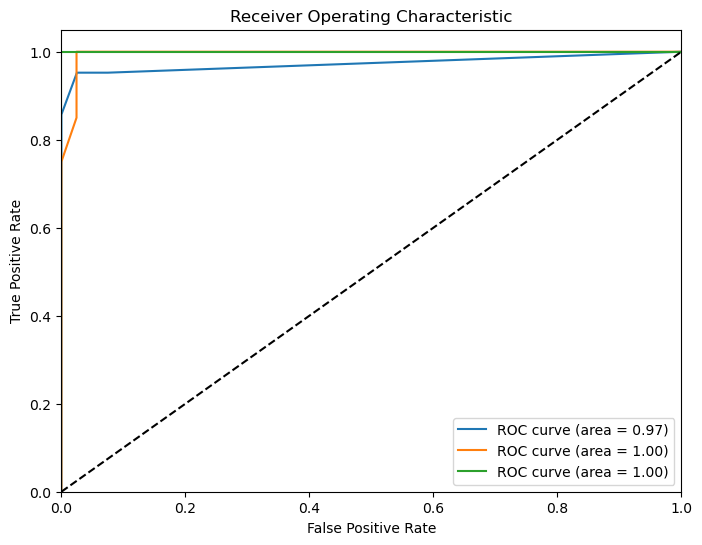

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# add roc auc score

# make y_test and y_train binary
y_test = label_binarize(y_test, classes=['low', 'medium', 'high'])
y_train = label_binarize(y_train, classes=['low', 'medium', 'high'])
n_classes = y_train.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(first_model)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
importance = second_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print feature importance
print(feature_importance)

                                              Feature  Importance
0                         full_time_annual_median_pay    0.469321
1                  female_full_time_weekly_median_pay    0.235903
2                                         start_month    0.137842
13                              start_number_of_bikes    0.083415
3                                    duration_minutes    0.050526
4                                          day_prob_2    0.021002
7   Health Deprivation and Disability - Proportion...    0.001991
5                                        borough_name    0.000000
6   Crime - Rank of proportion of LSOAs in most de...    0.000000
8                    female_full_time_annual_mean_pay    0.000000
9                    female_full_time_hourly_mean_pay    0.000000
10                   female_full_time_weekly_mean_pay    0.000000
11                          part_time_annual_mean_pay    0.000000
12                              start_number_of_docks    0.000000


In [ ]:
# what does the tree look like?
print('decision path: ')
print(second_model.decision_path( X_train ))                                                                                

# output the tree to "dot" format for later visualising
tree.export_graphviz( second_model, out_file = './decision_tree.dot', class_names=df_copy.pickup_label.unique(), impurity=True )
print('output dot file written to: ', 'decision_tree.dot')

decision path: 
  (0, 0)	1
  (0, 16)	1
  (0, 17)	1
  (0, 19)	1
  (1, 0)	1
  (1, 16)	1
  (1, 17)	1
  (1, 18)	1
  (2, 0)	1
  (2, 16)	1
  (2, 17)	1
  (2, 19)	1
  (3, 0)	1
  (3, 1)	1
  (3, 11)	1
  (3, 12)	1
  (3, 14)	1
  (4, 0)	1
  (4, 16)	1
  (4, 17)	1
  (4, 19)	1
  (5, 0)	1
  (5, 1)	1
  (5, 11)	1
  (5, 15)	1
  :	:
  (234, 12)	1
  (234, 14)	1
  (235, 0)	1
  (235, 16)	1
  (235, 17)	1
  (235, 18)	1
  (236, 0)	1
  (236, 1)	1
  (236, 11)	1
  (236, 12)	1
  (236, 14)	1
  (237, 0)	1
  (237, 16)	1
  (237, 17)	1
  (237, 19)	1
  (238, 0)	1
  (238, 1)	1
  (238, 2)	1
  (238, 6)	1
  (238, 8)	1
  (238, 10)	1
  (239, 0)	1
  (239, 16)	1
  (239, 17)	1
  (239, 19)	1
output dot file written to:  decision_tree.dot
